In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats, optimize
from scipy.optimize import nnls

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue.dynamics.planar_gradients import area_grad
from tyssue_taylor.adjusters.adjust_annular import (prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale, adjust_parameters)
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model, lumen_area_grad
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, _coef_matrix, _right_side
from tyssue_taylor.models.display import (create_organo, print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference)

Error: IPOPT shared library failed to import


Using TensorFlow backend.


In [4]:
sym_org = generate_ring(20, 1, 2)


In [5]:
def create_organo(nb_cells, r_in, r_out, seed=None, rot=None, geom=geom):
    organo = generate_ring(nb_cells, r_in, r_out)
    Nf = organo.Nf
    geom.update_all(organo)
    alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))
    specs = {
        'face': {
            'is_alive': 1,
            'prefered_area': organo.face_df.area,
            'area_elasticity': 1., },
        'edge': {
            'ux': 0.,
            'uy': 0.,
            'uz': 0.,
            'line_tension': 0.1,
            'is_active': 1
            },
        'vert': {
            'adhesion_strength': 0.,
            'x_ecm': 0.,
            'y_ecm': 0.,
            'is_active': 1
            },
        'settings': {
            'lumen_elasticity': 0.1,
            'lumen_prefered_vol': organo.settings['lumen_volume'],
            'lumen_volume': organo.settings['lumen_volume']
            }
        }
    organo.update_specs(specs, reset=True)
    normalize_scale(organo, geom, refer='edges')
    geom.update_all(organo)
    if seed is not None:
        symetric_tensions = set_init_point(organo.settings['R_in'],
                                           organo.settings['R_out'],
                                           organo.Nf, alpha)
        sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, organo.Nf,
                                        endpoint=False)))**2
        organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, organo.Nf)
        organo.edge_df.line_tension = prepare_tensions(organo,
                                                       symetric_tensions)
        organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul*np.random.normal(
            1.0, 0.05, organo.Nf)
        geom.update_all(organo)
    if rot is not None:
        organo.vert_df.loc[:, 'x'] = (organo.vert_df.x.copy() * np.cos(rot) -
                                      organo.vert_df.y.copy() * np.sin(rot))
        print('rotated x',
              organo.vert_df.x.copy() * np.cos(rot) -
              organo.vert_df.y.copy() * np.sin(rot))
        organo.vert_df.loc[:, 'y'] = (organo.vert_df.x.copy() * np.sin(rot) +
                                      organo.vert_df.y.copy() * np.cos(rot))
        print('rotated y',
              organo.vert_df.x.copy() * np.sin(rot) +
              organo.vert_df.y.copy() * np.cos(rot))
        geom.update_all(organo)
    organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]
    organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01
    new_tensions = organo.edge_df.line_tension
    organo.edge_df.loc[:, 'line_tension'] = new_tensions
    return organo

Reseting datasets values with new specs


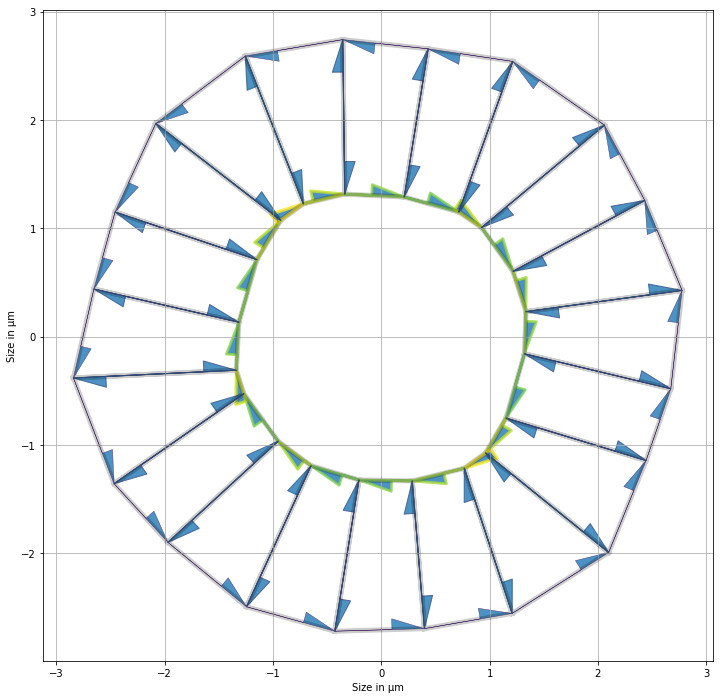

In [6]:
nf, r_in, r_out = (20, 1, 2)
seed = 1
organo3 = create_organo(nf, r_in, r_out)

organo3.edge_df.loc[organo3.apical_edges, 'line_tension'] = [
    0.101, 0.115, 0.126, 0.110, 0.105,
    0.102, 0.112, 0.102, 0.118, 0.105,
    0.104, 0.115, 0.127, 0.116, 0.106,
    0.103, 0.117, 0.105, 0.111, 0.107
]

organo3.edge_df.loc[organo3.basal_edges, 'line_tension'] = [
    0.01, 0.011, 0.012, 0.011, 0.01,
    0.01, 0.011, 0.01, 0.011, 0.01,
    0.01, 0.011, 0.012, 0.011, 0.01,
    0.01, 0.011, 0.01, 0.011, 0.01
]

organo3.edge_df.loc[organo3.lateral_edges, 'line_tension'] = np.array([
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03
])

organo3.face_df.loc[:, 'prefered_area'] = np.array([
    0.08, 0.07, 0.08, 0.09, 0.09,
    0.10, 0.09, 0.08, 0.09, 0.09,
    0.10, 0.11, 0.10, 0.11, 0.12,
    0.11, 0.10, 0.09, 0.08, 0.09
]) + organo3.face_df.area

geom.update_all(organo3)
Solver.find_energy_min(organo3, geom, model)
print_tensions(organo3, organo3)

In [7]:
real_data = np.concatenate((organo3.edge_df.line_tension[:3*organo3.Nf],
                            organo3.face_df.prefered_area - organo3.face_df.area,
                            [organo3.settings['lumen_prefered_vol']-
                             organo3.settings['lumen_volume']]))
print(organo3.edge_df.line_tension, '\n',
      organo3.face_df.prefered_area - organo3.face_df.area)

edge
0     0.101
1     0.115
2     0.126
3     0.110
4     0.105
5     0.102
6     0.112
7     0.102
8     0.118
9     0.105
10    0.104
11    0.115
12    0.127
13    0.116
14    0.106
15    0.103
16    0.117
17    0.105
18    0.111
19    0.107
20    0.010
21    0.011
22    0.012
23    0.011
24    0.010
25    0.010
26    0.011
27    0.010
28    0.011
29    0.010
      ...  
50    0.030
51    0.035
52    0.040
53    0.035
54    0.030
55    0.030
56    0.035
57    0.030
58    0.035
59    0.030
60    0.030
61    0.035
62    0.040
63    0.035
64    0.030
65    0.030
66    0.035
67    0.030
68    0.035
69    0.030
70    0.030
71    0.035
72    0.040
73    0.035
74    0.030
75    0.030
76    0.035
77    0.030
78    0.035
79    0.030
Name: line_tension, Length: 80, dtype: float64 
 face
0     0.037466
1     0.042980
2     0.047452
3     0.041083
4     0.039120
5     0.037130
6     0.042399
7     0.037119
8     0.043188
9     0.038093
10    0.038654
11    0.042510
12    0.047137
13    0.042130

In [8]:
energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-5}}


bfgs_opt = {'method': 'bfgs','options': {'gtol':1e-1,'ftol': 1e-5}}
trf_opt = {'bounds': ([-1e-8]*(3*organo3.Nf),[1000]*(3*organo3.Nf)), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-3, 'verbose': 2}
lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-3, 'verbose': 1}
psqp_opt = {'lb': 0, 'ub': 1e6, 'method': 'dist_PSQP', #'callback': printx,
            'output_path': './PSQP_eq_cst_per_cell.out'}
nm_opt = {'method':'Nelder-Mead', 'options': {'disp': True}}

reg_weight = 1e-3
theta = 0.02

In [9]:
def get_sim_mat(Nf, Ra, Rb, sum_lbda=1e-2):

    sin_t = np.sin(np.pi/Nf)
    sin_2t = np.sin(2*np.pi/Nf)

    A = 0.5 * (Rb**2 - Ra**2) * sin_2t
    dAdRa = - sin_2t * Ra
    dAdRb = sin_2t * Rb
    dladRa = dlbdRb = 2*sin_t

    # variables are
    # (A - A_0), \Lambda_a, \Lambda_h
    problem_mat = np.array(
        [
            [dAdRa, dladRa, -1],
            [dAdRb, 0,       1],
            [0,     1,       1]
        ])

    b = np.array([0, 0, sum_lbda])
    return problem_mat, b

In [10]:
params_in_sym_mesh = np.linalg.solve(*get_sim_mat(nf, r_in, r_out))

Maintenant on connait les paramètres dans l'organoïde régulier. Il s'agit maintenant de calculer la déformation entre les cellules de l'organoïde régulier et les cellules de l'organoïde réel.

In [11]:
organo3.get_extra_indices()
non_lateral_edges = np.concatenate((organo3.apical_edges,
                                    organo3.basal_edges))
sym_height = (r_out-r_in)*np.cos(np.pi/organo3.Nf)
polar_coefs = np.ones(organo3.Nf)
for cell in range(organo3.Nf):
    parrallel_edges = (organo3.edge_df.loc[non_lateral_edges, ('srce', 'trgt')]
                       [organo3.edge_df.face == cell]).values
    apical_middle = organo3.vert_df.loc[parrallel_edges[0, :], ('x', 'y')].sum()/2
    basal_middle = organo3.vert_df.loc[parrallel_edges[1, :], ('x', 'y')].sum()/2
    cell_height = np.linalg.norm(apical_middle - basal_middle)
    polar_coefs[cell] = cell_height/sym_height
polar_coefs

/home/fquinton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


array([1.38680545, 1.39720938, 1.39441585, 1.39709666, 1.39832084,
       1.42797119, 1.3959597 , 1.43345176, 1.44201388, 1.44398528,
       1.392824  , 1.41778809, 1.42702144, 1.43985784, 1.4182954 ,
       1.44300866, 1.44280479, 1.43956153, 1.41285569, 1.41541343])

Et maintenant on fixe la constante par cellule selon les paramètres dans l'organoïde symétrique et le coefficient de polarisation

[0.021433658384297522, 0.021433658384297522, 0.021433658384297522, 0.021433658384297522, 0.021433658384297522, 0.021433658384297522, 0.021433658384297522, 0.021433658384297522, 0.021433658384297522, 0.021433658384297522, 0.021433658384297522, 0.021433658384297522, 0.021433658384297522, 0.021433658384297522, 0.021433658384297522, 0.021433658384297522, 0.021433658384297522, 0.021433658384297522, 0.021433658384297522, 0.021433658384297522]
[0.02972431 0.02994731 0.02988743 0.02994489 0.02997113 0.03060665
 0.02992052 0.03072412 0.03090763 0.03094989 0.02985331 0.03038839
 0.03058629 0.03086142 0.03039926 0.03092895 0.03092459 0.03085507
 0.03028267 0.03033749]
Apical tensions:  [0.00190961 0.00213134 0.00207471 0.00202562 0.00205053 0.00229353
 0.00197031 0.00232007 0.00249646 0.00243061 0.00194718 0.00231429
 0.00238461 0.00244723 0.00220418 0.00244249 0.00248466 0.00235021
 0.00213933 0.00222037] 
Basal tensions:  [9.89341076e-05 1.39368907e-04 0.00000000e+00 1.36972862e-04
 2.04707468e

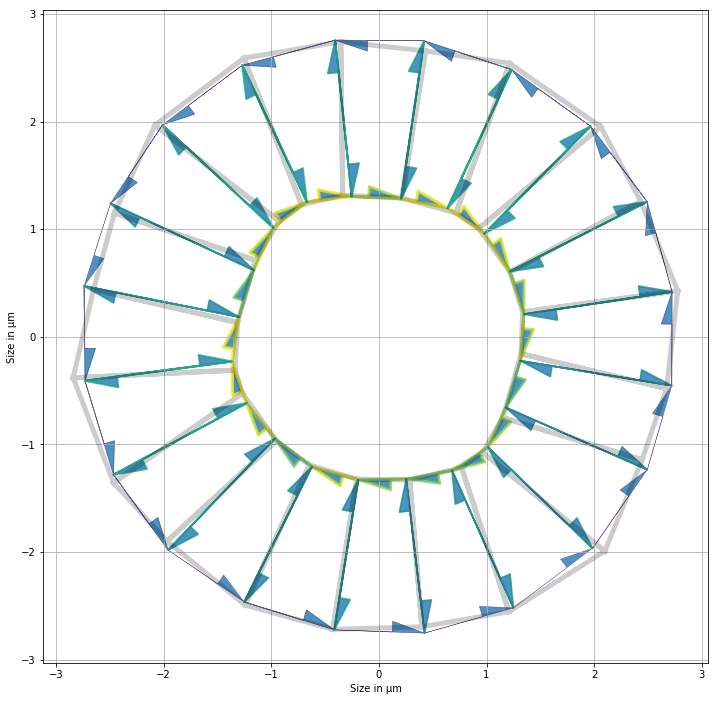

In [12]:
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
avg_cste = [4*((params_in_sym_mesh[1:].sum()+params_in_sym_mesh[-1])/3 /
               (organo3.face_df.area.mean() + params_in_sym_mesh[0])**1.5)]*organo3.Nf
print(avg_cste)
avg_cste = np.multiply(np.array(avg_cste), polar_coefs)
print(avg_cste)
for i in range(organo3.Nf):
    i_cell_line = np.zeros(4*organo3.Nf+1)
    index = np.squeeze(np.argwhere(organo3.edge_df.face.values == i)[:-1])
    i_cell_line[index] = 1
    matrix = np.vstack((matrix, i_cell_line))
constant = np.concatenate((constant, avg_cste))
mat_eq_cst, residuals = nnls(matrix, constant)
organo3_eq_cst = organo3.copy()
organo3_eq_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_eq_cst,
                                                                 mat_eq_cst[:3*organo3.Nf])
organo3_eq_cst.face_df.loc[:, 'prefered_area'] = organo3_eq_cst.face_df.area + mat_eq_cst[3*organo3.Nf:
                                                                                          4*organo3.Nf]
organo3_eq_cst.settings['lumen_prefered_vol'] = organo3_eq_cst.settings['lumen_volume'] + mat_eq_cst[-1]
Solver.find_energy_min(organo3_eq_cst, geom, model)
print_tensions(organo3_eq_cst, organo3)
print('Apical tensions: ', mat_eq_cst[organo3.apical_edges],
      '\nBasal tensions: ', mat_eq_cst[organo3.basal_edges],
      '\nLateral tensions: ', mat_eq_cst[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', mat_eq_cst[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', mat_eq_cst[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-mat_eq_cst),
      '\nNNLS residuals: ', residuals)

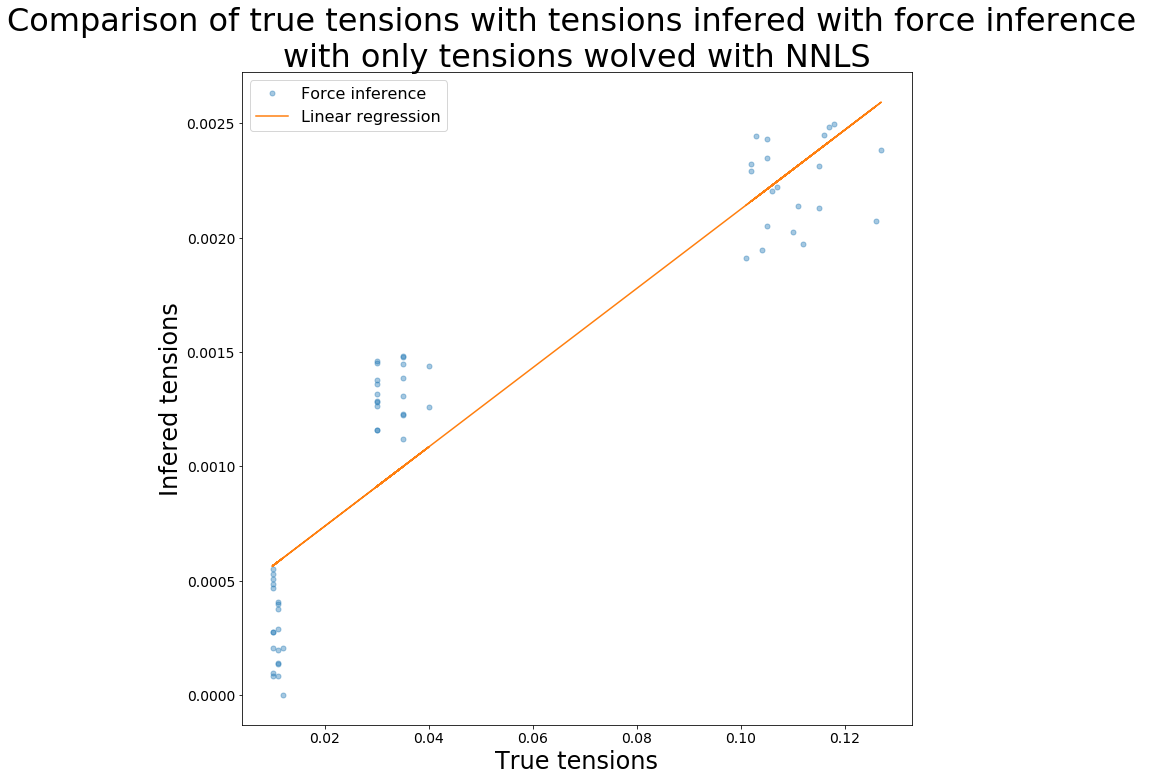

R value : 0.9195904112270638 
Standard error : 0.0002757519795939642


In [13]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  mat_eq_cst[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

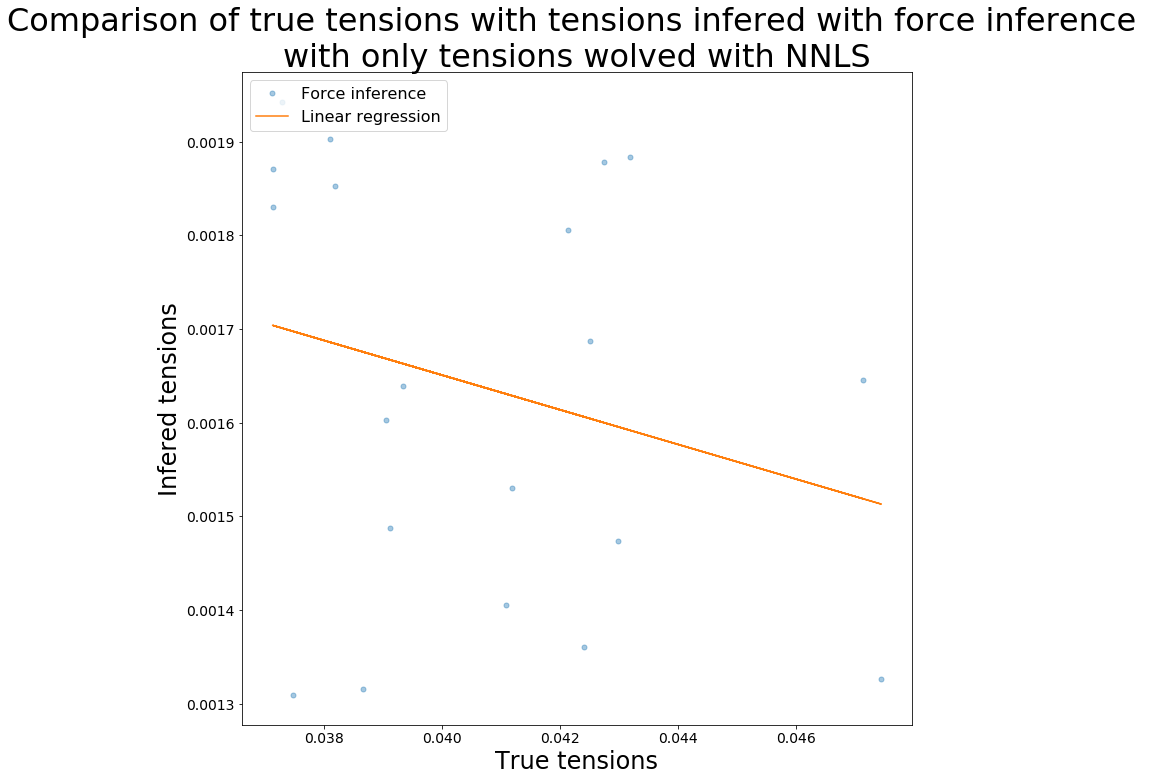

R value : -0.25628321015470795 
Standard error : 0.00010539709639414677


In [14]:
rendering_results(organo3, organo3.face_df.eval('prefered_area-area'),
                  mat_eq_cst[3*organo3.Nf:-1],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

In [15]:
iprint_file = "../../assets/dist_at_each_f_ev/10_03_eq_t_per_cell_areas_opt_with_sym_org_params.txt"
to_opt_organo = organo3.copy()
init_point_area_and_tensions_opt = np.concatenate((prepare_tensions(to_opt_organo, mat_eq_cst[:3*organo3.Nf]),
                                                   to_opt_organo.face_df.area + mat_eq_cst[3*organo3.Nf:-1],
                                                   [to_opt_organo.settings['lumen_volume'] + mat_eq_cst[-1]]))
res_2_cst_areas = adjust_parameters(to_opt_organo,
                                    init_point_area_and_tensions_opt,
                                    {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                                    energy_min_opt=energy_opt,
                                    **lm_opt)

{'method': 'lm', 'xtol': 1e-05, 'ftol': 0.001, 'verbose': 1}
I know I do LM
edge line_tension [1.90960700e-03 2.13133602e-03 2.07471476e-03 2.02562033e-03
 2.05052527e-03 2.29353063e-03 1.97031493e-03 2.32007383e-03
 2.49645997e-03 2.43061141e-03 1.94717822e-03 2.31429033e-03
 2.38460637e-03 2.44723343e-03 2.20418011e-03 2.44249050e-03
 2.48466324e-03 2.35020577e-03 2.13933464e-03 2.22036737e-03
 9.89341076e-05 1.39368907e-04 0.00000000e+00 1.36972862e-04
 2.04707468e-04 4.67750125e-04 8.50225508e-05 5.29044337e-04
 4.05653787e-04 5.08688341e-04 8.34314393e-05 2.87630420e-04
 2.06086939e-04 3.78672433e-04 2.76726338e-04 5.49649457e-04
 3.99639598e-04 4.87100005e-04 1.99336597e-04 2.76149322e-04
 1.15801709e-03 1.11862061e-03 1.25825973e-03 1.22477629e-03
 1.15782444e-03 1.28755888e-03 1.30726430e-03 1.31760293e-03
 1.44777542e-03 1.45180375e-03 1.26504313e-03 1.22891299e-03
 1.43794470e-03 1.47777523e-03 1.36082096e-03 1.37832829e-03
 1.48274822e-03 1.45947715e-03 1.38580817e-03 1.2831

edge line_tension [1.90960700e-03 2.13133602e-03 2.07471476e-03 2.02562036e-03
 2.05052527e-03 2.29353063e-03 1.97031493e-03 2.32007383e-03
 2.49645997e-03 2.43061141e-03 1.94717822e-03 2.31429033e-03
 2.38460637e-03 2.44723343e-03 2.20418011e-03 2.44249050e-03
 2.48466324e-03 2.35020577e-03 2.13933464e-03 2.22036737e-03
 9.89341076e-05 1.39368907e-04 0.00000000e+00 1.36972862e-04
 2.04707468e-04 4.67750125e-04 8.50225508e-05 5.29044337e-04
 4.05653787e-04 5.08688341e-04 8.34314393e-05 2.87630420e-04
 2.06086939e-04 3.78672433e-04 2.76726338e-04 5.49649457e-04
 3.99639598e-04 4.87100005e-04 1.99336597e-04 2.76149322e-04
 1.15801709e-03 1.11862061e-03 1.25825973e-03 1.22477629e-03
 1.15782444e-03 1.28755888e-03 1.30726430e-03 1.31760293e-03
 1.44777542e-03 1.45180375e-03 1.26504313e-03 1.22891299e-03
 1.43794470e-03 1.47777523e-03 1.36082096e-03 1.37832829e-03
 1.48274822e-03 1.45947715e-03 1.38580817e-03 1.28312545e-03
 1.11862061e-03 1.25825973e-03 1.22477629e-03 1.15782444e-03
 1.287

edge line_tension [1.90960700e-03 2.13133602e-03 2.07471476e-03 2.02562033e-03
 2.05052527e-03 2.29353063e-03 1.97031493e-03 2.32007383e-03
 2.49645997e-03 2.43061144e-03 1.94717822e-03 2.31429033e-03
 2.38460637e-03 2.44723343e-03 2.20418011e-03 2.44249050e-03
 2.48466324e-03 2.35020577e-03 2.13933464e-03 2.22036737e-03
 9.89341076e-05 1.39368907e-04 0.00000000e+00 1.36972862e-04
 2.04707468e-04 4.67750125e-04 8.50225508e-05 5.29044337e-04
 4.05653787e-04 5.08688341e-04 8.34314393e-05 2.87630420e-04
 2.06086939e-04 3.78672433e-04 2.76726338e-04 5.49649457e-04
 3.99639598e-04 4.87100005e-04 1.99336597e-04 2.76149322e-04
 1.15801709e-03 1.11862061e-03 1.25825973e-03 1.22477629e-03
 1.15782444e-03 1.28755888e-03 1.30726430e-03 1.31760293e-03
 1.44777542e-03 1.45180375e-03 1.26504313e-03 1.22891299e-03
 1.43794470e-03 1.47777523e-03 1.36082096e-03 1.37832829e-03
 1.48274822e-03 1.45947715e-03 1.38580817e-03 1.28312545e-03
 1.11862061e-03 1.25825973e-03 1.22477629e-03 1.15782444e-03
 1.287

edge line_tension [1.90960700e-03 2.13133602e-03 2.07471476e-03 2.02562033e-03
 2.05052527e-03 2.29353063e-03 1.97031493e-03 2.32007383e-03
 2.49645997e-03 2.43061141e-03 1.94717822e-03 2.31429033e-03
 2.38460637e-03 2.44723343e-03 2.20418011e-03 2.44249054e-03
 2.48466324e-03 2.35020577e-03 2.13933464e-03 2.22036737e-03
 9.89341076e-05 1.39368907e-04 0.00000000e+00 1.36972862e-04
 2.04707468e-04 4.67750125e-04 8.50225508e-05 5.29044337e-04
 4.05653787e-04 5.08688341e-04 8.34314393e-05 2.87630420e-04
 2.06086939e-04 3.78672433e-04 2.76726338e-04 5.49649457e-04
 3.99639598e-04 4.87100005e-04 1.99336597e-04 2.76149322e-04
 1.15801709e-03 1.11862061e-03 1.25825973e-03 1.22477629e-03
 1.15782444e-03 1.28755888e-03 1.30726430e-03 1.31760293e-03
 1.44777542e-03 1.45180375e-03 1.26504313e-03 1.22891299e-03
 1.43794470e-03 1.47777523e-03 1.36082096e-03 1.37832829e-03
 1.48274822e-03 1.45947715e-03 1.38580817e-03 1.28312545e-03
 1.11862061e-03 1.25825973e-03 1.22477629e-03 1.15782444e-03
 1.287

edge line_tension [1.90960700e-03 2.13133602e-03 2.07471476e-03 2.02562033e-03
 2.05052527e-03 2.29353063e-03 1.97031493e-03 2.32007383e-03
 2.49645997e-03 2.43061141e-03 1.94717822e-03 2.31429033e-03
 2.38460637e-03 2.44723343e-03 2.20418011e-03 2.44249050e-03
 2.48466324e-03 2.35020577e-03 2.13933464e-03 2.22036737e-03
 9.89341076e-05 1.39368909e-04 0.00000000e+00 1.36972862e-04
 2.04707468e-04 4.67750125e-04 8.50225508e-05 5.29044337e-04
 4.05653787e-04 5.08688341e-04 8.34314393e-05 2.87630420e-04
 2.06086939e-04 3.78672433e-04 2.76726338e-04 5.49649457e-04
 3.99639598e-04 4.87100005e-04 1.99336597e-04 2.76149322e-04
 1.15801709e-03 1.11862061e-03 1.25825973e-03 1.22477629e-03
 1.15782444e-03 1.28755888e-03 1.30726430e-03 1.31760293e-03
 1.44777542e-03 1.45180375e-03 1.26504313e-03 1.22891299e-03
 1.43794470e-03 1.47777523e-03 1.36082096e-03 1.37832829e-03
 1.48274822e-03 1.45947715e-03 1.38580817e-03 1.28312545e-03
 1.11862061e-03 1.25825973e-03 1.22477629e-03 1.15782444e-03
 1.287

edge line_tension [1.90960700e-03 2.13133602e-03 2.07471476e-03 2.02562033e-03
 2.05052527e-03 2.29353063e-03 1.97031493e-03 2.32007383e-03
 2.49645997e-03 2.43061141e-03 1.94717822e-03 2.31429033e-03
 2.38460637e-03 2.44723343e-03 2.20418011e-03 2.44249050e-03
 2.48466324e-03 2.35020577e-03 2.13933464e-03 2.22036737e-03
 9.89341076e-05 1.39368907e-04 0.00000000e+00 1.36972862e-04
 2.04707468e-04 4.67750125e-04 8.50225508e-05 5.29044344e-04
 4.05653787e-04 5.08688341e-04 8.34314393e-05 2.87630420e-04
 2.06086939e-04 3.78672433e-04 2.76726338e-04 5.49649457e-04
 3.99639598e-04 4.87100005e-04 1.99336597e-04 2.76149322e-04
 1.15801709e-03 1.11862061e-03 1.25825973e-03 1.22477629e-03
 1.15782444e-03 1.28755888e-03 1.30726430e-03 1.31760293e-03
 1.44777542e-03 1.45180375e-03 1.26504313e-03 1.22891299e-03
 1.43794470e-03 1.47777523e-03 1.36082096e-03 1.37832829e-03
 1.48274822e-03 1.45947715e-03 1.38580817e-03 1.28312545e-03
 1.11862061e-03 1.25825973e-03 1.22477629e-03 1.15782444e-03
 1.287

edge line_tension [1.90960700e-03 2.13133602e-03 2.07471476e-03 2.02562033e-03
 2.05052527e-03 2.29353063e-03 1.97031493e-03 2.32007383e-03
 2.49645997e-03 2.43061141e-03 1.94717822e-03 2.31429033e-03
 2.38460637e-03 2.44723343e-03 2.20418011e-03 2.44249050e-03
 2.48466324e-03 2.35020577e-03 2.13933464e-03 2.22036737e-03
 9.89341076e-05 1.39368907e-04 0.00000000e+00 1.36972862e-04
 2.04707468e-04 4.67750125e-04 8.50225508e-05 5.29044337e-04
 4.05653787e-04 5.08688341e-04 8.34314393e-05 2.87630420e-04
 2.06086939e-04 3.78672439e-04 2.76726338e-04 5.49649457e-04
 3.99639598e-04 4.87100005e-04 1.99336597e-04 2.76149322e-04
 1.15801709e-03 1.11862061e-03 1.25825973e-03 1.22477629e-03
 1.15782444e-03 1.28755888e-03 1.30726430e-03 1.31760293e-03
 1.44777542e-03 1.45180375e-03 1.26504313e-03 1.22891299e-03
 1.43794470e-03 1.47777523e-03 1.36082096e-03 1.37832829e-03
 1.48274822e-03 1.45947715e-03 1.38580817e-03 1.28312545e-03
 1.11862061e-03 1.25825973e-03 1.22477629e-03 1.15782444e-03
 1.287

edge line_tension [1.90960700e-03 2.13133602e-03 2.07471476e-03 2.02562033e-03
 2.05052527e-03 2.29353063e-03 1.97031493e-03 2.32007383e-03
 2.49645997e-03 2.43061141e-03 1.94717822e-03 2.31429033e-03
 2.38460637e-03 2.44723343e-03 2.20418011e-03 2.44249050e-03
 2.48466324e-03 2.35020577e-03 2.13933464e-03 2.22036737e-03
 9.89341076e-05 1.39368907e-04 0.00000000e+00 1.36972862e-04
 2.04707468e-04 4.67750125e-04 8.50225508e-05 5.29044337e-04
 4.05653787e-04 5.08688341e-04 8.34314393e-05 2.87630420e-04
 2.06086939e-04 3.78672433e-04 2.76726338e-04 5.49649457e-04
 3.99639598e-04 4.87100005e-04 1.99336597e-04 2.76149326e-04
 1.15801709e-03 1.11862061e-03 1.25825973e-03 1.22477629e-03
 1.15782444e-03 1.28755888e-03 1.30726430e-03 1.31760293e-03
 1.44777542e-03 1.45180375e-03 1.26504313e-03 1.22891299e-03
 1.43794470e-03 1.47777523e-03 1.36082096e-03 1.37832829e-03
 1.48274822e-03 1.45947715e-03 1.38580817e-03 1.28312545e-03
 1.11862061e-03 1.25825973e-03 1.22477629e-03 1.15782444e-03
 1.287

edge line_tension [1.90960700e-03 2.13133602e-03 2.07471476e-03 2.02562033e-03
 2.05052527e-03 2.29353063e-03 1.97031493e-03 2.32007383e-03
 2.49645997e-03 2.43061141e-03 1.94717822e-03 2.31429033e-03
 2.38460637e-03 2.44723343e-03 2.20418011e-03 2.44249050e-03
 2.48466324e-03 2.35020577e-03 2.13933464e-03 2.22036737e-03
 9.89341076e-05 1.39368907e-04 0.00000000e+00 1.36972862e-04
 2.04707468e-04 4.67750125e-04 8.50225508e-05 5.29044337e-04
 4.05653787e-04 5.08688341e-04 8.34314393e-05 2.87630420e-04
 2.06086939e-04 3.78672433e-04 2.76726338e-04 5.49649457e-04
 3.99639598e-04 4.87100005e-04 1.99336597e-04 2.76149322e-04
 1.15801709e-03 1.11862061e-03 1.25825973e-03 1.22477629e-03
 1.15782444e-03 1.28755890e-03 1.30726430e-03 1.31760293e-03
 1.44777542e-03 1.45180375e-03 1.26504313e-03 1.22891299e-03
 1.43794470e-03 1.47777523e-03 1.36082096e-03 1.37832829e-03
 1.48274822e-03 1.45947715e-03 1.38580817e-03 1.28312545e-03
 1.11862061e-03 1.25825973e-03 1.22477629e-03 1.15782444e-03
 1.287

edge line_tension [1.90960700e-03 2.13133602e-03 2.07471476e-03 2.02562033e-03
 2.05052527e-03 2.29353063e-03 1.97031493e-03 2.32007383e-03
 2.49645997e-03 2.43061141e-03 1.94717822e-03 2.31429033e-03
 2.38460637e-03 2.44723343e-03 2.20418011e-03 2.44249050e-03
 2.48466324e-03 2.35020577e-03 2.13933464e-03 2.22036737e-03
 9.89341076e-05 1.39368907e-04 0.00000000e+00 1.36972862e-04
 2.04707468e-04 4.67750125e-04 8.50225508e-05 5.29044337e-04
 4.05653787e-04 5.08688341e-04 8.34314393e-05 2.87630420e-04
 2.06086939e-04 3.78672433e-04 2.76726338e-04 5.49649457e-04
 3.99639598e-04 4.87100005e-04 1.99336597e-04 2.76149322e-04
 1.15801709e-03 1.11862061e-03 1.25825973e-03 1.22477629e-03
 1.15782444e-03 1.28755888e-03 1.30726430e-03 1.31760293e-03
 1.44777542e-03 1.45180375e-03 1.26504313e-03 1.22891300e-03
 1.43794470e-03 1.47777523e-03 1.36082096e-03 1.37832829e-03
 1.48274822e-03 1.45947715e-03 1.38580817e-03 1.28312545e-03
 1.11862061e-03 1.25825973e-03 1.22477629e-03 1.15782444e-03
 1.287

edge line_tension [1.90960700e-03 2.13133602e-03 2.07471476e-03 2.02562033e-03
 2.05052527e-03 2.29353063e-03 1.97031493e-03 2.32007383e-03
 2.49645997e-03 2.43061141e-03 1.94717822e-03 2.31429033e-03
 2.38460637e-03 2.44723343e-03 2.20418011e-03 2.44249050e-03
 2.48466324e-03 2.35020577e-03 2.13933464e-03 2.22036737e-03
 9.89341076e-05 1.39368907e-04 0.00000000e+00 1.36972862e-04
 2.04707468e-04 4.67750125e-04 8.50225508e-05 5.29044337e-04
 4.05653787e-04 5.08688341e-04 8.34314393e-05 2.87630420e-04
 2.06086939e-04 3.78672433e-04 2.76726338e-04 5.49649457e-04
 3.99639598e-04 4.87100005e-04 1.99336597e-04 2.76149322e-04
 1.15801709e-03 1.11862061e-03 1.25825973e-03 1.22477629e-03
 1.15782444e-03 1.28755888e-03 1.30726430e-03 1.31760293e-03
 1.44777542e-03 1.45180375e-03 1.26504313e-03 1.22891299e-03
 1.43794470e-03 1.47777523e-03 1.36082096e-03 1.37832829e-03
 1.48274822e-03 1.45947718e-03 1.38580817e-03 1.28312545e-03
 1.11862061e-03 1.25825973e-03 1.22477629e-03 1.15782444e-03
 1.287

edge line_tension [1.90960700e-03 2.13133602e-03 2.07471476e-03 2.02562033e-03
 2.05052527e-03 2.29353063e-03 1.97031493e-03 2.32007383e-03
 2.49645997e-03 2.43061141e-03 1.94717822e-03 2.31429033e-03
 2.38460637e-03 2.44723343e-03 2.20418011e-03 2.44249050e-03
 2.48466324e-03 2.35020577e-03 2.13933464e-03 2.22036737e-03
 9.89341076e-05 1.39368907e-04 0.00000000e+00 1.36972862e-04
 2.04707468e-04 4.67750125e-04 8.50225508e-05 5.29044337e-04
 4.05653787e-04 5.08688341e-04 8.34314393e-05 2.87630420e-04
 2.06086939e-04 3.78672433e-04 2.76726338e-04 5.49649457e-04
 3.99639598e-04 4.87100005e-04 1.99336597e-04 2.76149322e-04
 1.15801709e-03 1.11862061e-03 1.25825973e-03 1.22477629e-03
 1.15782444e-03 1.28755888e-03 1.30726430e-03 1.31760293e-03
 1.44777542e-03 1.45180375e-03 1.26504313e-03 1.22891299e-03
 1.43794470e-03 1.47777523e-03 1.36082096e-03 1.37832829e-03
 1.48274822e-03 1.45947715e-03 1.38580817e-03 1.28312545e-03
 1.11862061e-03 1.25825973e-03 1.22477629e-03 1.15782446e-03
 1.287

edge line_tension [1.90960700e-03 2.13133602e-03 2.07471476e-03 2.02562033e-03
 2.05052527e-03 2.29353063e-03 1.97031493e-03 2.32007383e-03
 2.49645997e-03 2.43061141e-03 1.94717822e-03 2.31429033e-03
 2.38460637e-03 2.44723343e-03 2.20418011e-03 2.44249050e-03
 2.48466324e-03 2.35020577e-03 2.13933464e-03 2.22036737e-03
 9.89341076e-05 1.39368907e-04 0.00000000e+00 1.36972862e-04
 2.04707468e-04 4.67750125e-04 8.50225508e-05 5.29044337e-04
 4.05653787e-04 5.08688341e-04 8.34314393e-05 2.87630420e-04
 2.06086939e-04 3.78672433e-04 2.76726338e-04 5.49649457e-04
 3.99639598e-04 4.87100005e-04 1.99336597e-04 2.76149322e-04
 1.15801709e-03 1.11862061e-03 1.25825973e-03 1.22477629e-03
 1.15782444e-03 1.28755888e-03 1.30726430e-03 1.31760293e-03
 1.44777542e-03 1.45180375e-03 1.26504313e-03 1.22891299e-03
 1.43794470e-03 1.47777523e-03 1.36082096e-03 1.37832829e-03
 1.48274822e-03 1.45947715e-03 1.38580817e-03 1.28312545e-03
 1.11862061e-03 1.25825973e-03 1.22477629e-03 1.15782444e-03
 1.287

edge line_tension [1.90960700e-03 2.13133602e-03 2.07471476e-03 2.02562033e-03
 2.05052527e-03 2.29353063e-03 1.97031493e-03 2.32007383e-03
 2.49645997e-03 2.43061141e-03 1.94717822e-03 2.31429033e-03
 2.38460637e-03 2.44723343e-03 2.20418011e-03 2.44249050e-03
 2.48466324e-03 2.35020577e-03 2.13933464e-03 2.22036737e-03
 9.89341076e-05 1.39368907e-04 0.00000000e+00 1.36972862e-04
 2.04707468e-04 4.67750125e-04 8.50225508e-05 5.29044337e-04
 4.05653787e-04 5.08688341e-04 8.34314393e-05 2.87630420e-04
 2.06086939e-04 3.78672433e-04 2.76726338e-04 5.49649457e-04
 3.99639598e-04 4.87100005e-04 1.99336597e-04 2.76149322e-04
 1.15801709e-03 1.11862061e-03 1.25825973e-03 1.22477629e-03
 1.15782444e-03 1.28755888e-03 1.30726430e-03 1.31760293e-03
 1.44777542e-03 1.45180375e-03 1.26504313e-03 1.22891299e-03
 1.43794470e-03 1.47777523e-03 1.36082096e-03 1.37832829e-03
 1.48274822e-03 1.45947715e-03 1.38580817e-03 1.28312545e-03
 1.11862061e-03 1.25825973e-03 1.22477629e-03 1.15782444e-03
 1.287

edge line_tension [1.90960700e-03 2.13133602e-03 2.07471476e-03 2.02562033e-03
 2.05052527e-03 2.29353063e-03 1.97031493e-03 2.32007383e-03
 2.49645997e-03 2.43061141e-03 1.94717822e-03 2.31429033e-03
 2.38460637e-03 2.44723343e-03 2.20418011e-03 2.44249050e-03
 2.48466324e-03 2.35020577e-03 2.13933464e-03 2.22036737e-03
 9.89341076e-05 1.39368907e-04 0.00000000e+00 1.36972862e-04
 2.04707468e-04 4.67750125e-04 8.50225508e-05 5.29044337e-04
 4.05653787e-04 5.08688341e-04 8.34314393e-05 2.87630420e-04
 2.06086939e-04 3.78672433e-04 2.76726338e-04 5.49649457e-04
 3.99639598e-04 4.87100005e-04 1.99336597e-04 2.76149322e-04
 1.15801709e-03 1.11862061e-03 1.25825973e-03 1.22477629e-03
 1.15782444e-03 1.28755888e-03 1.30726430e-03 1.31760293e-03
 1.44777542e-03 1.45180375e-03 1.26504313e-03 1.22891299e-03
 1.43794470e-03 1.47777523e-03 1.36082096e-03 1.37832829e-03
 1.48274822e-03 1.45947715e-03 1.38580817e-03 1.28312545e-03
 1.11862061e-03 1.25825973e-03 1.22477629e-03 1.15782444e-03
 1.287

edge line_tension [1.90960700e-03 2.13133602e-03 2.07471476e-03 2.02562033e-03
 2.05052527e-03 2.29353063e-03 1.97031493e-03 2.32007383e-03
 2.49645997e-03 2.43061141e-03 1.94717822e-03 2.31429033e-03
 2.38460637e-03 2.44723343e-03 2.20418011e-03 2.44249050e-03
 2.48466324e-03 2.35020577e-03 2.13933464e-03 2.22036737e-03
 9.89341076e-05 1.39368907e-04 0.00000000e+00 1.36972862e-04
 2.04707468e-04 4.67750125e-04 8.50225508e-05 5.29044337e-04
 4.05653787e-04 5.08688341e-04 8.34314393e-05 2.87630420e-04
 2.06086939e-04 3.78672433e-04 2.76726338e-04 5.49649457e-04
 3.99639598e-04 4.87100005e-04 1.99336597e-04 2.76149322e-04
 1.15801709e-03 1.11862061e-03 1.25825973e-03 1.22477629e-03
 1.15782444e-03 1.28755888e-03 1.30726430e-03 1.31760293e-03
 1.44777542e-03 1.45180375e-03 1.26504313e-03 1.22891299e-03
 1.43794470e-03 1.47777523e-03 1.36082096e-03 1.37832829e-03
 1.48274822e-03 1.45947715e-03 1.38580817e-03 1.28312545e-03
 1.11862061e-03 1.25825973e-03 1.22477629e-03 1.15782444e-03
 1.287

edge line_tension [1.90960700e-03 2.13133602e-03 2.07471476e-03 2.02562033e-03
 2.05052527e-03 2.29353063e-03 1.97031493e-03 2.32007383e-03
 2.49645997e-03 2.43061141e-03 1.94717822e-03 2.31429033e-03
 2.38460637e-03 2.44723343e-03 2.20418011e-03 2.44249050e-03
 2.48466324e-03 2.35020577e-03 2.13933464e-03 2.22036737e-03
 9.89341076e-05 1.39368907e-04 0.00000000e+00 1.36972862e-04
 2.04707468e-04 4.67750125e-04 8.50225508e-05 5.29044337e-04
 4.05653787e-04 5.08688341e-04 8.34314393e-05 2.87630420e-04
 2.06086939e-04 3.78672433e-04 2.76726338e-04 5.49649457e-04
 3.99639598e-04 4.87100005e-04 1.99336597e-04 2.76149322e-04
 1.15801709e-03 1.11862061e-03 1.25825973e-03 1.22477629e-03
 1.15782444e-03 1.28755888e-03 1.30726430e-03 1.31760293e-03
 1.44777542e-03 1.45180375e-03 1.26504313e-03 1.22891299e-03
 1.43794470e-03 1.47777523e-03 1.36082096e-03 1.37832829e-03
 1.48274822e-03 1.45947715e-03 1.38580817e-03 1.28312545e-03
 1.11862061e-03 1.25825973e-03 1.22477629e-03 1.15782444e-03
 1.287

edge line_tension [1.90960700e-03 2.13133602e-03 2.07471476e-03 2.02562033e-03
 2.05052527e-03 2.29353063e-03 1.97031493e-03 2.32007383e-03
 2.49645997e-03 2.43061141e-03 1.94717822e-03 2.31429033e-03
 2.38460637e-03 2.44723343e-03 2.20418011e-03 2.44249050e-03
 2.48466324e-03 2.35020577e-03 2.13933464e-03 2.22036737e-03
 9.89341076e-05 1.39368907e-04 0.00000000e+00 1.36972862e-04
 2.04707468e-04 4.67750125e-04 8.50225508e-05 5.29044337e-04
 4.05653787e-04 5.08688341e-04 8.34314393e-05 2.87630420e-04
 2.06086939e-04 3.78672433e-04 2.76726338e-04 5.49649457e-04
 3.99639598e-04 4.87100005e-04 1.99336597e-04 2.76149322e-04
 1.15801709e-03 1.11862061e-03 1.25825973e-03 1.22477629e-03
 1.15782444e-03 1.28755888e-03 1.30726430e-03 1.31760293e-03
 1.44777542e-03 1.45180375e-03 1.26504313e-03 1.22891299e-03
 1.43794470e-03 1.47777523e-03 1.36082096e-03 1.37832829e-03
 1.48274822e-03 1.45947715e-03 1.38580817e-03 1.28312545e-03
 1.11862061e-03 1.25825973e-03 1.22477629e-03 1.15782444e-03
 1.287

edge line_tension [ 1.75559578e-03  2.04810848e-03  1.96165589e-03  2.02584436e-03
  2.03627348e-03  2.28014106e-03  1.99599324e-03  2.32034344e-03
  2.45476473e-03  2.64430575e-03  1.66328173e-03  2.39083697e-03
  2.25325300e-03  2.34460029e-03  2.12703652e-03  2.58211029e-03
  2.43659065e-03  2.41635832e-03  2.09682708e-03  2.24970026e-03
  5.06219730e-04 -1.61846753e-04 -7.21125178e-04  4.45336885e-05
  3.22209142e-04  5.82089394e-04 -2.56605511e-04  6.99411930e-04
 -6.74389493e-05  5.87518635e-04  4.79510563e-04  1.38450741e-05
 -4.41458601e-04  1.89340954e-04  3.32594973e-04  7.35086130e-04
 -1.49017004e-05  5.40422817e-04  9.93875392e-05  1.88327799e-04
  8.14462928e-04  8.08779801e-04  8.58750806e-04  1.04474700e-03
  9.99851075e-04  9.94452570e-04  1.10664272e-03  1.22550931e-03
  1.11596259e-03  9.05975868e-04  1.31738568e-03  9.11497117e-04
  1.11467717e-03  1.16122700e-03  1.04718264e-03  1.34521234e-03
  1.16856176e-03  1.02797950e-03  1.21078076e-03  9.11690681e-04
  1.118

edge line_tension [ 1.75559578e-03  2.04810848e-03  1.96165589e-03  2.02584433e-03
  2.03627348e-03  2.28014106e-03  1.99599324e-03  2.32034344e-03
  2.45476473e-03  2.64430579e-03  1.66328173e-03  2.39083697e-03
  2.25325300e-03  2.34460029e-03  2.12703652e-03  2.58211029e-03
  2.43659065e-03  2.41635832e-03  2.09682708e-03  2.24970026e-03
  5.06219730e-04 -1.61846753e-04 -7.21125178e-04  4.45336885e-05
  3.22209142e-04  5.82089394e-04 -2.56605511e-04  6.99411930e-04
 -6.74389493e-05  5.87518635e-04  4.79510563e-04  1.38450741e-05
 -4.41458601e-04  1.89340954e-04  3.32594973e-04  7.35086130e-04
 -1.49017004e-05  5.40422817e-04  9.93875392e-05  1.88327799e-04
  8.14462928e-04  8.08779801e-04  8.58750806e-04  1.04474700e-03
  9.99851075e-04  9.94452570e-04  1.10664272e-03  1.22550931e-03
  1.11596259e-03  9.05975868e-04  1.31738568e-03  9.11497117e-04
  1.11467717e-03  1.16122700e-03  1.04718264e-03  1.34521234e-03
  1.16856176e-03  1.02797950e-03  1.21078076e-03  9.11690681e-04
  1.118

edge line_tension [ 1.75559578e-03  2.04810848e-03  1.96165589e-03  2.02584433e-03
  2.03627348e-03  2.28014106e-03  1.99599324e-03  2.32034344e-03
  2.45476473e-03  2.64430575e-03  1.66328173e-03  2.39083697e-03
  2.25325300e-03  2.34460029e-03  2.12703652e-03  2.58211033e-03
  2.43659065e-03  2.41635832e-03  2.09682708e-03  2.24970026e-03
  5.06219730e-04 -1.61846753e-04 -7.21125178e-04  4.45336885e-05
  3.22209142e-04  5.82089394e-04 -2.56605511e-04  6.99411930e-04
 -6.74389493e-05  5.87518635e-04  4.79510563e-04  1.38450741e-05
 -4.41458601e-04  1.89340954e-04  3.32594973e-04  7.35086130e-04
 -1.49017004e-05  5.40422817e-04  9.93875392e-05  1.88327799e-04
  8.14462928e-04  8.08779801e-04  8.58750806e-04  1.04474700e-03
  9.99851075e-04  9.94452570e-04  1.10664272e-03  1.22550931e-03
  1.11596259e-03  9.05975868e-04  1.31738568e-03  9.11497117e-04
  1.11467717e-03  1.16122700e-03  1.04718264e-03  1.34521234e-03
  1.16856176e-03  1.02797950e-03  1.21078076e-03  9.11690681e-04
  1.118

edge line_tension [ 1.75559578e-03  2.04810848e-03  1.96165589e-03  2.02584433e-03
  2.03627348e-03  2.28014106e-03  1.99599324e-03  2.32034344e-03
  2.45476473e-03  2.64430575e-03  1.66328173e-03  2.39083697e-03
  2.25325300e-03  2.34460029e-03  2.12703652e-03  2.58211029e-03
  2.43659065e-03  2.41635832e-03  2.09682708e-03  2.24970026e-03
  5.06219730e-04 -1.61846751e-04 -7.21125178e-04  4.45336885e-05
  3.22209142e-04  5.82089394e-04 -2.56605511e-04  6.99411930e-04
 -6.74389493e-05  5.87518635e-04  4.79510563e-04  1.38450741e-05
 -4.41458601e-04  1.89340954e-04  3.32594973e-04  7.35086130e-04
 -1.49017004e-05  5.40422817e-04  9.93875392e-05  1.88327799e-04
  8.14462928e-04  8.08779801e-04  8.58750806e-04  1.04474700e-03
  9.99851075e-04  9.94452570e-04  1.10664272e-03  1.22550931e-03
  1.11596259e-03  9.05975868e-04  1.31738568e-03  9.11497117e-04
  1.11467717e-03  1.16122700e-03  1.04718264e-03  1.34521234e-03
  1.16856176e-03  1.02797950e-03  1.21078076e-03  9.11690681e-04
  1.118

edge line_tension [ 1.75559578e-03  2.04810848e-03  1.96165589e-03  2.02584433e-03
  2.03627348e-03  2.28014106e-03  1.99599324e-03  2.32034344e-03
  2.45476473e-03  2.64430575e-03  1.66328173e-03  2.39083697e-03
  2.25325300e-03  2.34460029e-03  2.12703652e-03  2.58211029e-03
  2.43659065e-03  2.41635832e-03  2.09682708e-03  2.24970026e-03
  5.06219730e-04 -1.61846753e-04 -7.21125178e-04  4.45336885e-05
  3.22209142e-04  5.82089394e-04 -2.56605511e-04  6.99411940e-04
 -6.74389493e-05  5.87518635e-04  4.79510563e-04  1.38450741e-05
 -4.41458601e-04  1.89340954e-04  3.32594973e-04  7.35086130e-04
 -1.49017004e-05  5.40422817e-04  9.93875392e-05  1.88327799e-04
  8.14462928e-04  8.08779801e-04  8.58750806e-04  1.04474700e-03
  9.99851075e-04  9.94452570e-04  1.10664272e-03  1.22550931e-03
  1.11596259e-03  9.05975868e-04  1.31738568e-03  9.11497117e-04
  1.11467717e-03  1.16122700e-03  1.04718264e-03  1.34521234e-03
  1.16856176e-03  1.02797950e-03  1.21078076e-03  9.11690681e-04
  1.118

edge line_tension [ 1.75559578e-03  2.04810848e-03  1.96165589e-03  2.02584433e-03
  2.03627348e-03  2.28014106e-03  1.99599324e-03  2.32034344e-03
  2.45476473e-03  2.64430575e-03  1.66328173e-03  2.39083697e-03
  2.25325300e-03  2.34460029e-03  2.12703652e-03  2.58211029e-03
  2.43659065e-03  2.41635832e-03  2.09682708e-03  2.24970026e-03
  5.06219730e-04 -1.61846753e-04 -7.21125178e-04  4.45336885e-05
  3.22209142e-04  5.82089394e-04 -2.56605511e-04  6.99411930e-04
 -6.74389493e-05  5.87518635e-04  4.79510563e-04  1.38450741e-05
 -4.41458601e-04  1.89340957e-04  3.32594973e-04  7.35086130e-04
 -1.49017004e-05  5.40422817e-04  9.93875392e-05  1.88327799e-04
  8.14462928e-04  8.08779801e-04  8.58750806e-04  1.04474700e-03
  9.99851075e-04  9.94452570e-04  1.10664272e-03  1.22550931e-03
  1.11596259e-03  9.05975868e-04  1.31738568e-03  9.11497117e-04
  1.11467717e-03  1.16122700e-03  1.04718264e-03  1.34521234e-03
  1.16856176e-03  1.02797950e-03  1.21078076e-03  9.11690681e-04
  1.118

edge line_tension [ 1.75559578e-03  2.04810848e-03  1.96165589e-03  2.02584433e-03
  2.03627348e-03  2.28014106e-03  1.99599324e-03  2.32034344e-03
  2.45476473e-03  2.64430575e-03  1.66328173e-03  2.39083697e-03
  2.25325300e-03  2.34460029e-03  2.12703652e-03  2.58211029e-03
  2.43659065e-03  2.41635832e-03  2.09682708e-03  2.24970026e-03
  5.06219730e-04 -1.61846753e-04 -7.21125178e-04  4.45336885e-05
  3.22209142e-04  5.82089394e-04 -2.56605511e-04  6.99411930e-04
 -6.74389493e-05  5.87518635e-04  4.79510563e-04  1.38450741e-05
 -4.41458601e-04  1.89340954e-04  3.32594973e-04  7.35086130e-04
 -1.49017004e-05  5.40422817e-04  9.93875392e-05  1.88327802e-04
  8.14462928e-04  8.08779801e-04  8.58750806e-04  1.04474700e-03
  9.99851075e-04  9.94452570e-04  1.10664272e-03  1.22550931e-03
  1.11596259e-03  9.05975868e-04  1.31738568e-03  9.11497117e-04
  1.11467717e-03  1.16122700e-03  1.04718264e-03  1.34521234e-03
  1.16856176e-03  1.02797950e-03  1.21078076e-03  9.11690681e-04
  1.118

edge line_tension [ 1.75559578e-03  2.04810848e-03  1.96165589e-03  2.02584433e-03
  2.03627348e-03  2.28014106e-03  1.99599324e-03  2.32034344e-03
  2.45476473e-03  2.64430575e-03  1.66328173e-03  2.39083697e-03
  2.25325300e-03  2.34460029e-03  2.12703652e-03  2.58211029e-03
  2.43659065e-03  2.41635832e-03  2.09682708e-03  2.24970026e-03
  5.06219730e-04 -1.61846753e-04 -7.21125178e-04  4.45336885e-05
  3.22209142e-04  5.82089394e-04 -2.56605511e-04  6.99411930e-04
 -6.74389493e-05  5.87518635e-04  4.79510563e-04  1.38450741e-05
 -4.41458601e-04  1.89340954e-04  3.32594973e-04  7.35086130e-04
 -1.49017004e-05  5.40422817e-04  9.93875392e-05  1.88327799e-04
  8.14462928e-04  8.08779801e-04  8.58750806e-04  1.04474700e-03
  9.99851075e-04  9.94452585e-04  1.10664272e-03  1.22550931e-03
  1.11596259e-03  9.05975868e-04  1.31738568e-03  9.11497117e-04
  1.11467717e-03  1.16122700e-03  1.04718264e-03  1.34521234e-03
  1.16856176e-03  1.02797950e-03  1.21078076e-03  9.11690681e-04
  1.118

edge line_tension [ 1.75559578e-03  2.04810848e-03  1.96165589e-03  2.02584433e-03
  2.03627348e-03  2.28014106e-03  1.99599324e-03  2.32034344e-03
  2.45476473e-03  2.64430575e-03  1.66328173e-03  2.39083697e-03
  2.25325300e-03  2.34460029e-03  2.12703652e-03  2.58211029e-03
  2.43659065e-03  2.41635832e-03  2.09682708e-03  2.24970026e-03
  5.06219730e-04 -1.61846753e-04 -7.21125178e-04  4.45336885e-05
  3.22209142e-04  5.82089394e-04 -2.56605511e-04  6.99411930e-04
 -6.74389493e-05  5.87518635e-04  4.79510563e-04  1.38450741e-05
 -4.41458601e-04  1.89340954e-04  3.32594973e-04  7.35086130e-04
 -1.49017004e-05  5.40422817e-04  9.93875392e-05  1.88327799e-04
  8.14462928e-04  8.08779801e-04  8.58750806e-04  1.04474700e-03
  9.99851075e-04  9.94452570e-04  1.10664272e-03  1.22550931e-03
  1.11596259e-03  9.05975868e-04  1.31738568e-03  9.11497130e-04
  1.11467717e-03  1.16122700e-03  1.04718264e-03  1.34521234e-03
  1.16856176e-03  1.02797950e-03  1.21078076e-03  9.11690681e-04
  1.118

edge line_tension [ 1.75559578e-03  2.04810848e-03  1.96165589e-03  2.02584433e-03
  2.03627348e-03  2.28014106e-03  1.99599324e-03  2.32034344e-03
  2.45476473e-03  2.64430575e-03  1.66328173e-03  2.39083697e-03
  2.25325300e-03  2.34460029e-03  2.12703652e-03  2.58211029e-03
  2.43659065e-03  2.41635832e-03  2.09682708e-03  2.24970026e-03
  5.06219730e-04 -1.61846753e-04 -7.21125178e-04  4.45336885e-05
  3.22209142e-04  5.82089394e-04 -2.56605511e-04  6.99411930e-04
 -6.74389493e-05  5.87518635e-04  4.79510563e-04  1.38450741e-05
 -4.41458601e-04  1.89340954e-04  3.32594973e-04  7.35086130e-04
 -1.49017004e-05  5.40422817e-04  9.93875392e-05  1.88327799e-04
  8.14462928e-04  8.08779801e-04  8.58750806e-04  1.04474700e-03
  9.99851075e-04  9.94452570e-04  1.10664272e-03  1.22550931e-03
  1.11596259e-03  9.05975868e-04  1.31738568e-03  9.11497117e-04
  1.11467717e-03  1.16122700e-03  1.04718264e-03  1.34521234e-03
  1.16856176e-03  1.02797951e-03  1.21078076e-03  9.11690681e-04
  1.118

edge line_tension [ 1.75559578e-03  2.04810848e-03  1.96165589e-03  2.02584433e-03
  2.03627348e-03  2.28014106e-03  1.99599324e-03  2.32034344e-03
  2.45476473e-03  2.64430575e-03  1.66328173e-03  2.39083697e-03
  2.25325300e-03  2.34460029e-03  2.12703652e-03  2.58211029e-03
  2.43659065e-03  2.41635832e-03  2.09682708e-03  2.24970026e-03
  5.06219730e-04 -1.61846753e-04 -7.21125178e-04  4.45336885e-05
  3.22209142e-04  5.82089394e-04 -2.56605511e-04  6.99411930e-04
 -6.74389493e-05  5.87518635e-04  4.79510563e-04  1.38450741e-05
 -4.41458601e-04  1.89340954e-04  3.32594973e-04  7.35086130e-04
 -1.49017004e-05  5.40422817e-04  9.93875392e-05  1.88327799e-04
  8.14462928e-04  8.08779801e-04  8.58750806e-04  1.04474700e-03
  9.99851075e-04  9.94452570e-04  1.10664272e-03  1.22550931e-03
  1.11596259e-03  9.05975868e-04  1.31738568e-03  9.11497117e-04
  1.11467717e-03  1.16122700e-03  1.04718264e-03  1.34521234e-03
  1.16856176e-03  1.02797950e-03  1.21078076e-03  9.11690681e-04
  1.118

edge line_tension [ 1.75559578e-03  2.04810848e-03  1.96165589e-03  2.02584433e-03
  2.03627348e-03  2.28014106e-03  1.99599324e-03  2.32034344e-03
  2.45476473e-03  2.64430575e-03  1.66328173e-03  2.39083697e-03
  2.25325300e-03  2.34460029e-03  2.12703652e-03  2.58211029e-03
  2.43659065e-03  2.41635832e-03  2.09682708e-03  2.24970026e-03
  5.06219730e-04 -1.61846753e-04 -7.21125178e-04  4.45336885e-05
  3.22209142e-04  5.82089394e-04 -2.56605511e-04  6.99411930e-04
 -6.74389493e-05  5.87518635e-04  4.79510563e-04  1.38450741e-05
 -4.41458601e-04  1.89340954e-04  3.32594973e-04  7.35086130e-04
 -1.49017004e-05  5.40422817e-04  9.93875392e-05  1.88327799e-04
  8.14462928e-04  8.08779801e-04  8.58750806e-04  1.04474700e-03
  9.99851075e-04  9.94452570e-04  1.10664272e-03  1.22550931e-03
  1.11596259e-03  9.05975868e-04  1.31738568e-03  9.11497117e-04
  1.11467717e-03  1.16122700e-03  1.04718264e-03  1.34521234e-03
  1.16856176e-03  1.02797950e-03  1.21078076e-03  9.11690681e-04
  1.118

edge line_tension [ 1.75559578e-03  2.04810848e-03  1.96165589e-03  2.02584433e-03
  2.03627348e-03  2.28014106e-03  1.99599324e-03  2.32034344e-03
  2.45476473e-03  2.64430575e-03  1.66328173e-03  2.39083697e-03
  2.25325300e-03  2.34460029e-03  2.12703652e-03  2.58211029e-03
  2.43659065e-03  2.41635832e-03  2.09682708e-03  2.24970026e-03
  5.06219730e-04 -1.61846753e-04 -7.21125178e-04  4.45336885e-05
  3.22209142e-04  5.82089394e-04 -2.56605511e-04  6.99411930e-04
 -6.74389493e-05  5.87518635e-04  4.79510563e-04  1.38450741e-05
 -4.41458601e-04  1.89340954e-04  3.32594973e-04  7.35086130e-04
 -1.49017004e-05  5.40422817e-04  9.93875392e-05  1.88327799e-04
  8.14462928e-04  8.08779801e-04  8.58750806e-04  1.04474700e-03
  9.99851075e-04  9.94452570e-04  1.10664272e-03  1.22550931e-03
  1.11596259e-03  9.05975868e-04  1.31738568e-03  9.11497117e-04
  1.11467717e-03  1.16122700e-03  1.04718264e-03  1.34521234e-03
  1.16856176e-03  1.02797950e-03  1.21078076e-03  9.11690681e-04
  1.118

edge line_tension [ 1.75559578e-03  2.04810848e-03  1.96165589e-03  2.02584433e-03
  2.03627348e-03  2.28014106e-03  1.99599324e-03  2.32034344e-03
  2.45476473e-03  2.64430575e-03  1.66328173e-03  2.39083697e-03
  2.25325300e-03  2.34460029e-03  2.12703652e-03  2.58211029e-03
  2.43659065e-03  2.41635832e-03  2.09682708e-03  2.24970026e-03
  5.06219730e-04 -1.61846753e-04 -7.21125178e-04  4.45336885e-05
  3.22209142e-04  5.82089394e-04 -2.56605511e-04  6.99411930e-04
 -6.74389493e-05  5.87518635e-04  4.79510563e-04  1.38450741e-05
 -4.41458601e-04  1.89340954e-04  3.32594973e-04  7.35086130e-04
 -1.49017004e-05  5.40422817e-04  9.93875392e-05  1.88327799e-04
  8.14462928e-04  8.08779801e-04  8.58750806e-04  1.04474700e-03
  9.99851075e-04  9.94452570e-04  1.10664272e-03  1.22550931e-03
  1.11596259e-03  9.05975868e-04  1.31738568e-03  9.11497117e-04
  1.11467717e-03  1.16122700e-03  1.04718264e-03  1.34521234e-03
  1.16856176e-03  1.02797950e-03  1.21078076e-03  9.11690681e-04
  1.118

edge line_tension [ 1.75559578e-03  2.04810848e-03  1.96165589e-03  2.02584433e-03
  2.03627348e-03  2.28014106e-03  1.99599324e-03  2.32034344e-03
  2.45476473e-03  2.64430575e-03  1.66328173e-03  2.39083697e-03
  2.25325300e-03  2.34460029e-03  2.12703652e-03  2.58211029e-03
  2.43659065e-03  2.41635832e-03  2.09682708e-03  2.24970026e-03
  5.06219730e-04 -1.61846753e-04 -7.21125178e-04  4.45336885e-05
  3.22209142e-04  5.82089394e-04 -2.56605511e-04  6.99411930e-04
 -6.74389493e-05  5.87518635e-04  4.79510563e-04  1.38450741e-05
 -4.41458601e-04  1.89340954e-04  3.32594973e-04  7.35086130e-04
 -1.49017004e-05  5.40422817e-04  9.93875392e-05  1.88327799e-04
  8.14462928e-04  8.08779801e-04  8.58750806e-04  1.04474700e-03
  9.99851075e-04  9.94452570e-04  1.10664272e-03  1.22550931e-03
  1.11596259e-03  9.05975868e-04  1.31738568e-03  9.11497117e-04
  1.11467717e-03  1.16122700e-03  1.04718264e-03  1.34521234e-03
  1.16856176e-03  1.02797950e-03  1.21078076e-03  9.11690681e-04
  1.118

edge line_tension [ 1.75559578e-03  2.04810848e-03  1.96165589e-03  2.02584433e-03
  2.03627348e-03  2.28014106e-03  1.99599324e-03  2.32034344e-03
  2.45476473e-03  2.64430575e-03  1.66328173e-03  2.39083697e-03
  2.25325300e-03  2.34460029e-03  2.12703652e-03  2.58211029e-03
  2.43659065e-03  2.41635832e-03  2.09682708e-03  2.24970026e-03
  5.06219730e-04 -1.61846753e-04 -7.21125178e-04  4.45336885e-05
  3.22209142e-04  5.82089394e-04 -2.56605511e-04  6.99411930e-04
 -6.74389493e-05  5.87518635e-04  4.79510563e-04  1.38450741e-05
 -4.41458601e-04  1.89340954e-04  3.32594973e-04  7.35086130e-04
 -1.49017004e-05  5.40422817e-04  9.93875392e-05  1.88327799e-04
  8.14462928e-04  8.08779801e-04  8.58750806e-04  1.04474700e-03
  9.99851075e-04  9.94452570e-04  1.10664272e-03  1.22550931e-03
  1.11596259e-03  9.05975868e-04  1.31738568e-03  9.11497117e-04
  1.11467717e-03  1.16122700e-03  1.04718264e-03  1.34521234e-03
  1.16856176e-03  1.02797950e-03  1.21078076e-03  9.11690681e-04
  1.118

edge line_tension [ 1.75559578e-03  2.04810848e-03  1.96165589e-03  2.02584433e-03
  2.03627348e-03  2.28014106e-03  1.99599324e-03  2.32034344e-03
  2.45476473e-03  2.64430575e-03  1.66328173e-03  2.39083697e-03
  2.25325300e-03  2.34460029e-03  2.12703652e-03  2.58211029e-03
  2.43659065e-03  2.41635832e-03  2.09682708e-03  2.24970026e-03
  5.06219730e-04 -1.61846753e-04 -7.21125178e-04  4.45336885e-05
  3.22209142e-04  5.82089394e-04 -2.56605511e-04  6.99411930e-04
 -6.74389493e-05  5.87518635e-04  4.79510563e-04  1.38450741e-05
 -4.41458601e-04  1.89340954e-04  3.32594973e-04  7.35086130e-04
 -1.49017004e-05  5.40422817e-04  9.93875392e-05  1.88327799e-04
  8.14462928e-04  8.08779801e-04  8.58750806e-04  1.04474700e-03
  9.99851075e-04  9.94452570e-04  1.10664272e-03  1.22550931e-03
  1.11596259e-03  9.05975868e-04  1.31738568e-03  9.11497117e-04
  1.11467717e-03  1.16122700e-03  1.04718264e-03  1.34521234e-03
  1.16856176e-03  1.02797950e-03  1.21078076e-03  9.11690681e-04
  1.118

edge line_tension [ 1.23217785e-03  1.88394904e-03  2.92356777e-03  2.21018001e-03
  1.94332473e-03  2.29031529e-03  2.13383177e-03  1.89748718e-03
  2.70699949e-03  2.31408464e-03  1.42525605e-03  2.40818188e-03
  2.99574872e-03  2.53442297e-03  1.84097303e-03  2.14946278e-03
  2.64402461e-03  2.02945975e-03  2.21666536e-03  1.82145597e-03
  5.26092471e-04  7.44270734e-05 -1.31618745e-03 -1.56159195e-04
  2.19116954e-04  6.39812028e-04 -3.93296715e-04  9.31250994e-04
 -2.40014644e-06  4.54125393e-04  5.86452282e-04 -2.73412200e-05
 -6.30656247e-04  1.57232768e-04  5.40358019e-04  5.70672380e-04
 -1.14971926e-04  5.38224455e-04 -3.61820779e-04  4.36178726e-04
  1.35330984e-03  1.54083310e-03  3.01719238e-04  7.11130824e-04
  1.32110015e-03  9.84302327e-04  8.31529974e-04  1.48602904e-03
  1.05692288e-03  8.45609499e-04  1.21403755e-03  1.43461193e-03
  6.00862356e-04  5.96985900e-04  1.44680440e-03  1.50804527e-03
  1.36627520e-03  9.12896770e-04  1.62565172e-03  1.01916771e-03
  1.118

edge line_tension [ 1.23217785e-03  1.88394904e-03  2.92356777e-03  2.21017997e-03
  1.94332473e-03  2.29031529e-03  2.13383177e-03  1.89748718e-03
  2.70699949e-03  2.31408468e-03  1.42525605e-03  2.40818188e-03
  2.99574872e-03  2.53442297e-03  1.84097303e-03  2.14946278e-03
  2.64402461e-03  2.02945975e-03  2.21666536e-03  1.82145597e-03
  5.26092471e-04  7.44270734e-05 -1.31618745e-03 -1.56159195e-04
  2.19116954e-04  6.39812028e-04 -3.93296715e-04  9.31250994e-04
 -2.40014644e-06  4.54125393e-04  5.86452282e-04 -2.73412200e-05
 -6.30656247e-04  1.57232768e-04  5.40358019e-04  5.70672380e-04
 -1.14971926e-04  5.38224455e-04 -3.61820779e-04  4.36178726e-04
  1.35330984e-03  1.54083310e-03  3.01719238e-04  7.11130824e-04
  1.32110015e-03  9.84302327e-04  8.31529974e-04  1.48602904e-03
  1.05692288e-03  8.45609499e-04  1.21403755e-03  1.43461193e-03
  6.00862356e-04  5.96985900e-04  1.44680440e-03  1.50804527e-03
  1.36627520e-03  9.12896770e-04  1.62565172e-03  1.01916771e-03
  1.118

edge line_tension [ 1.23217785e-03  1.88394904e-03  2.92356777e-03  2.21017997e-03
  1.94332473e-03  2.29031529e-03  2.13383177e-03  1.89748718e-03
  2.70699949e-03  2.31408464e-03  1.42525605e-03  2.40818188e-03
  2.99574872e-03  2.53442297e-03  1.84097303e-03  2.14946282e-03
  2.64402461e-03  2.02945975e-03  2.21666536e-03  1.82145597e-03
  5.26092471e-04  7.44270734e-05 -1.31618745e-03 -1.56159195e-04
  2.19116954e-04  6.39812028e-04 -3.93296715e-04  9.31250994e-04
 -2.40014644e-06  4.54125393e-04  5.86452282e-04 -2.73412200e-05
 -6.30656247e-04  1.57232768e-04  5.40358019e-04  5.70672380e-04
 -1.14971926e-04  5.38224455e-04 -3.61820779e-04  4.36178726e-04
  1.35330984e-03  1.54083310e-03  3.01719238e-04  7.11130824e-04
  1.32110015e-03  9.84302327e-04  8.31529974e-04  1.48602904e-03
  1.05692288e-03  8.45609499e-04  1.21403755e-03  1.43461193e-03
  6.00862356e-04  5.96985900e-04  1.44680440e-03  1.50804527e-03
  1.36627520e-03  9.12896770e-04  1.62565172e-03  1.01916771e-03
  1.118

edge line_tension [ 1.23217785e-03  1.88394904e-03  2.92356777e-03  2.21017997e-03
  1.94332473e-03  2.29031529e-03  2.13383177e-03  1.89748718e-03
  2.70699949e-03  2.31408464e-03  1.42525605e-03  2.40818188e-03
  2.99574872e-03  2.53442297e-03  1.84097303e-03  2.14946278e-03
  2.64402461e-03  2.02945975e-03  2.21666536e-03  1.82145597e-03
  5.26092471e-04  7.44270745e-05 -1.31618745e-03 -1.56159195e-04
  2.19116954e-04  6.39812028e-04 -3.93296715e-04  9.31250994e-04
 -2.40014644e-06  4.54125393e-04  5.86452282e-04 -2.73412200e-05
 -6.30656247e-04  1.57232768e-04  5.40358019e-04  5.70672380e-04
 -1.14971926e-04  5.38224455e-04 -3.61820779e-04  4.36178726e-04
  1.35330984e-03  1.54083310e-03  3.01719238e-04  7.11130824e-04
  1.32110015e-03  9.84302327e-04  8.31529974e-04  1.48602904e-03
  1.05692288e-03  8.45609499e-04  1.21403755e-03  1.43461193e-03
  6.00862356e-04  5.96985900e-04  1.44680440e-03  1.50804527e-03
  1.36627520e-03  9.12896770e-04  1.62565172e-03  1.01916771e-03
  1.118

edge line_tension [ 1.23217785e-03  1.88394904e-03  2.92356777e-03  2.21017997e-03
  1.94332473e-03  2.29031529e-03  2.13383177e-03  1.89748718e-03
  2.70699949e-03  2.31408464e-03  1.42525605e-03  2.40818188e-03
  2.99574872e-03  2.53442297e-03  1.84097303e-03  2.14946278e-03
  2.64402461e-03  2.02945975e-03  2.21666536e-03  1.82145597e-03
  5.26092471e-04  7.44270734e-05 -1.31618745e-03 -1.56159195e-04
  2.19116954e-04  6.39812028e-04 -3.93296715e-04  9.31251008e-04
 -2.40014644e-06  4.54125393e-04  5.86452282e-04 -2.73412200e-05
 -6.30656247e-04  1.57232768e-04  5.40358019e-04  5.70672380e-04
 -1.14971926e-04  5.38224455e-04 -3.61820779e-04  4.36178726e-04
  1.35330984e-03  1.54083310e-03  3.01719238e-04  7.11130824e-04
  1.32110015e-03  9.84302327e-04  8.31529974e-04  1.48602904e-03
  1.05692288e-03  8.45609499e-04  1.21403755e-03  1.43461193e-03
  6.00862356e-04  5.96985900e-04  1.44680440e-03  1.50804527e-03
  1.36627520e-03  9.12896770e-04  1.62565172e-03  1.01916771e-03
  1.118

edge line_tension [ 1.23217785e-03  1.88394904e-03  2.92356777e-03  2.21017997e-03
  1.94332473e-03  2.29031529e-03  2.13383177e-03  1.89748718e-03
  2.70699949e-03  2.31408464e-03  1.42525605e-03  2.40818188e-03
  2.99574872e-03  2.53442297e-03  1.84097303e-03  2.14946278e-03
  2.64402461e-03  2.02945975e-03  2.21666536e-03  1.82145597e-03
  5.26092471e-04  7.44270734e-05 -1.31618745e-03 -1.56159195e-04
  2.19116954e-04  6.39812028e-04 -3.93296715e-04  9.31250994e-04
 -2.40014644e-06  4.54125393e-04  5.86452282e-04 -2.73412200e-05
 -6.30656247e-04  1.57232770e-04  5.40358019e-04  5.70672380e-04
 -1.14971926e-04  5.38224455e-04 -3.61820779e-04  4.36178726e-04
  1.35330984e-03  1.54083310e-03  3.01719238e-04  7.11130824e-04
  1.32110015e-03  9.84302327e-04  8.31529974e-04  1.48602904e-03
  1.05692288e-03  8.45609499e-04  1.21403755e-03  1.43461193e-03
  6.00862356e-04  5.96985900e-04  1.44680440e-03  1.50804527e-03
  1.36627520e-03  9.12896770e-04  1.62565172e-03  1.01916771e-03
  1.118

edge line_tension [ 1.23217785e-03  1.88394904e-03  2.92356777e-03  2.21017997e-03
  1.94332473e-03  2.29031529e-03  2.13383177e-03  1.89748718e-03
  2.70699949e-03  2.31408464e-03  1.42525605e-03  2.40818188e-03
  2.99574872e-03  2.53442297e-03  1.84097303e-03  2.14946278e-03
  2.64402461e-03  2.02945975e-03  2.21666536e-03  1.82145597e-03
  5.26092471e-04  7.44270734e-05 -1.31618745e-03 -1.56159195e-04
  2.19116954e-04  6.39812028e-04 -3.93296715e-04  9.31250994e-04
 -2.40014644e-06  4.54125393e-04  5.86452282e-04 -2.73412200e-05
 -6.30656247e-04  1.57232768e-04  5.40358019e-04  5.70672380e-04
 -1.14971926e-04  5.38224455e-04 -3.61820779e-04  4.36178733e-04
  1.35330984e-03  1.54083310e-03  3.01719238e-04  7.11130824e-04
  1.32110015e-03  9.84302327e-04  8.31529974e-04  1.48602904e-03
  1.05692288e-03  8.45609499e-04  1.21403755e-03  1.43461193e-03
  6.00862356e-04  5.96985900e-04  1.44680440e-03  1.50804527e-03
  1.36627520e-03  9.12896770e-04  1.62565172e-03  1.01916771e-03
  1.118

edge line_tension [ 1.23217785e-03  1.88394904e-03  2.92356777e-03  2.21017997e-03
  1.94332473e-03  2.29031529e-03  2.13383177e-03  1.89748718e-03
  2.70699949e-03  2.31408464e-03  1.42525605e-03  2.40818188e-03
  2.99574872e-03  2.53442297e-03  1.84097303e-03  2.14946278e-03
  2.64402461e-03  2.02945975e-03  2.21666536e-03  1.82145597e-03
  5.26092471e-04  7.44270734e-05 -1.31618745e-03 -1.56159195e-04
  2.19116954e-04  6.39812028e-04 -3.93296715e-04  9.31250994e-04
 -2.40014644e-06  4.54125393e-04  5.86452282e-04 -2.73412200e-05
 -6.30656247e-04  1.57232768e-04  5.40358019e-04  5.70672380e-04
 -1.14971926e-04  5.38224455e-04 -3.61820779e-04  4.36178726e-04
  1.35330984e-03  1.54083310e-03  3.01719238e-04  7.11130824e-04
  1.32110015e-03  9.84302342e-04  8.31529974e-04  1.48602904e-03
  1.05692288e-03  8.45609499e-04  1.21403755e-03  1.43461193e-03
  6.00862356e-04  5.96985900e-04  1.44680440e-03  1.50804527e-03
  1.36627520e-03  9.12896770e-04  1.62565172e-03  1.01916771e-03
  1.118

edge line_tension [ 1.23217785e-03  1.88394904e-03  2.92356777e-03  2.21017997e-03
  1.94332473e-03  2.29031529e-03  2.13383177e-03  1.89748718e-03
  2.70699949e-03  2.31408464e-03  1.42525605e-03  2.40818188e-03
  2.99574872e-03  2.53442297e-03  1.84097303e-03  2.14946278e-03
  2.64402461e-03  2.02945975e-03  2.21666536e-03  1.82145597e-03
  5.26092471e-04  7.44270734e-05 -1.31618745e-03 -1.56159195e-04
  2.19116954e-04  6.39812028e-04 -3.93296715e-04  9.31250994e-04
 -2.40014644e-06  4.54125393e-04  5.86452282e-04 -2.73412200e-05
 -6.30656247e-04  1.57232768e-04  5.40358019e-04  5.70672380e-04
 -1.14971926e-04  5.38224455e-04 -3.61820779e-04  4.36178726e-04
  1.35330984e-03  1.54083310e-03  3.01719238e-04  7.11130824e-04
  1.32110015e-03  9.84302327e-04  8.31529974e-04  1.48602904e-03
  1.05692288e-03  8.45609499e-04  1.21403755e-03  1.43461195e-03
  6.00862356e-04  5.96985900e-04  1.44680440e-03  1.50804527e-03
  1.36627520e-03  9.12896770e-04  1.62565172e-03  1.01916771e-03
  1.118

edge line_tension [ 1.23217785e-03  1.88394904e-03  2.92356777e-03  2.21017997e-03
  1.94332473e-03  2.29031529e-03  2.13383177e-03  1.89748718e-03
  2.70699949e-03  2.31408464e-03  1.42525605e-03  2.40818188e-03
  2.99574872e-03  2.53442297e-03  1.84097303e-03  2.14946278e-03
  2.64402461e-03  2.02945975e-03  2.21666536e-03  1.82145597e-03
  5.26092471e-04  7.44270734e-05 -1.31618745e-03 -1.56159195e-04
  2.19116954e-04  6.39812028e-04 -3.93296715e-04  9.31250994e-04
 -2.40014644e-06  4.54125393e-04  5.86452282e-04 -2.73412200e-05
 -6.30656247e-04  1.57232768e-04  5.40358019e-04  5.70672380e-04
 -1.14971926e-04  5.38224455e-04 -3.61820779e-04  4.36178726e-04
  1.35330984e-03  1.54083310e-03  3.01719238e-04  7.11130824e-04
  1.32110015e-03  9.84302327e-04  8.31529974e-04  1.48602904e-03
  1.05692288e-03  8.45609499e-04  1.21403755e-03  1.43461193e-03
  6.00862356e-04  5.96985900e-04  1.44680440e-03  1.50804527e-03
  1.36627520e-03  9.12896784e-04  1.62565172e-03  1.01916771e-03
  1.118

edge line_tension [ 1.23217785e-03  1.88394904e-03  2.92356777e-03  2.21017997e-03
  1.94332473e-03  2.29031529e-03  2.13383177e-03  1.89748718e-03
  2.70699949e-03  2.31408464e-03  1.42525605e-03  2.40818188e-03
  2.99574872e-03  2.53442297e-03  1.84097303e-03  2.14946278e-03
  2.64402461e-03  2.02945975e-03  2.21666536e-03  1.82145597e-03
  5.26092471e-04  7.44270734e-05 -1.31618745e-03 -1.56159195e-04
  2.19116954e-04  6.39812028e-04 -3.93296715e-04  9.31250994e-04
 -2.40014644e-06  4.54125393e-04  5.86452282e-04 -2.73412200e-05
 -6.30656247e-04  1.57232768e-04  5.40358019e-04  5.70672380e-04
 -1.14971926e-04  5.38224455e-04 -3.61820779e-04  4.36178726e-04
  1.35330984e-03  1.54083310e-03  3.01719238e-04  7.11130824e-04
  1.32110015e-03  9.84302327e-04  8.31529974e-04  1.48602904e-03
  1.05692288e-03  8.45609499e-04  1.21403755e-03  1.43461193e-03
  6.00862356e-04  5.96985900e-04  1.44680440e-03  1.50804527e-03
  1.36627520e-03  9.12896770e-04  1.62565172e-03  1.01916771e-03
  1.118

edge line_tension [ 1.23217785e-03  1.88394904e-03  2.92356777e-03  2.21017997e-03
  1.94332473e-03  2.29031529e-03  2.13383177e-03  1.89748718e-03
  2.70699949e-03  2.31408464e-03  1.42525605e-03  2.40818188e-03
  2.99574872e-03  2.53442297e-03  1.84097303e-03  2.14946278e-03
  2.64402461e-03  2.02945975e-03  2.21666536e-03  1.82145597e-03
  5.26092471e-04  7.44270734e-05 -1.31618745e-03 -1.56159195e-04
  2.19116954e-04  6.39812028e-04 -3.93296715e-04  9.31250994e-04
 -2.40014644e-06  4.54125393e-04  5.86452282e-04 -2.73412200e-05
 -6.30656247e-04  1.57232768e-04  5.40358019e-04  5.70672380e-04
 -1.14971926e-04  5.38224455e-04 -3.61820779e-04  4.36178726e-04
  1.35330984e-03  1.54083310e-03  3.01719238e-04  7.11130824e-04
  1.32110015e-03  9.84302327e-04  8.31529974e-04  1.48602904e-03
  1.05692288e-03  8.45609499e-04  1.21403755e-03  1.43461193e-03
  6.00862356e-04  5.96985900e-04  1.44680440e-03  1.50804527e-03
  1.36627520e-03  9.12896770e-04  1.62565172e-03  1.01916771e-03
  1.118

edge line_tension [ 1.23217785e-03  1.88394904e-03  2.92356777e-03  2.21017997e-03
  1.94332473e-03  2.29031529e-03  2.13383177e-03  1.89748718e-03
  2.70699949e-03  2.31408464e-03  1.42525605e-03  2.40818188e-03
  2.99574872e-03  2.53442297e-03  1.84097303e-03  2.14946278e-03
  2.64402461e-03  2.02945975e-03  2.21666536e-03  1.82145597e-03
  5.26092471e-04  7.44270734e-05 -1.31618745e-03 -1.56159195e-04
  2.19116954e-04  6.39812028e-04 -3.93296715e-04  9.31250994e-04
 -2.40014644e-06  4.54125393e-04  5.86452282e-04 -2.73412200e-05
 -6.30656247e-04  1.57232768e-04  5.40358019e-04  5.70672380e-04
 -1.14971926e-04  5.38224455e-04 -3.61820779e-04  4.36178726e-04
  1.35330984e-03  1.54083310e-03  3.01719238e-04  7.11130824e-04
  1.32110015e-03  9.84302327e-04  8.31529974e-04  1.48602904e-03
  1.05692288e-03  8.45609499e-04  1.21403755e-03  1.43461193e-03
  6.00862356e-04  5.96985900e-04  1.44680440e-03  1.50804527e-03
  1.36627520e-03  9.12896770e-04  1.62565172e-03  1.01916771e-03
  1.118

edge line_tension [ 1.23217785e-03  1.88394904e-03  2.92356777e-03  2.21017997e-03
  1.94332473e-03  2.29031529e-03  2.13383177e-03  1.89748718e-03
  2.70699949e-03  2.31408464e-03  1.42525605e-03  2.40818188e-03
  2.99574872e-03  2.53442297e-03  1.84097303e-03  2.14946278e-03
  2.64402461e-03  2.02945975e-03  2.21666536e-03  1.82145597e-03
  5.26092471e-04  7.44270734e-05 -1.31618745e-03 -1.56159195e-04
  2.19116954e-04  6.39812028e-04 -3.93296715e-04  9.31250994e-04
 -2.40014644e-06  4.54125393e-04  5.86452282e-04 -2.73412200e-05
 -6.30656247e-04  1.57232768e-04  5.40358019e-04  5.70672380e-04
 -1.14971926e-04  5.38224455e-04 -3.61820779e-04  4.36178726e-04
  1.35330984e-03  1.54083310e-03  3.01719238e-04  7.11130824e-04
  1.32110015e-03  9.84302327e-04  8.31529974e-04  1.48602904e-03
  1.05692288e-03  8.45609499e-04  1.21403755e-03  1.43461193e-03
  6.00862356e-04  5.96985900e-04  1.44680440e-03  1.50804527e-03
  1.36627520e-03  9.12896770e-04  1.62565172e-03  1.01916771e-03
  1.118

edge line_tension [ 1.23217785e-03  1.88394904e-03  2.92356777e-03  2.21017997e-03
  1.94332473e-03  2.29031529e-03  2.13383177e-03  1.89748718e-03
  2.70699949e-03  2.31408464e-03  1.42525605e-03  2.40818188e-03
  2.99574872e-03  2.53442297e-03  1.84097303e-03  2.14946278e-03
  2.64402461e-03  2.02945975e-03  2.21666536e-03  1.82145597e-03
  5.26092471e-04  7.44270734e-05 -1.31618745e-03 -1.56159195e-04
  2.19116954e-04  6.39812028e-04 -3.93296715e-04  9.31250994e-04
 -2.40014644e-06  4.54125393e-04  5.86452282e-04 -2.73412200e-05
 -6.30656247e-04  1.57232768e-04  5.40358019e-04  5.70672380e-04
 -1.14971926e-04  5.38224455e-04 -3.61820779e-04  4.36178726e-04
  1.35330984e-03  1.54083310e-03  3.01719238e-04  7.11130824e-04
  1.32110015e-03  9.84302327e-04  8.31529974e-04  1.48602904e-03
  1.05692288e-03  8.45609499e-04  1.21403755e-03  1.43461193e-03
  6.00862356e-04  5.96985900e-04  1.44680440e-03  1.50804527e-03
  1.36627520e-03  9.12896770e-04  1.62565172e-03  1.01916771e-03
  1.118

edge line_tension [ 1.23217785e-03  1.88394904e-03  2.92356777e-03  2.21017997e-03
  1.94332473e-03  2.29031529e-03  2.13383177e-03  1.89748718e-03
  2.70699949e-03  2.31408464e-03  1.42525605e-03  2.40818188e-03
  2.99574872e-03  2.53442297e-03  1.84097303e-03  2.14946278e-03
  2.64402461e-03  2.02945975e-03  2.21666536e-03  1.82145597e-03
  5.26092471e-04  7.44270734e-05 -1.31618745e-03 -1.56159195e-04
  2.19116954e-04  6.39812028e-04 -3.93296715e-04  9.31250994e-04
 -2.40014644e-06  4.54125393e-04  5.86452282e-04 -2.73412200e-05
 -6.30656247e-04  1.57232768e-04  5.40358019e-04  5.70672380e-04
 -1.14971926e-04  5.38224455e-04 -3.61820779e-04  4.36178726e-04
  1.35330984e-03  1.54083310e-03  3.01719238e-04  7.11130824e-04
  1.32110015e-03  9.84302327e-04  8.31529974e-04  1.48602904e-03
  1.05692288e-03  8.45609499e-04  1.21403755e-03  1.43461193e-03
  6.00862356e-04  5.96985900e-04  1.44680440e-03  1.50804527e-03
  1.36627520e-03  9.12896770e-04  1.62565172e-03  1.01916771e-03
  1.118

edge line_tension [ 1.23217785e-03  1.88394904e-03  2.92356777e-03  2.21017997e-03
  1.94332473e-03  2.29031529e-03  2.13383177e-03  1.89748718e-03
  2.70699949e-03  2.31408464e-03  1.42525605e-03  2.40818188e-03
  2.99574872e-03  2.53442297e-03  1.84097303e-03  2.14946278e-03
  2.64402461e-03  2.02945975e-03  2.21666536e-03  1.82145597e-03
  5.26092471e-04  7.44270734e-05 -1.31618745e-03 -1.56159195e-04
  2.19116954e-04  6.39812028e-04 -3.93296715e-04  9.31250994e-04
 -2.40014644e-06  4.54125393e-04  5.86452282e-04 -2.73412200e-05
 -6.30656247e-04  1.57232768e-04  5.40358019e-04  5.70672380e-04
 -1.14971926e-04  5.38224455e-04 -3.61820779e-04  4.36178726e-04
  1.35330984e-03  1.54083310e-03  3.01719238e-04  7.11130824e-04
  1.32110015e-03  9.84302327e-04  8.31529974e-04  1.48602904e-03
  1.05692288e-03  8.45609499e-04  1.21403755e-03  1.43461193e-03
  6.00862356e-04  5.96985900e-04  1.44680440e-03  1.50804527e-03
  1.36627520e-03  9.12896770e-04  1.62565172e-03  1.01916771e-03
  1.118

edge line_tension [ 1.16263255e-03  2.08375859e-03  2.63814076e-03  2.18086054e-03
  1.98477179e-03  2.27033113e-03  2.07109940e-03  2.00600779e-03
  2.64450988e-03  2.37032476e-03  1.34698755e-03  2.46546579e-03
  2.82204298e-03  2.52551177e-03  1.78719199e-03  2.23875585e-03
  2.60451114e-03  2.14823485e-03  2.07903743e-03  1.95699978e-03
  7.31214149e-04 -2.17636397e-04 -1.27208060e-03 -1.39330286e-04
  2.41617966e-04  5.95919497e-04 -3.12513171e-04  9.29226749e-04
 -1.64368276e-04  6.32613221e-04  6.00170602e-04 -7.59708086e-05
 -7.61362216e-04  8.47126863e-05  4.75563164e-04  7.41423481e-04
 -2.40937697e-04  5.33258149e-04 -1.82992001e-04  2.90780488e-04
  1.10101022e-03  1.16765929e-03  7.73196483e-04  9.51552798e-04
  1.09551396e-03  1.02638568e-03  1.01375842e-03  1.22978931e-03
  1.09502682e-03  9.02965218e-04  1.39170995e-03  1.18797793e-03
  1.00999663e-03  1.01519199e-03  1.20161179e-03  1.50605228e-03
  1.24855446e-03  1.08084466e-03  1.38027577e-03  9.19016384e-04
  1.118

edge line_tension [ 1.16263255e-03  2.08375859e-03  2.63814072e-03  2.18086054e-03
  1.98477179e-03  2.27033113e-03  2.07109940e-03  2.00600779e-03
  2.64450992e-03  2.37032476e-03  1.34698755e-03  2.46546579e-03
  2.82204298e-03  2.52551177e-03  1.78719199e-03  2.23875585e-03
  2.60451114e-03  2.14823485e-03  2.07903743e-03  1.95699978e-03
  7.31214149e-04 -2.17636397e-04 -1.27208060e-03 -1.39330286e-04
  2.41617966e-04  5.95919497e-04 -3.12513171e-04  9.29226749e-04
 -1.64368276e-04  6.32613221e-04  6.00170602e-04 -7.59708086e-05
 -7.61362216e-04  8.47126863e-05  4.75563164e-04  7.41423481e-04
 -2.40937697e-04  5.33258149e-04 -1.82992001e-04  2.90780488e-04
  1.10101022e-03  1.16765929e-03  7.73196483e-04  9.51552798e-04
  1.09551396e-03  1.02638568e-03  1.01375842e-03  1.22978931e-03
  1.09502682e-03  9.02965218e-04  1.39170995e-03  1.18797793e-03
  1.00999663e-03  1.01519199e-03  1.20161179e-03  1.50605228e-03
  1.24855446e-03  1.08084466e-03  1.38027577e-03  9.19016384e-04
  1.118

edge line_tension [ 1.16263255e-03  2.08375859e-03  2.63814072e-03  2.18086054e-03
  1.98477179e-03  2.27033113e-03  2.07109940e-03  2.00600779e-03
  2.64450988e-03  2.37032476e-03  1.34698755e-03  2.46546579e-03
  2.82204298e-03  2.52551177e-03  1.78719202e-03  2.23875585e-03
  2.60451114e-03  2.14823485e-03  2.07903743e-03  1.95699978e-03
  7.31214149e-04 -2.17636397e-04 -1.27208060e-03 -1.39330286e-04
  2.41617966e-04  5.95919497e-04 -3.12513171e-04  9.29226749e-04
 -1.64368276e-04  6.32613221e-04  6.00170602e-04 -7.59708086e-05
 -7.61362216e-04  8.47126863e-05  4.75563164e-04  7.41423481e-04
 -2.40937697e-04  5.33258149e-04 -1.82992001e-04  2.90780488e-04
  1.10101022e-03  1.16765929e-03  7.73196483e-04  9.51552798e-04
  1.09551396e-03  1.02638568e-03  1.01375842e-03  1.22978931e-03
  1.09502682e-03  9.02965218e-04  1.39170995e-03  1.18797793e-03
  1.00999663e-03  1.01519199e-03  1.20161179e-03  1.50605228e-03
  1.24855446e-03  1.08084466e-03  1.38027577e-03  9.19016384e-04
  1.118

edge line_tension [ 1.16263255e-03  2.08375859e-03  2.63814072e-03  2.18086054e-03
  1.98477179e-03  2.27033113e-03  2.07109940e-03  2.00600779e-03
  2.64450988e-03  2.37032476e-03  1.34698755e-03  2.46546579e-03
  2.82204298e-03  2.52551177e-03  1.78719199e-03  2.23875585e-03
  2.60451114e-03  2.14823485e-03  2.07903743e-03  1.95699978e-03
  7.31214160e-04 -2.17636397e-04 -1.27208060e-03 -1.39330286e-04
  2.41617966e-04  5.95919497e-04 -3.12513171e-04  9.29226749e-04
 -1.64368276e-04  6.32613221e-04  6.00170602e-04 -7.59708086e-05
 -7.61362216e-04  8.47126863e-05  4.75563164e-04  7.41423481e-04
 -2.40937697e-04  5.33258149e-04 -1.82992001e-04  2.90780488e-04
  1.10101022e-03  1.16765929e-03  7.73196483e-04  9.51552798e-04
  1.09551396e-03  1.02638568e-03  1.01375842e-03  1.22978931e-03
  1.09502682e-03  9.02965218e-04  1.39170995e-03  1.18797793e-03
  1.00999663e-03  1.01519199e-03  1.20161179e-03  1.50605228e-03
  1.24855446e-03  1.08084466e-03  1.38027577e-03  9.19016384e-04
  1.118

edge line_tension [ 1.16263255e-03  2.08375859e-03  2.63814072e-03  2.18086054e-03
  1.98477179e-03  2.27033113e-03  2.07109940e-03  2.00600779e-03
  2.64450988e-03  2.37032476e-03  1.34698755e-03  2.46546579e-03
  2.82204298e-03  2.52551177e-03  1.78719199e-03  2.23875585e-03
  2.60451114e-03  2.14823485e-03  2.07903743e-03  1.95699978e-03
  7.31214149e-04 -2.17636397e-04 -1.27208060e-03 -1.39330286e-04
  2.41617966e-04  5.95919497e-04 -3.12513166e-04  9.29226749e-04
 -1.64368276e-04  6.32613221e-04  6.00170602e-04 -7.59708086e-05
 -7.61362216e-04  8.47126863e-05  4.75563164e-04  7.41423481e-04
 -2.40937697e-04  5.33258149e-04 -1.82992001e-04  2.90780488e-04
  1.10101022e-03  1.16765929e-03  7.73196483e-04  9.51552798e-04
  1.09551396e-03  1.02638568e-03  1.01375842e-03  1.22978931e-03
  1.09502682e-03  9.02965218e-04  1.39170995e-03  1.18797793e-03
  1.00999663e-03  1.01519199e-03  1.20161179e-03  1.50605228e-03
  1.24855446e-03  1.08084466e-03  1.38027577e-03  9.19016384e-04
  1.118

edge line_tension [ 1.16263255e-03  2.08375859e-03  2.63814072e-03  2.18086054e-03
  1.98477179e-03  2.27033113e-03  2.07109940e-03  2.00600779e-03
  2.64450988e-03  2.37032476e-03  1.34698755e-03  2.46546579e-03
  2.82204298e-03  2.52551177e-03  1.78719199e-03  2.23875585e-03
  2.60451114e-03  2.14823485e-03  2.07903743e-03  1.95699978e-03
  7.31214149e-04 -2.17636397e-04 -1.27208060e-03 -1.39330286e-04
  2.41617966e-04  5.95919497e-04 -3.12513171e-04  9.29226749e-04
 -1.64368276e-04  6.32613221e-04  6.00170602e-04 -7.59708086e-05
 -7.61362204e-04  8.47126863e-05  4.75563164e-04  7.41423481e-04
 -2.40937697e-04  5.33258149e-04 -1.82992001e-04  2.90780488e-04
  1.10101022e-03  1.16765929e-03  7.73196483e-04  9.51552798e-04
  1.09551396e-03  1.02638568e-03  1.01375842e-03  1.22978931e-03
  1.09502682e-03  9.02965218e-04  1.39170995e-03  1.18797793e-03
  1.00999663e-03  1.01519199e-03  1.20161179e-03  1.50605228e-03
  1.24855446e-03  1.08084466e-03  1.38027577e-03  9.19016384e-04
  1.118

edge line_tension [ 1.16263255e-03  2.08375859e-03  2.63814072e-03  2.18086054e-03
  1.98477179e-03  2.27033113e-03  2.07109940e-03  2.00600779e-03
  2.64450988e-03  2.37032476e-03  1.34698755e-03  2.46546579e-03
  2.82204298e-03  2.52551177e-03  1.78719199e-03  2.23875585e-03
  2.60451114e-03  2.14823485e-03  2.07903743e-03  1.95699978e-03
  7.31214149e-04 -2.17636397e-04 -1.27208060e-03 -1.39330286e-04
  2.41617966e-04  5.95919497e-04 -3.12513171e-04  9.29226749e-04
 -1.64368276e-04  6.32613221e-04  6.00170602e-04 -7.59708086e-05
 -7.61362216e-04  8.47126863e-05  4.75563164e-04  7.41423481e-04
 -2.40937697e-04  5.33258149e-04 -1.82991999e-04  2.90780488e-04
  1.10101022e-03  1.16765929e-03  7.73196483e-04  9.51552798e-04
  1.09551396e-03  1.02638568e-03  1.01375842e-03  1.22978931e-03
  1.09502682e-03  9.02965218e-04  1.39170995e-03  1.18797793e-03
  1.00999663e-03  1.01519199e-03  1.20161179e-03  1.50605228e-03
  1.24855446e-03  1.08084466e-03  1.38027577e-03  9.19016384e-04
  1.118

edge line_tension [ 1.16263255e-03  2.08375859e-03  2.63814072e-03  2.18086054e-03
  1.98477179e-03  2.27033113e-03  2.07109940e-03  2.00600779e-03
  2.64450988e-03  2.37032476e-03  1.34698755e-03  2.46546579e-03
  2.82204298e-03  2.52551177e-03  1.78719199e-03  2.23875585e-03
  2.60451114e-03  2.14823485e-03  2.07903743e-03  1.95699978e-03
  7.31214149e-04 -2.17636397e-04 -1.27208060e-03 -1.39330286e-04
  2.41617966e-04  5.95919497e-04 -3.12513171e-04  9.29226749e-04
 -1.64368276e-04  6.32613221e-04  6.00170602e-04 -7.59708086e-05
 -7.61362216e-04  8.47126863e-05  4.75563164e-04  7.41423481e-04
 -2.40937697e-04  5.33258149e-04 -1.82992001e-04  2.90780488e-04
  1.10101022e-03  1.16765929e-03  7.73196483e-04  9.51552798e-04
  1.09551397e-03  1.02638568e-03  1.01375842e-03  1.22978931e-03
  1.09502682e-03  9.02965218e-04  1.39170995e-03  1.18797793e-03
  1.00999663e-03  1.01519199e-03  1.20161179e-03  1.50605228e-03
  1.24855446e-03  1.08084466e-03  1.38027577e-03  9.19016384e-04
  1.118

edge line_tension [ 1.16263255e-03  2.08375859e-03  2.63814072e-03  2.18086054e-03
  1.98477179e-03  2.27033113e-03  2.07109940e-03  2.00600779e-03
  2.64450988e-03  2.37032476e-03  1.34698755e-03  2.46546579e-03
  2.82204298e-03  2.52551177e-03  1.78719199e-03  2.23875585e-03
  2.60451114e-03  2.14823485e-03  2.07903743e-03  1.95699978e-03
  7.31214149e-04 -2.17636397e-04 -1.27208060e-03 -1.39330286e-04
  2.41617966e-04  5.95919497e-04 -3.12513171e-04  9.29226749e-04
 -1.64368276e-04  6.32613221e-04  6.00170602e-04 -7.59708086e-05
 -7.61362216e-04  8.47126863e-05  4.75563164e-04  7.41423481e-04
 -2.40937697e-04  5.33258149e-04 -1.82992001e-04  2.90780488e-04
  1.10101022e-03  1.16765929e-03  7.73196483e-04  9.51552798e-04
  1.09551396e-03  1.02638568e-03  1.01375842e-03  1.22978931e-03
  1.09502682e-03  9.02965218e-04  1.39170997e-03  1.18797793e-03
  1.00999663e-03  1.01519199e-03  1.20161179e-03  1.50605228e-03
  1.24855446e-03  1.08084466e-03  1.38027577e-03  9.19016384e-04
  1.118

edge line_tension [ 1.16263255e-03  2.08375859e-03  2.63814072e-03  2.18086054e-03
  1.98477179e-03  2.27033113e-03  2.07109940e-03  2.00600779e-03
  2.64450988e-03  2.37032476e-03  1.34698755e-03  2.46546579e-03
  2.82204298e-03  2.52551177e-03  1.78719199e-03  2.23875585e-03
  2.60451114e-03  2.14823485e-03  2.07903743e-03  1.95699978e-03
  7.31214149e-04 -2.17636397e-04 -1.27208060e-03 -1.39330286e-04
  2.41617966e-04  5.95919497e-04 -3.12513171e-04  9.29226749e-04
 -1.64368276e-04  6.32613221e-04  6.00170602e-04 -7.59708086e-05
 -7.61362216e-04  8.47126863e-05  4.75563164e-04  7.41423481e-04
 -2.40937697e-04  5.33258149e-04 -1.82992001e-04  2.90780488e-04
  1.10101022e-03  1.16765929e-03  7.73196483e-04  9.51552798e-04
  1.09551396e-03  1.02638568e-03  1.01375842e-03  1.22978931e-03
  1.09502682e-03  9.02965218e-04  1.39170995e-03  1.18797793e-03
  1.00999663e-03  1.01519199e-03  1.20161179e-03  1.50605228e-03
  1.24855447e-03  1.08084466e-03  1.38027577e-03  9.19016384e-04
  1.118

edge line_tension [ 1.16263255e-03  2.08375859e-03  2.63814072e-03  2.18086054e-03
  1.98477179e-03  2.27033113e-03  2.07109940e-03  2.00600779e-03
  2.64450988e-03  2.37032476e-03  1.34698755e-03  2.46546579e-03
  2.82204298e-03  2.52551177e-03  1.78719199e-03  2.23875585e-03
  2.60451114e-03  2.14823485e-03  2.07903743e-03  1.95699978e-03
  7.31214149e-04 -2.17636397e-04 -1.27208060e-03 -1.39330286e-04
  2.41617966e-04  5.95919497e-04 -3.12513171e-04  9.29226749e-04
 -1.64368276e-04  6.32613221e-04  6.00170602e-04 -7.59708086e-05
 -7.61362216e-04  8.47126863e-05  4.75563164e-04  7.41423481e-04
 -2.40937697e-04  5.33258149e-04 -1.82992001e-04  2.90780488e-04
  1.10101022e-03  1.16765929e-03  7.73196483e-04  9.51552798e-04
  1.09551396e-03  1.02638568e-03  1.01375842e-03  1.22978931e-03
  1.09502682e-03  9.02965218e-04  1.39170995e-03  1.18797793e-03
  1.00999663e-03  1.01519199e-03  1.20161179e-03  1.50605228e-03
  1.24855446e-03  1.08084466e-03  1.38027577e-03  9.19016384e-04
  1.118

edge line_tension [ 1.16263255e-03  2.08375859e-03  2.63814072e-03  2.18086054e-03
  1.98477179e-03  2.27033113e-03  2.07109940e-03  2.00600779e-03
  2.64450988e-03  2.37032476e-03  1.34698755e-03  2.46546579e-03
  2.82204298e-03  2.52551177e-03  1.78719199e-03  2.23875585e-03
  2.60451114e-03  2.14823485e-03  2.07903743e-03  1.95699978e-03
  7.31214149e-04 -2.17636397e-04 -1.27208060e-03 -1.39330286e-04
  2.41617966e-04  5.95919497e-04 -3.12513171e-04  9.29226749e-04
 -1.64368276e-04  6.32613221e-04  6.00170602e-04 -7.59708086e-05
 -7.61362216e-04  8.47126863e-05  4.75563164e-04  7.41423481e-04
 -2.40937697e-04  5.33258149e-04 -1.82992001e-04  2.90780488e-04
  1.10101022e-03  1.16765929e-03  7.73196483e-04  9.51552798e-04
  1.09551396e-03  1.02638568e-03  1.01375842e-03  1.22978931e-03
  1.09502682e-03  9.02965218e-04  1.39170995e-03  1.18797793e-03
  1.00999663e-03  1.01519199e-03  1.20161179e-03  1.50605228e-03
  1.24855446e-03  1.08084466e-03  1.38027577e-03  9.19016384e-04
  1.118

edge line_tension [ 1.16263255e-03  2.08375859e-03  2.63814072e-03  2.18086054e-03
  1.98477179e-03  2.27033113e-03  2.07109940e-03  2.00600779e-03
  2.64450988e-03  2.37032476e-03  1.34698755e-03  2.46546579e-03
  2.82204298e-03  2.52551177e-03  1.78719199e-03  2.23875585e-03
  2.60451114e-03  2.14823485e-03  2.07903743e-03  1.95699978e-03
  7.31214149e-04 -2.17636397e-04 -1.27208060e-03 -1.39330286e-04
  2.41617966e-04  5.95919497e-04 -3.12513171e-04  9.29226749e-04
 -1.64368276e-04  6.32613221e-04  6.00170602e-04 -7.59708086e-05
 -7.61362216e-04  8.47126863e-05  4.75563164e-04  7.41423481e-04
 -2.40937697e-04  5.33258149e-04 -1.82992001e-04  2.90780488e-04
  1.10101022e-03  1.16765929e-03  7.73196483e-04  9.51552798e-04
  1.09551396e-03  1.02638568e-03  1.01375842e-03  1.22978931e-03
  1.09502682e-03  9.02965218e-04  1.39170995e-03  1.18797793e-03
  1.00999663e-03  1.01519199e-03  1.20161179e-03  1.50605228e-03
  1.24855446e-03  1.08084466e-03  1.38027577e-03  9.19016384e-04
  1.118

edge line_tension [ 1.16263255e-03  2.08375859e-03  2.63814072e-03  2.18086054e-03
  1.98477179e-03  2.27033113e-03  2.07109940e-03  2.00600779e-03
  2.64450988e-03  2.37032476e-03  1.34698755e-03  2.46546579e-03
  2.82204298e-03  2.52551177e-03  1.78719199e-03  2.23875585e-03
  2.60451114e-03  2.14823485e-03  2.07903743e-03  1.95699978e-03
  7.31214149e-04 -2.17636397e-04 -1.27208060e-03 -1.39330286e-04
  2.41617966e-04  5.95919497e-04 -3.12513171e-04  9.29226749e-04
 -1.64368276e-04  6.32613221e-04  6.00170602e-04 -7.59708086e-05
 -7.61362216e-04  8.47126863e-05  4.75563164e-04  7.41423481e-04
 -2.40937697e-04  5.33258149e-04 -1.82992001e-04  2.90780488e-04
  1.10101022e-03  1.16765929e-03  7.73196483e-04  9.51552798e-04
  1.09551396e-03  1.02638568e-03  1.01375842e-03  1.22978931e-03
  1.09502682e-03  9.02965218e-04  1.39170995e-03  1.18797793e-03
  1.00999663e-03  1.01519199e-03  1.20161179e-03  1.50605228e-03
  1.24855446e-03  1.08084466e-03  1.38027577e-03  9.19016384e-04
  1.118

edge line_tension [ 1.16263255e-03  2.08375859e-03  2.63814072e-03  2.18086054e-03
  1.98477179e-03  2.27033113e-03  2.07109940e-03  2.00600779e-03
  2.64450988e-03  2.37032476e-03  1.34698755e-03  2.46546579e-03
  2.82204298e-03  2.52551177e-03  1.78719199e-03  2.23875585e-03
  2.60451114e-03  2.14823485e-03  2.07903743e-03  1.95699978e-03
  7.31214149e-04 -2.17636397e-04 -1.27208060e-03 -1.39330286e-04
  2.41617966e-04  5.95919497e-04 -3.12513171e-04  9.29226749e-04
 -1.64368276e-04  6.32613221e-04  6.00170602e-04 -7.59708086e-05
 -7.61362216e-04  8.47126863e-05  4.75563164e-04  7.41423481e-04
 -2.40937697e-04  5.33258149e-04 -1.82992001e-04  2.90780488e-04
  1.10101022e-03  1.16765929e-03  7.73196483e-04  9.51552798e-04
  1.09551396e-03  1.02638568e-03  1.01375842e-03  1.22978931e-03
  1.09502682e-03  9.02965218e-04  1.39170995e-03  1.18797793e-03
  1.00999663e-03  1.01519199e-03  1.20161179e-03  1.50605228e-03
  1.24855446e-03  1.08084466e-03  1.38027577e-03  9.19016384e-04
  1.118

edge line_tension [ 1.16263255e-03  2.08375859e-03  2.63814072e-03  2.18086054e-03
  1.98477179e-03  2.27033113e-03  2.07109940e-03  2.00600779e-03
  2.64450988e-03  2.37032476e-03  1.34698755e-03  2.46546579e-03
  2.82204298e-03  2.52551177e-03  1.78719199e-03  2.23875585e-03
  2.60451114e-03  2.14823485e-03  2.07903743e-03  1.95699978e-03
  7.31214149e-04 -2.17636397e-04 -1.27208060e-03 -1.39330286e-04
  2.41617966e-04  5.95919497e-04 -3.12513171e-04  9.29226749e-04
 -1.64368276e-04  6.32613221e-04  6.00170602e-04 -7.59708086e-05
 -7.61362216e-04  8.47126863e-05  4.75563164e-04  7.41423481e-04
 -2.40937697e-04  5.33258149e-04 -1.82992001e-04  2.90780488e-04
  1.10101022e-03  1.16765929e-03  7.73196483e-04  9.51552798e-04
  1.09551396e-03  1.02638568e-03  1.01375842e-03  1.22978931e-03
  1.09502682e-03  9.02965218e-04  1.39170995e-03  1.18797793e-03
  1.00999663e-03  1.01519199e-03  1.20161179e-03  1.50605228e-03
  1.24855446e-03  1.08084466e-03  1.38027577e-03  9.19016384e-04
  1.118

edge line_tension [ 1.16263255e-03  2.08375859e-03  2.63814072e-03  2.18086054e-03
  1.98477179e-03  2.27033113e-03  2.07109940e-03  2.00600779e-03
  2.64450988e-03  2.37032476e-03  1.34698755e-03  2.46546579e-03
  2.82204298e-03  2.52551177e-03  1.78719199e-03  2.23875585e-03
  2.60451114e-03  2.14823485e-03  2.07903743e-03  1.95699978e-03
  7.31214149e-04 -2.17636397e-04 -1.27208060e-03 -1.39330286e-04
  2.41617966e-04  5.95919497e-04 -3.12513171e-04  9.29226749e-04
 -1.64368276e-04  6.32613221e-04  6.00170602e-04 -7.59708086e-05
 -7.61362216e-04  8.47126863e-05  4.75563164e-04  7.41423481e-04
 -2.40937697e-04  5.33258149e-04 -1.82992001e-04  2.90780488e-04
  1.10101022e-03  1.16765929e-03  7.73196483e-04  9.51552798e-04
  1.09551396e-03  1.02638568e-03  1.01375842e-03  1.22978931e-03
  1.09502682e-03  9.02965218e-04  1.39170995e-03  1.18797793e-03
  1.00999663e-03  1.01519199e-03  1.20161179e-03  1.50605228e-03
  1.24855446e-03  1.08084466e-03  1.38027577e-03  9.19016384e-04
  1.118

edge line_tension [ 1.12240027e-03  2.13685300e-03  2.62413331e-03  2.10676138e-03
  1.96829226e-03  2.27035570e-03  2.06613826e-03  1.99663816e-03
  2.76313129e-03  2.25509735e-03  1.41195198e-03  2.39682385e-03
  2.85007459e-03  2.53775903e-03  1.82260350e-03  2.13374708e-03
  2.70345377e-03  2.09796159e-03  2.07960902e-03  2.00614364e-03
  7.93714421e-04 -2.71595910e-04 -1.32541532e-03 -1.70252225e-04
  2.54916904e-04  5.77253325e-04 -3.06084115e-04  9.28699767e-04
 -1.32154006e-04  5.76350261e-04  6.34096415e-04 -9.27413048e-05
 -8.43598068e-04  1.67048273e-05  5.32200847e-04  7.07713243e-04
 -2.54145893e-04  5.24638805e-04 -1.26980767e-04  2.65787275e-04
  1.15258572e-03  1.21071201e-03  7.66808368e-04  9.75617203e-04
  1.13864194e-03  1.05682129e-03  1.00326441e-03  1.24252299e-03
  1.03715217e-03  7.94797964e-04  1.40435691e-03  1.20732056e-03
  1.00440990e-03  1.02427995e-03  1.17873051e-03  1.55806118e-03
  1.17009810e-03  1.01964666e-03  1.37666479e-03  9.76557262e-04
  1.118

edge line_tension [ 1.12240027e-03  2.13685296e-03  2.62413331e-03  2.10676138e-03
  1.96829226e-03  2.27035570e-03  2.06613826e-03  1.99663819e-03
  2.76313129e-03  2.25509735e-03  1.41195198e-03  2.39682385e-03
  2.85007459e-03  2.53775903e-03  1.82260350e-03  2.13374708e-03
  2.70345377e-03  2.09796159e-03  2.07960902e-03  2.00614364e-03
  7.93714421e-04 -2.71595910e-04 -1.32541532e-03 -1.70252225e-04
  2.54916904e-04  5.77253325e-04 -3.06084115e-04  9.28699767e-04
 -1.32154006e-04  5.76350261e-04  6.34096415e-04 -9.27413048e-05
 -8.43598068e-04  1.67048273e-05  5.32200847e-04  7.07713243e-04
 -2.54145893e-04  5.24638805e-04 -1.26980767e-04  2.65787275e-04
  1.15258572e-03  1.21071201e-03  7.66808368e-04  9.75617203e-04
  1.13864194e-03  1.05682129e-03  1.00326441e-03  1.24252299e-03
  1.03715217e-03  7.94797964e-04  1.40435691e-03  1.20732056e-03
  1.00440990e-03  1.02427995e-03  1.17873051e-03  1.55806118e-03
  1.17009810e-03  1.01964666e-03  1.37666479e-03  9.76557262e-04
  1.118

edge line_tension [ 1.12240027e-03  2.13685296e-03  2.62413331e-03  2.10676138e-03
  1.96829226e-03  2.27035570e-03  2.06613826e-03  1.99663816e-03
  2.76313129e-03  2.25509735e-03  1.41195198e-03  2.39682385e-03
  2.85007459e-03  2.53775907e-03  1.82260350e-03  2.13374708e-03
  2.70345377e-03  2.09796159e-03  2.07960902e-03  2.00614364e-03
  7.93714421e-04 -2.71595910e-04 -1.32541532e-03 -1.70252225e-04
  2.54916904e-04  5.77253325e-04 -3.06084115e-04  9.28699767e-04
 -1.32154006e-04  5.76350261e-04  6.34096415e-04 -9.27413048e-05
 -8.43598068e-04  1.67048273e-05  5.32200847e-04  7.07713243e-04
 -2.54145893e-04  5.24638805e-04 -1.26980767e-04  2.65787275e-04
  1.15258572e-03  1.21071201e-03  7.66808368e-04  9.75617203e-04
  1.13864194e-03  1.05682129e-03  1.00326441e-03  1.24252299e-03
  1.03715217e-03  7.94797964e-04  1.40435691e-03  1.20732056e-03
  1.00440990e-03  1.02427995e-03  1.17873051e-03  1.55806118e-03
  1.17009810e-03  1.01964666e-03  1.37666479e-03  9.76557262e-04
  1.118

edge line_tension [ 1.12240027e-03  2.13685296e-03  2.62413331e-03  2.10676138e-03
  1.96829226e-03  2.27035570e-03  2.06613826e-03  1.99663816e-03
  2.76313129e-03  2.25509735e-03  1.41195198e-03  2.39682385e-03
  2.85007459e-03  2.53775903e-03  1.82260350e-03  2.13374708e-03
  2.70345377e-03  2.09796159e-03  2.07960902e-03  2.00614367e-03
  7.93714421e-04 -2.71595910e-04 -1.32541532e-03 -1.70252225e-04
  2.54916904e-04  5.77253325e-04 -3.06084115e-04  9.28699767e-04
 -1.32154006e-04  5.76350261e-04  6.34096415e-04 -9.27413048e-05
 -8.43598068e-04  1.67048273e-05  5.32200847e-04  7.07713243e-04
 -2.54145893e-04  5.24638805e-04 -1.26980767e-04  2.65787275e-04
  1.15258572e-03  1.21071201e-03  7.66808368e-04  9.75617203e-04
  1.13864194e-03  1.05682129e-03  1.00326441e-03  1.24252299e-03
  1.03715217e-03  7.94797964e-04  1.40435691e-03  1.20732056e-03
  1.00440990e-03  1.02427995e-03  1.17873051e-03  1.55806118e-03
  1.17009810e-03  1.01964666e-03  1.37666479e-03  9.76557262e-04
  1.118

edge line_tension [ 1.12240027e-03  2.13685296e-03  2.62413331e-03  2.10676138e-03
  1.96829226e-03  2.27035570e-03  2.06613826e-03  1.99663816e-03
  2.76313129e-03  2.25509735e-03  1.41195198e-03  2.39682385e-03
  2.85007459e-03  2.53775903e-03  1.82260350e-03  2.13374708e-03
  2.70345377e-03  2.09796159e-03  2.07960902e-03  2.00614364e-03
  7.93714421e-04 -2.71595910e-04 -1.32541532e-03 -1.70252225e-04
  2.54916904e-04  5.77253334e-04 -3.06084115e-04  9.28699767e-04
 -1.32154006e-04  5.76350261e-04  6.34096415e-04 -9.27413048e-05
 -8.43598068e-04  1.67048273e-05  5.32200847e-04  7.07713243e-04
 -2.54145893e-04  5.24638805e-04 -1.26980767e-04  2.65787275e-04
  1.15258572e-03  1.21071201e-03  7.66808368e-04  9.75617203e-04
  1.13864194e-03  1.05682129e-03  1.00326441e-03  1.24252299e-03
  1.03715217e-03  7.94797964e-04  1.40435691e-03  1.20732056e-03
  1.00440990e-03  1.02427995e-03  1.17873051e-03  1.55806118e-03
  1.17009810e-03  1.01964666e-03  1.37666479e-03  9.76557262e-04
  1.118

edge line_tension [ 1.12240027e-03  2.13685296e-03  2.62413331e-03  2.10676138e-03
  1.96829226e-03  2.27035570e-03  2.06613826e-03  1.99663816e-03
  2.76313129e-03  2.25509735e-03  1.41195198e-03  2.39682385e-03
  2.85007459e-03  2.53775903e-03  1.82260350e-03  2.13374708e-03
  2.70345377e-03  2.09796159e-03  2.07960902e-03  2.00614364e-03
  7.93714421e-04 -2.71595910e-04 -1.32541532e-03 -1.70252225e-04
  2.54916904e-04  5.77253325e-04 -3.06084115e-04  9.28699767e-04
 -1.32154006e-04  5.76350261e-04  6.34096415e-04 -9.27413035e-05
 -8.43598068e-04  1.67048273e-05  5.32200847e-04  7.07713243e-04
 -2.54145893e-04  5.24638805e-04 -1.26980767e-04  2.65787275e-04
  1.15258572e-03  1.21071201e-03  7.66808368e-04  9.75617203e-04
  1.13864194e-03  1.05682129e-03  1.00326441e-03  1.24252299e-03
  1.03715217e-03  7.94797964e-04  1.40435691e-03  1.20732056e-03
  1.00440990e-03  1.02427995e-03  1.17873051e-03  1.55806118e-03
  1.17009810e-03  1.01964666e-03  1.37666479e-03  9.76557262e-04
  1.118

edge line_tension [ 1.12240027e-03  2.13685296e-03  2.62413331e-03  2.10676138e-03
  1.96829226e-03  2.27035570e-03  2.06613826e-03  1.99663816e-03
  2.76313129e-03  2.25509735e-03  1.41195198e-03  2.39682385e-03
  2.85007459e-03  2.53775903e-03  1.82260350e-03  2.13374708e-03
  2.70345377e-03  2.09796159e-03  2.07960902e-03  2.00614364e-03
  7.93714421e-04 -2.71595910e-04 -1.32541532e-03 -1.70252225e-04
  2.54916904e-04  5.77253325e-04 -3.06084115e-04  9.28699767e-04
 -1.32154006e-04  5.76350261e-04  6.34096415e-04 -9.27413048e-05
 -8.43598068e-04  1.67048273e-05  5.32200847e-04  7.07713243e-04
 -2.54145893e-04  5.24638813e-04 -1.26980767e-04  2.65787275e-04
  1.15258572e-03  1.21071201e-03  7.66808368e-04  9.75617203e-04
  1.13864194e-03  1.05682129e-03  1.00326441e-03  1.24252299e-03
  1.03715217e-03  7.94797964e-04  1.40435691e-03  1.20732056e-03
  1.00440990e-03  1.02427995e-03  1.17873051e-03  1.55806118e-03
  1.17009810e-03  1.01964666e-03  1.37666479e-03  9.76557262e-04
  1.118

edge line_tension [ 1.12240027e-03  2.13685296e-03  2.62413331e-03  2.10676138e-03
  1.96829226e-03  2.27035570e-03  2.06613826e-03  1.99663816e-03
  2.76313129e-03  2.25509735e-03  1.41195198e-03  2.39682385e-03
  2.85007459e-03  2.53775903e-03  1.82260350e-03  2.13374708e-03
  2.70345377e-03  2.09796159e-03  2.07960902e-03  2.00614364e-03
  7.93714421e-04 -2.71595910e-04 -1.32541532e-03 -1.70252225e-04
  2.54916904e-04  5.77253325e-04 -3.06084115e-04  9.28699767e-04
 -1.32154006e-04  5.76350261e-04  6.34096415e-04 -9.27413048e-05
 -8.43598068e-04  1.67048273e-05  5.32200847e-04  7.07713243e-04
 -2.54145893e-04  5.24638805e-04 -1.26980767e-04  2.65787275e-04
  1.15258572e-03  1.21071201e-03  7.66808368e-04  9.75617218e-04
  1.13864194e-03  1.05682129e-03  1.00326441e-03  1.24252299e-03
  1.03715217e-03  7.94797964e-04  1.40435691e-03  1.20732056e-03
  1.00440990e-03  1.02427995e-03  1.17873051e-03  1.55806118e-03
  1.17009810e-03  1.01964666e-03  1.37666479e-03  9.76557262e-04
  1.118

edge line_tension [ 1.12240027e-03  2.13685296e-03  2.62413331e-03  2.10676138e-03
  1.96829226e-03  2.27035570e-03  2.06613826e-03  1.99663816e-03
  2.76313129e-03  2.25509735e-03  1.41195198e-03  2.39682385e-03
  2.85007459e-03  2.53775903e-03  1.82260350e-03  2.13374708e-03
  2.70345377e-03  2.09796159e-03  2.07960902e-03  2.00614364e-03
  7.93714421e-04 -2.71595910e-04 -1.32541532e-03 -1.70252225e-04
  2.54916904e-04  5.77253325e-04 -3.06084115e-04  9.28699767e-04
 -1.32154006e-04  5.76350261e-04  6.34096415e-04 -9.27413048e-05
 -8.43598068e-04  1.67048273e-05  5.32200847e-04  7.07713243e-04
 -2.54145893e-04  5.24638805e-04 -1.26980767e-04  2.65787275e-04
  1.15258572e-03  1.21071201e-03  7.66808368e-04  9.75617203e-04
  1.13864194e-03  1.05682129e-03  1.00326441e-03  1.24252299e-03
  1.03715217e-03  7.94797976e-04  1.40435691e-03  1.20732056e-03
  1.00440990e-03  1.02427995e-03  1.17873051e-03  1.55806118e-03
  1.17009810e-03  1.01964666e-03  1.37666479e-03  9.76557262e-04
  1.118

edge line_tension [ 1.12240027e-03  2.13685296e-03  2.62413331e-03  2.10676138e-03
  1.96829226e-03  2.27035570e-03  2.06613826e-03  1.99663816e-03
  2.76313129e-03  2.25509735e-03  1.41195198e-03  2.39682385e-03
  2.85007459e-03  2.53775903e-03  1.82260350e-03  2.13374708e-03
  2.70345377e-03  2.09796159e-03  2.07960902e-03  2.00614364e-03
  7.93714421e-04 -2.71595910e-04 -1.32541532e-03 -1.70252225e-04
  2.54916904e-04  5.77253325e-04 -3.06084115e-04  9.28699767e-04
 -1.32154006e-04  5.76350261e-04  6.34096415e-04 -9.27413048e-05
 -8.43598068e-04  1.67048273e-05  5.32200847e-04  7.07713243e-04
 -2.54145893e-04  5.24638805e-04 -1.26980767e-04  2.65787275e-04
  1.15258572e-03  1.21071201e-03  7.66808368e-04  9.75617203e-04
  1.13864194e-03  1.05682129e-03  1.00326441e-03  1.24252299e-03
  1.03715217e-03  7.94797964e-04  1.40435691e-03  1.20732056e-03
  1.00440990e-03  1.02427995e-03  1.17873051e-03  1.55806120e-03
  1.17009810e-03  1.01964666e-03  1.37666479e-03  9.76557262e-04
  1.118

edge line_tension [ 1.12240027e-03  2.13685296e-03  2.62413331e-03  2.10676138e-03
  1.96829226e-03  2.27035570e-03  2.06613826e-03  1.99663816e-03
  2.76313129e-03  2.25509735e-03  1.41195198e-03  2.39682385e-03
  2.85007459e-03  2.53775903e-03  1.82260350e-03  2.13374708e-03
  2.70345377e-03  2.09796159e-03  2.07960902e-03  2.00614364e-03
  7.93714421e-04 -2.71595910e-04 -1.32541532e-03 -1.70252225e-04
  2.54916904e-04  5.77253325e-04 -3.06084115e-04  9.28699767e-04
 -1.32154006e-04  5.76350261e-04  6.34096415e-04 -9.27413048e-05
 -8.43598068e-04  1.67048273e-05  5.32200847e-04  7.07713243e-04
 -2.54145893e-04  5.24638805e-04 -1.26980767e-04  2.65787275e-04
  1.15258572e-03  1.21071201e-03  7.66808368e-04  9.75617203e-04
  1.13864194e-03  1.05682129e-03  1.00326441e-03  1.24252299e-03
  1.03715217e-03  7.94797964e-04  1.40435691e-03  1.20732056e-03
  1.00440990e-03  1.02427995e-03  1.17873051e-03  1.55806118e-03
  1.17009810e-03  1.01964666e-03  1.37666479e-03  9.76557262e-04
  1.118

edge line_tension [ 1.12240027e-03  2.13685296e-03  2.62413331e-03  2.10676138e-03
  1.96829226e-03  2.27035570e-03  2.06613826e-03  1.99663816e-03
  2.76313129e-03  2.25509735e-03  1.41195198e-03  2.39682385e-03
  2.85007459e-03  2.53775903e-03  1.82260350e-03  2.13374708e-03
  2.70345377e-03  2.09796159e-03  2.07960902e-03  2.00614364e-03
  7.93714421e-04 -2.71595910e-04 -1.32541532e-03 -1.70252225e-04
  2.54916904e-04  5.77253325e-04 -3.06084115e-04  9.28699767e-04
 -1.32154006e-04  5.76350261e-04  6.34096415e-04 -9.27413048e-05
 -8.43598068e-04  1.67048273e-05  5.32200847e-04  7.07713243e-04
 -2.54145893e-04  5.24638805e-04 -1.26980767e-04  2.65787275e-04
  1.15258572e-03  1.21071201e-03  7.66808368e-04  9.75617203e-04
  1.13864194e-03  1.05682129e-03  1.00326441e-03  1.24252299e-03
  1.03715217e-03  7.94797964e-04  1.40435691e-03  1.20732056e-03
  1.00440990e-03  1.02427995e-03  1.17873051e-03  1.55806118e-03
  1.17009810e-03  1.01964666e-03  1.37666479e-03  9.76557262e-04
  1.118

edge line_tension [ 1.12240027e-03  2.13685296e-03  2.62413331e-03  2.10676138e-03
  1.96829226e-03  2.27035570e-03  2.06613826e-03  1.99663816e-03
  2.76313129e-03  2.25509735e-03  1.41195198e-03  2.39682385e-03
  2.85007459e-03  2.53775903e-03  1.82260350e-03  2.13374708e-03
  2.70345377e-03  2.09796159e-03  2.07960902e-03  2.00614364e-03
  7.93714421e-04 -2.71595910e-04 -1.32541532e-03 -1.70252225e-04
  2.54916904e-04  5.77253325e-04 -3.06084115e-04  9.28699767e-04
 -1.32154006e-04  5.76350261e-04  6.34096415e-04 -9.27413048e-05
 -8.43598068e-04  1.67048273e-05  5.32200847e-04  7.07713243e-04
 -2.54145893e-04  5.24638805e-04 -1.26980767e-04  2.65787275e-04
  1.15258572e-03  1.21071201e-03  7.66808368e-04  9.75617203e-04
  1.13864194e-03  1.05682129e-03  1.00326441e-03  1.24252299e-03
  1.03715217e-03  7.94797964e-04  1.40435691e-03  1.20732056e-03
  1.00440990e-03  1.02427995e-03  1.17873051e-03  1.55806118e-03
  1.17009810e-03  1.01964666e-03  1.37666479e-03  9.76557262e-04
  1.118

edge line_tension [ 1.12240027e-03  2.13685296e-03  2.62413331e-03  2.10676138e-03
  1.96829226e-03  2.27035570e-03  2.06613826e-03  1.99663816e-03
  2.76313129e-03  2.25509735e-03  1.41195198e-03  2.39682385e-03
  2.85007459e-03  2.53775903e-03  1.82260350e-03  2.13374708e-03
  2.70345377e-03  2.09796159e-03  2.07960902e-03  2.00614364e-03
  7.93714421e-04 -2.71595910e-04 -1.32541532e-03 -1.70252225e-04
  2.54916904e-04  5.77253325e-04 -3.06084115e-04  9.28699767e-04
 -1.32154006e-04  5.76350261e-04  6.34096415e-04 -9.27413048e-05
 -8.43598068e-04  1.67048273e-05  5.32200847e-04  7.07713243e-04
 -2.54145893e-04  5.24638805e-04 -1.26980767e-04  2.65787275e-04
  1.15258572e-03  1.21071201e-03  7.66808368e-04  9.75617203e-04
  1.13864194e-03  1.05682129e-03  1.00326441e-03  1.24252299e-03
  1.03715217e-03  7.94797964e-04  1.40435691e-03  1.20732056e-03
  1.00440990e-03  1.02427995e-03  1.17873051e-03  1.55806118e-03
  1.17009810e-03  1.01964666e-03  1.37666479e-03  9.76557262e-04
  1.118

edge line_tension [ 1.12240027e-03  2.13685296e-03  2.62413331e-03  2.10676138e-03
  1.96829226e-03  2.27035570e-03  2.06613826e-03  1.99663816e-03
  2.76313129e-03  2.25509735e-03  1.41195198e-03  2.39682385e-03
  2.85007459e-03  2.53775903e-03  1.82260350e-03  2.13374708e-03
  2.70345377e-03  2.09796159e-03  2.07960902e-03  2.00614364e-03
  7.93714421e-04 -2.71595910e-04 -1.32541532e-03 -1.70252225e-04
  2.54916904e-04  5.77253325e-04 -3.06084115e-04  9.28699767e-04
 -1.32154006e-04  5.76350261e-04  6.34096415e-04 -9.27413048e-05
 -8.43598068e-04  1.67048273e-05  5.32200847e-04  7.07713243e-04
 -2.54145893e-04  5.24638805e-04 -1.26980767e-04  2.65787275e-04
  1.15258572e-03  1.21071201e-03  7.66808368e-04  9.75617203e-04
  1.13864194e-03  1.05682129e-03  1.00326441e-03  1.24252299e-03
  1.03715217e-03  7.94797964e-04  1.40435691e-03  1.20732056e-03
  1.00440990e-03  1.02427995e-03  1.17873051e-03  1.55806118e-03
  1.17009810e-03  1.01964666e-03  1.37666479e-03  9.76557262e-04
  1.118

edge line_tension [ 1.12240027e-03  2.13685296e-03  2.62413331e-03  2.10676138e-03
  1.96829226e-03  2.27035570e-03  2.06613826e-03  1.99663816e-03
  2.76313129e-03  2.25509735e-03  1.41195198e-03  2.39682385e-03
  2.85007459e-03  2.53775903e-03  1.82260350e-03  2.13374708e-03
  2.70345377e-03  2.09796159e-03  2.07960902e-03  2.00614364e-03
  7.93714421e-04 -2.71595910e-04 -1.32541532e-03 -1.70252225e-04
  2.54916904e-04  5.77253325e-04 -3.06084115e-04  9.28699767e-04
 -1.32154006e-04  5.76350261e-04  6.34096415e-04 -9.27413048e-05
 -8.43598068e-04  1.67048273e-05  5.32200847e-04  7.07713243e-04
 -2.54145893e-04  5.24638805e-04 -1.26980767e-04  2.65787275e-04
  1.15258572e-03  1.21071201e-03  7.66808368e-04  9.75617203e-04
  1.13864194e-03  1.05682129e-03  1.00326441e-03  1.24252299e-03
  1.03715217e-03  7.94797964e-04  1.40435691e-03  1.20732056e-03
  1.00440990e-03  1.02427995e-03  1.17873051e-03  1.55806118e-03
  1.17009810e-03  1.01964666e-03  1.37666479e-03  9.76557262e-04
  1.118

edge line_tension [ 1.12240027e-03  2.13685296e-03  2.62413331e-03  2.10676138e-03
  1.96829226e-03  2.27035570e-03  2.06613826e-03  1.99663816e-03
  2.76313129e-03  2.25509735e-03  1.41195198e-03  2.39682385e-03
  2.85007459e-03  2.53775903e-03  1.82260350e-03  2.13374708e-03
  2.70345377e-03  2.09796159e-03  2.07960902e-03  2.00614364e-03
  7.93714421e-04 -2.71595910e-04 -1.32541532e-03 -1.70252225e-04
  2.54916904e-04  5.77253325e-04 -3.06084115e-04  9.28699767e-04
 -1.32154006e-04  5.76350261e-04  6.34096415e-04 -9.27413048e-05
 -8.43598068e-04  1.67048273e-05  5.32200847e-04  7.07713243e-04
 -2.54145893e-04  5.24638805e-04 -1.26980767e-04  2.65787275e-04
  1.15258572e-03  1.21071201e-03  7.66808368e-04  9.75617203e-04
  1.13864194e-03  1.05682129e-03  1.00326441e-03  1.24252299e-03
  1.03715217e-03  7.94797964e-04  1.40435691e-03  1.20732056e-03
  1.00440990e-03  1.02427995e-03  1.17873051e-03  1.55806118e-03
  1.17009810e-03  1.01964666e-03  1.37666479e-03  9.76557262e-04
  1.118

edge line_tension [ 1.12803435e-03  2.13190881e-03  2.63187500e-03  2.08485120e-03
  1.91291875e-03  2.24656868e-03  2.04447441e-03  1.98082280e-03
  2.83089100e-03  2.23559273e-03  1.33698051e-03  2.38407878e-03
  2.82968930e-03  2.55050181e-03  1.78058961e-03  2.08946553e-03
  2.77135452e-03  2.11991581e-03  2.02123667e-03  2.05078581e-03
  8.45251614e-04 -3.56766249e-04 -1.36398753e-03 -1.75943221e-04
  2.13463447e-04  5.64418710e-04 -3.13524953e-04  9.83425465e-04
 -2.53192588e-04  6.59745472e-04  5.35762721e-04 -4.93611302e-05
 -9.51754666e-04 -7.85606245e-05  4.95235309e-04  8.01752830e-04
 -3.25458728e-04  6.09831375e-04 -1.26852485e-04  2.38673824e-04
  1.13786650e-03  1.21618793e-03  7.99576106e-04  1.01063673e-03
  1.19982282e-03  1.05654216e-03  1.01520664e-03  1.24173542e-03
  1.04395942e-03  8.11112418e-04  1.31842731e-03  1.31894274e-03
  1.10280400e-03  1.08016439e-03  1.22218630e-03  1.49409540e-03
  1.09994523e-03  1.09942163e-03  1.38336954e-03  9.31534008e-04
  1.118

edge line_tension [ 1.12803435e-03  2.13190878e-03  2.63187500e-03  2.08485120e-03
  1.91291875e-03  2.24656868e-03  2.04447441e-03  1.98082283e-03
  2.83089100e-03  2.23559273e-03  1.33698051e-03  2.38407878e-03
  2.82968930e-03  2.55050181e-03  1.78058961e-03  2.08946553e-03
  2.77135452e-03  2.11991581e-03  2.02123667e-03  2.05078581e-03
  8.45251614e-04 -3.56766249e-04 -1.36398753e-03 -1.75943221e-04
  2.13463447e-04  5.64418710e-04 -3.13524953e-04  9.83425465e-04
 -2.53192588e-04  6.59745472e-04  5.35762721e-04 -4.93611302e-05
 -9.51754666e-04 -7.85606245e-05  4.95235309e-04  8.01752830e-04
 -3.25458728e-04  6.09831375e-04 -1.26852485e-04  2.38673824e-04
  1.13786650e-03  1.21618793e-03  7.99576106e-04  1.01063673e-03
  1.19982282e-03  1.05654216e-03  1.01520664e-03  1.24173542e-03
  1.04395942e-03  8.11112418e-04  1.31842731e-03  1.31894274e-03
  1.10280400e-03  1.08016439e-03  1.22218630e-03  1.49409540e-03
  1.09994523e-03  1.09942163e-03  1.38336954e-03  9.31534008e-04
  1.118

edge line_tension [ 1.12803435e-03  2.13190878e-03  2.63187500e-03  2.08485120e-03
  1.91291875e-03  2.24656868e-03  2.04447441e-03  1.98082280e-03
  2.83089100e-03  2.23559273e-03  1.33698051e-03  2.38407878e-03
  2.82968930e-03  2.55050185e-03  1.78058961e-03  2.08946553e-03
  2.77135452e-03  2.11991581e-03  2.02123667e-03  2.05078581e-03
  8.45251614e-04 -3.56766249e-04 -1.36398753e-03 -1.75943221e-04
  2.13463447e-04  5.64418710e-04 -3.13524953e-04  9.83425465e-04
 -2.53192588e-04  6.59745472e-04  5.35762721e-04 -4.93611302e-05
 -9.51754666e-04 -7.85606245e-05  4.95235309e-04  8.01752830e-04
 -3.25458728e-04  6.09831375e-04 -1.26852485e-04  2.38673824e-04
  1.13786650e-03  1.21618793e-03  7.99576106e-04  1.01063673e-03
  1.19982282e-03  1.05654216e-03  1.01520664e-03  1.24173542e-03
  1.04395942e-03  8.11112418e-04  1.31842731e-03  1.31894274e-03
  1.10280400e-03  1.08016439e-03  1.22218630e-03  1.49409540e-03
  1.09994523e-03  1.09942163e-03  1.38336954e-03  9.31534008e-04
  1.118

edge line_tension [ 1.12803435e-03  2.13190878e-03  2.63187500e-03  2.08485120e-03
  1.91291875e-03  2.24656868e-03  2.04447441e-03  1.98082280e-03
  2.83089100e-03  2.23559273e-03  1.33698051e-03  2.38407878e-03
  2.82968930e-03  2.55050181e-03  1.78058961e-03  2.08946553e-03
  2.77135452e-03  2.11991581e-03  2.02123667e-03  2.05078584e-03
  8.45251614e-04 -3.56766249e-04 -1.36398753e-03 -1.75943221e-04
  2.13463447e-04  5.64418710e-04 -3.13524953e-04  9.83425465e-04
 -2.53192588e-04  6.59745472e-04  5.35762721e-04 -4.93611302e-05
 -9.51754666e-04 -7.85606245e-05  4.95235309e-04  8.01752830e-04
 -3.25458728e-04  6.09831375e-04 -1.26852485e-04  2.38673824e-04
  1.13786650e-03  1.21618793e-03  7.99576106e-04  1.01063673e-03
  1.19982282e-03  1.05654216e-03  1.01520664e-03  1.24173542e-03
  1.04395942e-03  8.11112418e-04  1.31842731e-03  1.31894274e-03
  1.10280400e-03  1.08016439e-03  1.22218630e-03  1.49409540e-03
  1.09994523e-03  1.09942163e-03  1.38336954e-03  9.31534008e-04
  1.118

edge line_tension [ 1.12803435e-03  2.13190878e-03  2.63187500e-03  2.08485120e-03
  1.91291875e-03  2.24656868e-03  2.04447441e-03  1.98082280e-03
  2.83089100e-03  2.23559273e-03  1.33698051e-03  2.38407878e-03
  2.82968930e-03  2.55050181e-03  1.78058961e-03  2.08946553e-03
  2.77135452e-03  2.11991581e-03  2.02123667e-03  2.05078581e-03
  8.45251614e-04 -3.56766249e-04 -1.36398753e-03 -1.75943221e-04
  2.13463447e-04  5.64418719e-04 -3.13524953e-04  9.83425465e-04
 -2.53192588e-04  6.59745472e-04  5.35762721e-04 -4.93611302e-05
 -9.51754666e-04 -7.85606245e-05  4.95235309e-04  8.01752830e-04
 -3.25458728e-04  6.09831375e-04 -1.26852485e-04  2.38673824e-04
  1.13786650e-03  1.21618793e-03  7.99576106e-04  1.01063673e-03
  1.19982282e-03  1.05654216e-03  1.01520664e-03  1.24173542e-03
  1.04395942e-03  8.11112418e-04  1.31842731e-03  1.31894274e-03
  1.10280400e-03  1.08016439e-03  1.22218630e-03  1.49409540e-03
  1.09994523e-03  1.09942163e-03  1.38336954e-03  9.31534008e-04
  1.118

edge line_tension [ 1.12803435e-03  2.13190878e-03  2.63187500e-03  2.08485120e-03
  1.91291875e-03  2.24656868e-03  2.04447441e-03  1.98082280e-03
  2.83089100e-03  2.23559273e-03  1.33698051e-03  2.38407878e-03
  2.82968930e-03  2.55050181e-03  1.78058961e-03  2.08946553e-03
  2.77135452e-03  2.11991581e-03  2.02123667e-03  2.05078581e-03
  8.45251614e-04 -3.56766249e-04 -1.36398753e-03 -1.75943221e-04
  2.13463447e-04  5.64418710e-04 -3.13524953e-04  9.83425465e-04
 -2.53192588e-04  6.59745472e-04  5.35762721e-04 -4.93611295e-05
 -9.51754666e-04 -7.85606245e-05  4.95235309e-04  8.01752830e-04
 -3.25458728e-04  6.09831375e-04 -1.26852485e-04  2.38673824e-04
  1.13786650e-03  1.21618793e-03  7.99576106e-04  1.01063673e-03
  1.19982282e-03  1.05654216e-03  1.01520664e-03  1.24173542e-03
  1.04395942e-03  8.11112418e-04  1.31842731e-03  1.31894274e-03
  1.10280400e-03  1.08016439e-03  1.22218630e-03  1.49409540e-03
  1.09994523e-03  1.09942163e-03  1.38336954e-03  9.31534008e-04
  1.118

edge line_tension [ 1.12803435e-03  2.13190878e-03  2.63187500e-03  2.08485120e-03
  1.91291875e-03  2.24656868e-03  2.04447441e-03  1.98082280e-03
  2.83089100e-03  2.23559273e-03  1.33698051e-03  2.38407878e-03
  2.82968930e-03  2.55050181e-03  1.78058961e-03  2.08946553e-03
  2.77135452e-03  2.11991581e-03  2.02123667e-03  2.05078581e-03
  8.45251614e-04 -3.56766249e-04 -1.36398753e-03 -1.75943221e-04
  2.13463447e-04  5.64418710e-04 -3.13524953e-04  9.83425465e-04
 -2.53192588e-04  6.59745472e-04  5.35762721e-04 -4.93611302e-05
 -9.51754666e-04 -7.85606245e-05  4.95235309e-04  8.01752830e-04
 -3.25458728e-04  6.09831384e-04 -1.26852485e-04  2.38673824e-04
  1.13786650e-03  1.21618793e-03  7.99576106e-04  1.01063673e-03
  1.19982282e-03  1.05654216e-03  1.01520664e-03  1.24173542e-03
  1.04395942e-03  8.11112418e-04  1.31842731e-03  1.31894274e-03
  1.10280400e-03  1.08016439e-03  1.22218630e-03  1.49409540e-03
  1.09994523e-03  1.09942163e-03  1.38336954e-03  9.31534008e-04
  1.118

edge line_tension [ 1.12803435e-03  2.13190878e-03  2.63187500e-03  2.08485120e-03
  1.91291875e-03  2.24656868e-03  2.04447441e-03  1.98082280e-03
  2.83089100e-03  2.23559273e-03  1.33698051e-03  2.38407878e-03
  2.82968930e-03  2.55050181e-03  1.78058961e-03  2.08946553e-03
  2.77135452e-03  2.11991581e-03  2.02123667e-03  2.05078581e-03
  8.45251614e-04 -3.56766249e-04 -1.36398753e-03 -1.75943221e-04
  2.13463447e-04  5.64418710e-04 -3.13524953e-04  9.83425465e-04
 -2.53192588e-04  6.59745472e-04  5.35762721e-04 -4.93611302e-05
 -9.51754666e-04 -7.85606245e-05  4.95235309e-04  8.01752830e-04
 -3.25458728e-04  6.09831375e-04 -1.26852485e-04  2.38673824e-04
  1.13786650e-03  1.21618793e-03  7.99576106e-04  1.01063675e-03
  1.19982282e-03  1.05654216e-03  1.01520664e-03  1.24173542e-03
  1.04395942e-03  8.11112418e-04  1.31842731e-03  1.31894274e-03
  1.10280400e-03  1.08016439e-03  1.22218630e-03  1.49409540e-03
  1.09994523e-03  1.09942163e-03  1.38336954e-03  9.31534008e-04
  1.118

edge line_tension [ 1.12803435e-03  2.13190878e-03  2.63187500e-03  2.08485120e-03
  1.91291875e-03  2.24656868e-03  2.04447441e-03  1.98082280e-03
  2.83089100e-03  2.23559273e-03  1.33698051e-03  2.38407878e-03
  2.82968930e-03  2.55050181e-03  1.78058961e-03  2.08946553e-03
  2.77135452e-03  2.11991581e-03  2.02123667e-03  2.05078581e-03
  8.45251614e-04 -3.56766249e-04 -1.36398753e-03 -1.75943221e-04
  2.13463447e-04  5.64418710e-04 -3.13524953e-04  9.83425465e-04
 -2.53192588e-04  6.59745472e-04  5.35762721e-04 -4.93611302e-05
 -9.51754666e-04 -7.85606245e-05  4.95235309e-04  8.01752830e-04
 -3.25458728e-04  6.09831375e-04 -1.26852485e-04  2.38673824e-04
  1.13786650e-03  1.21618793e-03  7.99576106e-04  1.01063673e-03
  1.19982282e-03  1.05654216e-03  1.01520664e-03  1.24173542e-03
  1.04395942e-03  8.11112430e-04  1.31842731e-03  1.31894274e-03
  1.10280400e-03  1.08016439e-03  1.22218630e-03  1.49409540e-03
  1.09994523e-03  1.09942163e-03  1.38336954e-03  9.31534008e-04
  1.118

edge line_tension [ 1.12803435e-03  2.13190878e-03  2.63187500e-03  2.08485120e-03
  1.91291875e-03  2.24656868e-03  2.04447441e-03  1.98082280e-03
  2.83089100e-03  2.23559273e-03  1.33698051e-03  2.38407878e-03
  2.82968930e-03  2.55050181e-03  1.78058961e-03  2.08946553e-03
  2.77135452e-03  2.11991581e-03  2.02123667e-03  2.05078581e-03
  8.45251614e-04 -3.56766249e-04 -1.36398753e-03 -1.75943221e-04
  2.13463447e-04  5.64418710e-04 -3.13524953e-04  9.83425465e-04
 -2.53192588e-04  6.59745472e-04  5.35762721e-04 -4.93611302e-05
 -9.51754666e-04 -7.85606245e-05  4.95235309e-04  8.01752830e-04
 -3.25458728e-04  6.09831375e-04 -1.26852485e-04  2.38673824e-04
  1.13786650e-03  1.21618793e-03  7.99576106e-04  1.01063673e-03
  1.19982282e-03  1.05654216e-03  1.01520664e-03  1.24173542e-03
  1.04395942e-03  8.11112418e-04  1.31842731e-03  1.31894274e-03
  1.10280400e-03  1.08016439e-03  1.22218630e-03  1.49409542e-03
  1.09994523e-03  1.09942163e-03  1.38336954e-03  9.31534008e-04
  1.118

edge line_tension [ 1.12803435e-03  2.13190878e-03  2.63187500e-03  2.08485120e-03
  1.91291875e-03  2.24656868e-03  2.04447441e-03  1.98082280e-03
  2.83089100e-03  2.23559273e-03  1.33698051e-03  2.38407878e-03
  2.82968930e-03  2.55050181e-03  1.78058961e-03  2.08946553e-03
  2.77135452e-03  2.11991581e-03  2.02123667e-03  2.05078581e-03
  8.45251614e-04 -3.56766249e-04 -1.36398753e-03 -1.75943221e-04
  2.13463447e-04  5.64418710e-04 -3.13524953e-04  9.83425465e-04
 -2.53192588e-04  6.59745472e-04  5.35762721e-04 -4.93611302e-05
 -9.51754666e-04 -7.85606245e-05  4.95235309e-04  8.01752830e-04
 -3.25458728e-04  6.09831375e-04 -1.26852485e-04  2.38673824e-04
  1.13786650e-03  1.21618793e-03  7.99576106e-04  1.01063673e-03
  1.19982282e-03  1.05654216e-03  1.01520664e-03  1.24173542e-03
  1.04395942e-03  8.11112418e-04  1.31842731e-03  1.31894274e-03
  1.10280400e-03  1.08016439e-03  1.22218630e-03  1.49409540e-03
  1.09994523e-03  1.09942163e-03  1.38336954e-03  9.31534008e-04
  1.118

edge line_tension [ 1.12803435e-03  2.13190878e-03  2.63187500e-03  2.08485120e-03
  1.91291875e-03  2.24656868e-03  2.04447441e-03  1.98082280e-03
  2.83089100e-03  2.23559273e-03  1.33698051e-03  2.38407878e-03
  2.82968930e-03  2.55050181e-03  1.78058961e-03  2.08946553e-03
  2.77135452e-03  2.11991581e-03  2.02123667e-03  2.05078581e-03
  8.45251614e-04 -3.56766249e-04 -1.36398753e-03 -1.75943221e-04
  2.13463447e-04  5.64418710e-04 -3.13524953e-04  9.83425465e-04
 -2.53192588e-04  6.59745472e-04  5.35762721e-04 -4.93611302e-05
 -9.51754666e-04 -7.85606245e-05  4.95235309e-04  8.01752830e-04
 -3.25458728e-04  6.09831375e-04 -1.26852485e-04  2.38673824e-04
  1.13786650e-03  1.21618793e-03  7.99576106e-04  1.01063673e-03
  1.19982282e-03  1.05654216e-03  1.01520664e-03  1.24173542e-03
  1.04395942e-03  8.11112418e-04  1.31842731e-03  1.31894274e-03
  1.10280400e-03  1.08016439e-03  1.22218630e-03  1.49409540e-03
  1.09994523e-03  1.09942163e-03  1.38336954e-03  9.31534008e-04
  1.118

edge line_tension [ 1.12803435e-03  2.13190878e-03  2.63187500e-03  2.08485120e-03
  1.91291875e-03  2.24656868e-03  2.04447441e-03  1.98082280e-03
  2.83089100e-03  2.23559273e-03  1.33698051e-03  2.38407878e-03
  2.82968930e-03  2.55050181e-03  1.78058961e-03  2.08946553e-03
  2.77135452e-03  2.11991581e-03  2.02123667e-03  2.05078581e-03
  8.45251614e-04 -3.56766249e-04 -1.36398753e-03 -1.75943221e-04
  2.13463447e-04  5.64418710e-04 -3.13524953e-04  9.83425465e-04
 -2.53192588e-04  6.59745472e-04  5.35762721e-04 -4.93611302e-05
 -9.51754666e-04 -7.85606245e-05  4.95235309e-04  8.01752830e-04
 -3.25458728e-04  6.09831375e-04 -1.26852485e-04  2.38673824e-04
  1.13786650e-03  1.21618793e-03  7.99576106e-04  1.01063673e-03
  1.19982282e-03  1.05654216e-03  1.01520664e-03  1.24173542e-03
  1.04395942e-03  8.11112418e-04  1.31842731e-03  1.31894274e-03
  1.10280400e-03  1.08016439e-03  1.22218630e-03  1.49409540e-03
  1.09994523e-03  1.09942163e-03  1.38336954e-03  9.31534008e-04
  1.118

edge line_tension [ 1.12803435e-03  2.13190878e-03  2.63187500e-03  2.08485120e-03
  1.91291875e-03  2.24656868e-03  2.04447441e-03  1.98082280e-03
  2.83089100e-03  2.23559273e-03  1.33698051e-03  2.38407878e-03
  2.82968930e-03  2.55050181e-03  1.78058961e-03  2.08946553e-03
  2.77135452e-03  2.11991581e-03  2.02123667e-03  2.05078581e-03
  8.45251614e-04 -3.56766249e-04 -1.36398753e-03 -1.75943221e-04
  2.13463447e-04  5.64418710e-04 -3.13524953e-04  9.83425465e-04
 -2.53192588e-04  6.59745472e-04  5.35762721e-04 -4.93611302e-05
 -9.51754666e-04 -7.85606245e-05  4.95235309e-04  8.01752830e-04
 -3.25458728e-04  6.09831375e-04 -1.26852485e-04  2.38673824e-04
  1.13786650e-03  1.21618793e-03  7.99576106e-04  1.01063673e-03
  1.19982282e-03  1.05654216e-03  1.01520664e-03  1.24173542e-03
  1.04395942e-03  8.11112418e-04  1.31842731e-03  1.31894274e-03
  1.10280400e-03  1.08016439e-03  1.22218630e-03  1.49409540e-03
  1.09994523e-03  1.09942163e-03  1.38336954e-03  9.31534008e-04
  1.118

edge line_tension [ 1.12803435e-03  2.13190878e-03  2.63187500e-03  2.08485120e-03
  1.91291875e-03  2.24656868e-03  2.04447441e-03  1.98082280e-03
  2.83089100e-03  2.23559273e-03  1.33698051e-03  2.38407878e-03
  2.82968930e-03  2.55050181e-03  1.78058961e-03  2.08946553e-03
  2.77135452e-03  2.11991581e-03  2.02123667e-03  2.05078581e-03
  8.45251614e-04 -3.56766249e-04 -1.36398753e-03 -1.75943221e-04
  2.13463447e-04  5.64418710e-04 -3.13524953e-04  9.83425465e-04
 -2.53192588e-04  6.59745472e-04  5.35762721e-04 -4.93611302e-05
 -9.51754666e-04 -7.85606245e-05  4.95235309e-04  8.01752830e-04
 -3.25458728e-04  6.09831375e-04 -1.26852485e-04  2.38673824e-04
  1.13786650e-03  1.21618793e-03  7.99576106e-04  1.01063673e-03
  1.19982282e-03  1.05654216e-03  1.01520664e-03  1.24173542e-03
  1.04395942e-03  8.11112418e-04  1.31842731e-03  1.31894274e-03
  1.10280400e-03  1.08016439e-03  1.22218630e-03  1.49409540e-03
  1.09994523e-03  1.09942163e-03  1.38336954e-03  9.31534008e-04
  1.118

edge line_tension [ 1.12803435e-03  2.13190878e-03  2.63187500e-03  2.08485120e-03
  1.91291875e-03  2.24656868e-03  2.04447441e-03  1.98082280e-03
  2.83089100e-03  2.23559273e-03  1.33698051e-03  2.38407878e-03
  2.82968930e-03  2.55050181e-03  1.78058961e-03  2.08946553e-03
  2.77135452e-03  2.11991581e-03  2.02123667e-03  2.05078581e-03
  8.45251614e-04 -3.56766249e-04 -1.36398753e-03 -1.75943221e-04
  2.13463447e-04  5.64418710e-04 -3.13524953e-04  9.83425465e-04
 -2.53192588e-04  6.59745472e-04  5.35762721e-04 -4.93611302e-05
 -9.51754666e-04 -7.85606245e-05  4.95235309e-04  8.01752830e-04
 -3.25458728e-04  6.09831375e-04 -1.26852485e-04  2.38673824e-04
  1.13786650e-03  1.21618793e-03  7.99576106e-04  1.01063673e-03
  1.19982282e-03  1.05654216e-03  1.01520664e-03  1.24173542e-03
  1.04395942e-03  8.11112418e-04  1.31842731e-03  1.31894274e-03
  1.10280400e-03  1.08016439e-03  1.22218630e-03  1.49409540e-03
  1.09994523e-03  1.09942163e-03  1.38336954e-03  9.31534008e-04
  1.118

edge line_tension [ 1.12803435e-03  2.13190878e-03  2.63187500e-03  2.08485120e-03
  1.91291875e-03  2.24656868e-03  2.04447441e-03  1.98082280e-03
  2.83089100e-03  2.23559273e-03  1.33698051e-03  2.38407878e-03
  2.82968930e-03  2.55050181e-03  1.78058961e-03  2.08946553e-03
  2.77135452e-03  2.11991581e-03  2.02123667e-03  2.05078581e-03
  8.45251614e-04 -3.56766249e-04 -1.36398753e-03 -1.75943221e-04
  2.13463447e-04  5.64418710e-04 -3.13524953e-04  9.83425465e-04
 -2.53192588e-04  6.59745472e-04  5.35762721e-04 -4.93611302e-05
 -9.51754666e-04 -7.85606245e-05  4.95235309e-04  8.01752830e-04
 -3.25458728e-04  6.09831375e-04 -1.26852485e-04  2.38673824e-04
  1.13786650e-03  1.21618793e-03  7.99576106e-04  1.01063673e-03
  1.19982282e-03  1.05654216e-03  1.01520664e-03  1.24173542e-03
  1.04395942e-03  8.11112418e-04  1.31842731e-03  1.31894274e-03
  1.10280400e-03  1.08016439e-03  1.22218630e-03  1.49409540e-03
  1.09994523e-03  1.09942163e-03  1.38336954e-03  9.31534008e-04
  1.118

edge line_tension [ 1.10766827e-03  2.15968647e-03  2.62718125e-03  2.06702797e-03
  1.90590374e-03  2.24295562e-03  2.04343373e-03  1.97334930e-03
  2.86117709e-03  2.19235526e-03  1.36425486e-03  2.35068569e-03
  2.85598747e-03  2.54844709e-03  1.78386938e-03  2.06637171e-03
  2.79849469e-03  2.09084802e-03  2.04607161e-03  2.04875045e-03
  8.21616499e-04 -3.46254965e-04 -1.38936000e-03 -1.88675772e-04
  2.18176070e-04  5.58700670e-04 -3.03194628e-04  9.68874543e-04
 -2.44387468e-04  6.28769772e-04  5.67047745e-04 -9.54572732e-05
 -9.61859477e-04 -1.03295395e-04  4.98879580e-04  7.96657999e-04
 -3.16897921e-04  5.85635806e-04 -9.17694563e-05  2.38090426e-04
  1.13762692e-03  1.23349830e-03  8.03044737e-04  1.02303768e-03
  1.20503431e-03  1.07966351e-03  1.02086651e-03  1.24181946e-03
  1.02351330e-03  8.03449530e-04  1.35032780e-03  1.28997833e-03
  1.07892234e-03  1.08894779e-03  1.25501493e-03  1.51290266e-03
  1.10793387e-03  1.05110213e-03  1.36813237e-03  9.42428829e-04
  1.118

edge line_tension [ 1.10766827e-03  2.15968644e-03  2.62718125e-03  2.06702797e-03
  1.90590374e-03  2.24295562e-03  2.04343373e-03  1.97334933e-03
  2.86117709e-03  2.19235526e-03  1.36425486e-03  2.35068569e-03
  2.85598747e-03  2.54844709e-03  1.78386938e-03  2.06637171e-03
  2.79849469e-03  2.09084802e-03  2.04607161e-03  2.04875045e-03
  8.21616499e-04 -3.46254965e-04 -1.38936000e-03 -1.88675772e-04
  2.18176070e-04  5.58700670e-04 -3.03194628e-04  9.68874543e-04
 -2.44387468e-04  6.28769772e-04  5.67047745e-04 -9.54572732e-05
 -9.61859477e-04 -1.03295395e-04  4.98879580e-04  7.96657999e-04
 -3.16897921e-04  5.85635806e-04 -9.17694563e-05  2.38090426e-04
  1.13762692e-03  1.23349830e-03  8.03044737e-04  1.02303768e-03
  1.20503431e-03  1.07966351e-03  1.02086651e-03  1.24181946e-03
  1.02351330e-03  8.03449530e-04  1.35032780e-03  1.28997833e-03
  1.07892234e-03  1.08894779e-03  1.25501493e-03  1.51290266e-03
  1.10793387e-03  1.05110213e-03  1.36813237e-03  9.42428829e-04
  1.118

edge line_tension [ 1.10766827e-03  2.15968644e-03  2.62718125e-03  2.06702797e-03
  1.90590374e-03  2.24295562e-03  2.04343373e-03  1.97334930e-03
  2.86117709e-03  2.19235526e-03  1.36425486e-03  2.35068569e-03
  2.85598747e-03  2.54844713e-03  1.78386938e-03  2.06637171e-03
  2.79849469e-03  2.09084802e-03  2.04607161e-03  2.04875045e-03
  8.21616499e-04 -3.46254965e-04 -1.38936000e-03 -1.88675772e-04
  2.18176070e-04  5.58700670e-04 -3.03194628e-04  9.68874543e-04
 -2.44387468e-04  6.28769772e-04  5.67047745e-04 -9.54572732e-05
 -9.61859477e-04 -1.03295395e-04  4.98879580e-04  7.96657999e-04
 -3.16897921e-04  5.85635806e-04 -9.17694563e-05  2.38090426e-04
  1.13762692e-03  1.23349830e-03  8.03044737e-04  1.02303768e-03
  1.20503431e-03  1.07966351e-03  1.02086651e-03  1.24181946e-03
  1.02351330e-03  8.03449530e-04  1.35032780e-03  1.28997833e-03
  1.07892234e-03  1.08894779e-03  1.25501493e-03  1.51290266e-03
  1.10793387e-03  1.05110213e-03  1.36813237e-03  9.42428829e-04
  1.118

edge line_tension [ 1.10766827e-03  2.15968644e-03  2.62718125e-03  2.06702797e-03
  1.90590374e-03  2.24295562e-03  2.04343373e-03  1.97334930e-03
  2.86117709e-03  2.19235526e-03  1.36425486e-03  2.35068569e-03
  2.85598747e-03  2.54844709e-03  1.78386938e-03  2.06637171e-03
  2.79849469e-03  2.09084802e-03  2.04607161e-03  2.04875048e-03
  8.21616499e-04 -3.46254965e-04 -1.38936000e-03 -1.88675772e-04
  2.18176070e-04  5.58700670e-04 -3.03194628e-04  9.68874543e-04
 -2.44387468e-04  6.28769772e-04  5.67047745e-04 -9.54572732e-05
 -9.61859477e-04 -1.03295395e-04  4.98879580e-04  7.96657999e-04
 -3.16897921e-04  5.85635806e-04 -9.17694563e-05  2.38090426e-04
  1.13762692e-03  1.23349830e-03  8.03044737e-04  1.02303768e-03
  1.20503431e-03  1.07966351e-03  1.02086651e-03  1.24181946e-03
  1.02351330e-03  8.03449530e-04  1.35032780e-03  1.28997833e-03
  1.07892234e-03  1.08894779e-03  1.25501493e-03  1.51290266e-03
  1.10793387e-03  1.05110213e-03  1.36813237e-03  9.42428829e-04
  1.118

edge line_tension [ 1.10766827e-03  2.15968644e-03  2.62718125e-03  2.06702797e-03
  1.90590374e-03  2.24295562e-03  2.04343373e-03  1.97334930e-03
  2.86117709e-03  2.19235526e-03  1.36425486e-03  2.35068569e-03
  2.85598747e-03  2.54844709e-03  1.78386938e-03  2.06637171e-03
  2.79849469e-03  2.09084802e-03  2.04607161e-03  2.04875045e-03
  8.21616499e-04 -3.46254965e-04 -1.38936000e-03 -1.88675772e-04
  2.18176070e-04  5.58700678e-04 -3.03194628e-04  9.68874543e-04
 -2.44387468e-04  6.28769772e-04  5.67047745e-04 -9.54572732e-05
 -9.61859477e-04 -1.03295395e-04  4.98879580e-04  7.96657999e-04
 -3.16897921e-04  5.85635806e-04 -9.17694563e-05  2.38090426e-04
  1.13762692e-03  1.23349830e-03  8.03044737e-04  1.02303768e-03
  1.20503431e-03  1.07966351e-03  1.02086651e-03  1.24181946e-03
  1.02351330e-03  8.03449530e-04  1.35032780e-03  1.28997833e-03
  1.07892234e-03  1.08894779e-03  1.25501493e-03  1.51290266e-03
  1.10793387e-03  1.05110213e-03  1.36813237e-03  9.42428829e-04
  1.118

edge line_tension [ 1.10766827e-03  2.15968644e-03  2.62718125e-03  2.06702797e-03
  1.90590374e-03  2.24295562e-03  2.04343373e-03  1.97334930e-03
  2.86117709e-03  2.19235526e-03  1.36425486e-03  2.35068569e-03
  2.85598747e-03  2.54844709e-03  1.78386938e-03  2.06637171e-03
  2.79849469e-03  2.09084802e-03  2.04607161e-03  2.04875045e-03
  8.21616499e-04 -3.46254965e-04 -1.38936000e-03 -1.88675772e-04
  2.18176070e-04  5.58700670e-04 -3.03194628e-04  9.68874543e-04
 -2.44387468e-04  6.28769772e-04  5.67047745e-04 -9.54572718e-05
 -9.61859477e-04 -1.03295395e-04  4.98879580e-04  7.96657999e-04
 -3.16897921e-04  5.85635806e-04 -9.17694563e-05  2.38090426e-04
  1.13762692e-03  1.23349830e-03  8.03044737e-04  1.02303768e-03
  1.20503431e-03  1.07966351e-03  1.02086651e-03  1.24181946e-03
  1.02351330e-03  8.03449530e-04  1.35032780e-03  1.28997833e-03
  1.07892234e-03  1.08894779e-03  1.25501493e-03  1.51290266e-03
  1.10793387e-03  1.05110213e-03  1.36813237e-03  9.42428829e-04
  1.118

edge line_tension [ 1.10766827e-03  2.15968644e-03  2.62718125e-03  2.06702797e-03
  1.90590374e-03  2.24295562e-03  2.04343373e-03  1.97334930e-03
  2.86117709e-03  2.19235526e-03  1.36425486e-03  2.35068569e-03
  2.85598747e-03  2.54844709e-03  1.78386938e-03  2.06637171e-03
  2.79849469e-03  2.09084802e-03  2.04607161e-03  2.04875045e-03
  8.21616499e-04 -3.46254965e-04 -1.38936000e-03 -1.88675772e-04
  2.18176070e-04  5.58700670e-04 -3.03194628e-04  9.68874543e-04
 -2.44387468e-04  6.28769772e-04  5.67047745e-04 -9.54572732e-05
 -9.61859477e-04 -1.03295395e-04  4.98879580e-04  7.96657999e-04
 -3.16897921e-04  5.85635815e-04 -9.17694563e-05  2.38090426e-04
  1.13762692e-03  1.23349830e-03  8.03044737e-04  1.02303768e-03
  1.20503431e-03  1.07966351e-03  1.02086651e-03  1.24181946e-03
  1.02351330e-03  8.03449530e-04  1.35032780e-03  1.28997833e-03
  1.07892234e-03  1.08894779e-03  1.25501493e-03  1.51290266e-03
  1.10793387e-03  1.05110213e-03  1.36813237e-03  9.42428829e-04
  1.118

edge line_tension [ 1.10766827e-03  2.15968644e-03  2.62718125e-03  2.06702797e-03
  1.90590374e-03  2.24295562e-03  2.04343373e-03  1.97334930e-03
  2.86117709e-03  2.19235526e-03  1.36425486e-03  2.35068569e-03
  2.85598747e-03  2.54844709e-03  1.78386938e-03  2.06637171e-03
  2.79849469e-03  2.09084802e-03  2.04607161e-03  2.04875045e-03
  8.21616499e-04 -3.46254965e-04 -1.38936000e-03 -1.88675772e-04
  2.18176070e-04  5.58700670e-04 -3.03194628e-04  9.68874543e-04
 -2.44387468e-04  6.28769772e-04  5.67047745e-04 -9.54572732e-05
 -9.61859477e-04 -1.03295395e-04  4.98879580e-04  7.96657999e-04
 -3.16897921e-04  5.85635806e-04 -9.17694563e-05  2.38090426e-04
  1.13762692e-03  1.23349830e-03  8.03044737e-04  1.02303770e-03
  1.20503431e-03  1.07966351e-03  1.02086651e-03  1.24181946e-03
  1.02351330e-03  8.03449530e-04  1.35032780e-03  1.28997833e-03
  1.07892234e-03  1.08894779e-03  1.25501493e-03  1.51290266e-03
  1.10793387e-03  1.05110213e-03  1.36813237e-03  9.42428829e-04
  1.118

edge line_tension [ 1.10766827e-03  2.15968644e-03  2.62718125e-03  2.06702797e-03
  1.90590374e-03  2.24295562e-03  2.04343373e-03  1.97334930e-03
  2.86117709e-03  2.19235526e-03  1.36425486e-03  2.35068569e-03
  2.85598747e-03  2.54844709e-03  1.78386938e-03  2.06637171e-03
  2.79849469e-03  2.09084802e-03  2.04607161e-03  2.04875045e-03
  8.21616499e-04 -3.46254965e-04 -1.38936000e-03 -1.88675772e-04
  2.18176070e-04  5.58700670e-04 -3.03194628e-04  9.68874543e-04
 -2.44387468e-04  6.28769772e-04  5.67047745e-04 -9.54572732e-05
 -9.61859477e-04 -1.03295395e-04  4.98879580e-04  7.96657999e-04
 -3.16897921e-04  5.85635806e-04 -9.17694563e-05  2.38090426e-04
  1.13762692e-03  1.23349830e-03  8.03044737e-04  1.02303768e-03
  1.20503431e-03  1.07966351e-03  1.02086651e-03  1.24181946e-03
  1.02351330e-03  8.03449542e-04  1.35032780e-03  1.28997833e-03
  1.07892234e-03  1.08894779e-03  1.25501493e-03  1.51290266e-03
  1.10793387e-03  1.05110213e-03  1.36813237e-03  9.42428829e-04
  1.118

edge line_tension [ 1.10766827e-03  2.15968644e-03  2.62718125e-03  2.06702797e-03
  1.90590374e-03  2.24295562e-03  2.04343373e-03  1.97334930e-03
  2.86117709e-03  2.19235526e-03  1.36425486e-03  2.35068569e-03
  2.85598747e-03  2.54844709e-03  1.78386938e-03  2.06637171e-03
  2.79849469e-03  2.09084802e-03  2.04607161e-03  2.04875045e-03
  8.21616499e-04 -3.46254965e-04 -1.38936000e-03 -1.88675772e-04
  2.18176070e-04  5.58700670e-04 -3.03194628e-04  9.68874543e-04
 -2.44387468e-04  6.28769772e-04  5.67047745e-04 -9.54572732e-05
 -9.61859477e-04 -1.03295395e-04  4.98879580e-04  7.96657999e-04
 -3.16897921e-04  5.85635806e-04 -9.17694563e-05  2.38090426e-04
  1.13762692e-03  1.23349830e-03  8.03044737e-04  1.02303768e-03
  1.20503431e-03  1.07966351e-03  1.02086651e-03  1.24181946e-03
  1.02351330e-03  8.03449530e-04  1.35032780e-03  1.28997833e-03
  1.07892234e-03  1.08894779e-03  1.25501493e-03  1.51290268e-03
  1.10793387e-03  1.05110213e-03  1.36813237e-03  9.42428829e-04
  1.118

edge line_tension [ 1.10766827e-03  2.15968644e-03  2.62718125e-03  2.06702797e-03
  1.90590374e-03  2.24295562e-03  2.04343373e-03  1.97334930e-03
  2.86117709e-03  2.19235526e-03  1.36425486e-03  2.35068569e-03
  2.85598747e-03  2.54844709e-03  1.78386938e-03  2.06637171e-03
  2.79849469e-03  2.09084802e-03  2.04607161e-03  2.04875045e-03
  8.21616499e-04 -3.46254965e-04 -1.38936000e-03 -1.88675772e-04
  2.18176070e-04  5.58700670e-04 -3.03194628e-04  9.68874543e-04
 -2.44387468e-04  6.28769772e-04  5.67047745e-04 -9.54572732e-05
 -9.61859477e-04 -1.03295395e-04  4.98879580e-04  7.96657999e-04
 -3.16897921e-04  5.85635806e-04 -9.17694563e-05  2.38090426e-04
  1.13762692e-03  1.23349830e-03  8.03044737e-04  1.02303768e-03
  1.20503431e-03  1.07966351e-03  1.02086651e-03  1.24181946e-03
  1.02351330e-03  8.03449530e-04  1.35032780e-03  1.28997833e-03
  1.07892234e-03  1.08894779e-03  1.25501493e-03  1.51290266e-03
  1.10793387e-03  1.05110213e-03  1.36813237e-03  9.42428829e-04
  1.118

edge line_tension [ 1.10766827e-03  2.15968644e-03  2.62718125e-03  2.06702797e-03
  1.90590374e-03  2.24295562e-03  2.04343373e-03  1.97334930e-03
  2.86117709e-03  2.19235526e-03  1.36425486e-03  2.35068569e-03
  2.85598747e-03  2.54844709e-03  1.78386938e-03  2.06637171e-03
  2.79849469e-03  2.09084802e-03  2.04607161e-03  2.04875045e-03
  8.21616499e-04 -3.46254965e-04 -1.38936000e-03 -1.88675772e-04
  2.18176070e-04  5.58700670e-04 -3.03194628e-04  9.68874543e-04
 -2.44387468e-04  6.28769772e-04  5.67047745e-04 -9.54572732e-05
 -9.61859477e-04 -1.03295395e-04  4.98879580e-04  7.96657999e-04
 -3.16897921e-04  5.85635806e-04 -9.17694563e-05  2.38090426e-04
  1.13762692e-03  1.23349830e-03  8.03044737e-04  1.02303768e-03
  1.20503431e-03  1.07966351e-03  1.02086651e-03  1.24181946e-03
  1.02351330e-03  8.03449530e-04  1.35032780e-03  1.28997833e-03
  1.07892234e-03  1.08894779e-03  1.25501493e-03  1.51290266e-03
  1.10793387e-03  1.05110213e-03  1.36813237e-03  9.42428829e-04
  1.118

edge line_tension [ 1.10766827e-03  2.15968644e-03  2.62718125e-03  2.06702797e-03
  1.90590374e-03  2.24295562e-03  2.04343373e-03  1.97334930e-03
  2.86117709e-03  2.19235526e-03  1.36425486e-03  2.35068569e-03
  2.85598747e-03  2.54844709e-03  1.78386938e-03  2.06637171e-03
  2.79849469e-03  2.09084802e-03  2.04607161e-03  2.04875045e-03
  8.21616499e-04 -3.46254965e-04 -1.38936000e-03 -1.88675772e-04
  2.18176070e-04  5.58700670e-04 -3.03194628e-04  9.68874543e-04
 -2.44387468e-04  6.28769772e-04  5.67047745e-04 -9.54572732e-05
 -9.61859477e-04 -1.03295395e-04  4.98879580e-04  7.96657999e-04
 -3.16897921e-04  5.85635806e-04 -9.17694563e-05  2.38090426e-04
  1.13762692e-03  1.23349830e-03  8.03044737e-04  1.02303768e-03
  1.20503431e-03  1.07966351e-03  1.02086651e-03  1.24181946e-03
  1.02351330e-03  8.03449530e-04  1.35032780e-03  1.28997833e-03
  1.07892234e-03  1.08894779e-03  1.25501493e-03  1.51290266e-03
  1.10793387e-03  1.05110213e-03  1.36813237e-03  9.42428829e-04
  1.118

edge line_tension [ 1.10766827e-03  2.15968644e-03  2.62718125e-03  2.06702797e-03
  1.90590374e-03  2.24295562e-03  2.04343373e-03  1.97334930e-03
  2.86117709e-03  2.19235526e-03  1.36425486e-03  2.35068569e-03
  2.85598747e-03  2.54844709e-03  1.78386938e-03  2.06637171e-03
  2.79849469e-03  2.09084802e-03  2.04607161e-03  2.04875045e-03
  8.21616499e-04 -3.46254965e-04 -1.38936000e-03 -1.88675772e-04
  2.18176070e-04  5.58700670e-04 -3.03194628e-04  9.68874543e-04
 -2.44387468e-04  6.28769772e-04  5.67047745e-04 -9.54572732e-05
 -9.61859477e-04 -1.03295395e-04  4.98879580e-04  7.96657999e-04
 -3.16897921e-04  5.85635806e-04 -9.17694563e-05  2.38090426e-04
  1.13762692e-03  1.23349830e-03  8.03044737e-04  1.02303768e-03
  1.20503431e-03  1.07966351e-03  1.02086651e-03  1.24181946e-03
  1.02351330e-03  8.03449530e-04  1.35032780e-03  1.28997833e-03
  1.07892234e-03  1.08894779e-03  1.25501493e-03  1.51290266e-03
  1.10793387e-03  1.05110213e-03  1.36813237e-03  9.42428829e-04
  1.118

edge line_tension [ 1.10766827e-03  2.15968644e-03  2.62718125e-03  2.06702797e-03
  1.90590374e-03  2.24295562e-03  2.04343373e-03  1.97334930e-03
  2.86117709e-03  2.19235526e-03  1.36425486e-03  2.35068569e-03
  2.85598747e-03  2.54844709e-03  1.78386938e-03  2.06637171e-03
  2.79849469e-03  2.09084802e-03  2.04607161e-03  2.04875045e-03
  8.21616499e-04 -3.46254965e-04 -1.38936000e-03 -1.88675772e-04
  2.18176070e-04  5.58700670e-04 -3.03194628e-04  9.68874543e-04
 -2.44387468e-04  6.28769772e-04  5.67047745e-04 -9.54572732e-05
 -9.61859477e-04 -1.03295395e-04  4.98879580e-04  7.96657999e-04
 -3.16897921e-04  5.85635806e-04 -9.17694563e-05  2.38090426e-04
  1.13762692e-03  1.23349830e-03  8.03044737e-04  1.02303768e-03
  1.20503431e-03  1.07966351e-03  1.02086651e-03  1.24181946e-03
  1.02351330e-03  8.03449530e-04  1.35032780e-03  1.28997833e-03
  1.07892234e-03  1.08894779e-03  1.25501493e-03  1.51290266e-03
  1.10793387e-03  1.05110213e-03  1.36813237e-03  9.42428829e-04
  1.118

edge line_tension [ 1.10766827e-03  2.15968644e-03  2.62718125e-03  2.06702797e-03
  1.90590374e-03  2.24295562e-03  2.04343373e-03  1.97334930e-03
  2.86117709e-03  2.19235526e-03  1.36425486e-03  2.35068569e-03
  2.85598747e-03  2.54844709e-03  1.78386938e-03  2.06637171e-03
  2.79849469e-03  2.09084802e-03  2.04607161e-03  2.04875045e-03
  8.21616499e-04 -3.46254965e-04 -1.38936000e-03 -1.88675772e-04
  2.18176070e-04  5.58700670e-04 -3.03194628e-04  9.68874543e-04
 -2.44387468e-04  6.28769772e-04  5.67047745e-04 -9.54572732e-05
 -9.61859477e-04 -1.03295395e-04  4.98879580e-04  7.96657999e-04
 -3.16897921e-04  5.85635806e-04 -9.17694563e-05  2.38090426e-04
  1.13762692e-03  1.23349830e-03  8.03044737e-04  1.02303768e-03
  1.20503431e-03  1.07966351e-03  1.02086651e-03  1.24181946e-03
  1.02351330e-03  8.03449530e-04  1.35032780e-03  1.28997833e-03
  1.07892234e-03  1.08894779e-03  1.25501493e-03  1.51290266e-03
  1.10793387e-03  1.05110213e-03  1.36813237e-03  9.42428829e-04
  1.118

edge line_tension [ 1.10766827e-03  2.15968644e-03  2.62718125e-03  2.06702797e-03
  1.90590374e-03  2.24295562e-03  2.04343373e-03  1.97334930e-03
  2.86117709e-03  2.19235526e-03  1.36425486e-03  2.35068569e-03
  2.85598747e-03  2.54844709e-03  1.78386938e-03  2.06637171e-03
  2.79849469e-03  2.09084802e-03  2.04607161e-03  2.04875045e-03
  8.21616499e-04 -3.46254965e-04 -1.38936000e-03 -1.88675772e-04
  2.18176070e-04  5.58700670e-04 -3.03194628e-04  9.68874543e-04
 -2.44387468e-04  6.28769772e-04  5.67047745e-04 -9.54572732e-05
 -9.61859477e-04 -1.03295395e-04  4.98879580e-04  7.96657999e-04
 -3.16897921e-04  5.85635806e-04 -9.17694563e-05  2.38090426e-04
  1.13762692e-03  1.23349830e-03  8.03044737e-04  1.02303768e-03
  1.20503431e-03  1.07966351e-03  1.02086651e-03  1.24181946e-03
  1.02351330e-03  8.03449530e-04  1.35032780e-03  1.28997833e-03
  1.07892234e-03  1.08894779e-03  1.25501493e-03  1.51290266e-03
  1.10793387e-03  1.05110213e-03  1.36813237e-03  9.42428829e-04
  1.118

edge line_tension [ 1.12679552e-03  2.14535204e-03  2.64307591e-03  2.05537775e-03
  1.87134158e-03  2.23277485e-03  2.01778556e-03  1.98035435e-03
  2.84865608e-03  2.20494682e-03  1.28908504e-03  2.35795349e-03
  2.86348485e-03  2.56986829e-03  1.77127674e-03  2.04657995e-03
  2.79388103e-03  2.11329272e-03  2.03356534e-03  2.03836475e-03
  8.27935560e-04 -4.02739997e-04 -1.41697107e-03 -2.07387909e-04
  2.04487938e-04  5.52413102e-04 -3.07313732e-04  9.75621325e-04
 -2.95889462e-04  6.39544608e-04  5.71902071e-04 -1.52715543e-04
 -1.04229978e-03 -1.51505685e-04  4.85569707e-04  7.97324212e-04
 -3.43956408e-04  6.19273296e-04 -7.35215344e-05  2.28751633e-04
  1.14286487e-03  1.24036835e-03  8.19226445e-04  1.04639196e-03
  1.23221724e-03  1.10735633e-03  1.03028719e-03  1.25159523e-03
  1.03850826e-03  8.08114455e-04  1.35201747e-03  1.33406478e-03
  1.11815118e-03  1.12657364e-03  1.28694942e-03  1.52174368e-03
  1.11658320e-03  1.05465441e-03  1.34850676e-03  9.41033945e-04
  1.118

edge line_tension [ 1.12679552e-03  2.14535201e-03  2.64307591e-03  2.05537775e-03
  1.87134158e-03  2.23277485e-03  2.01778556e-03  1.98035438e-03
  2.84865608e-03  2.20494682e-03  1.28908504e-03  2.35795349e-03
  2.86348485e-03  2.56986829e-03  1.77127674e-03  2.04657995e-03
  2.79388103e-03  2.11329272e-03  2.03356534e-03  2.03836475e-03
  8.27935560e-04 -4.02739997e-04 -1.41697107e-03 -2.07387909e-04
  2.04487938e-04  5.52413102e-04 -3.07313732e-04  9.75621325e-04
 -2.95889462e-04  6.39544608e-04  5.71902071e-04 -1.52715543e-04
 -1.04229978e-03 -1.51505685e-04  4.85569707e-04  7.97324212e-04
 -3.43956408e-04  6.19273296e-04 -7.35215344e-05  2.28751633e-04
  1.14286487e-03  1.24036835e-03  8.19226445e-04  1.04639196e-03
  1.23221724e-03  1.10735633e-03  1.03028719e-03  1.25159523e-03
  1.03850826e-03  8.08114455e-04  1.35201747e-03  1.33406478e-03
  1.11815118e-03  1.12657364e-03  1.28694942e-03  1.52174368e-03
  1.11658320e-03  1.05465441e-03  1.34850676e-03  9.41033945e-04
  1.118

edge line_tension [ 1.12679552e-03  2.14535201e-03  2.64307591e-03  2.05537775e-03
  1.87134158e-03  2.23277485e-03  2.01778556e-03  1.98035435e-03
  2.84865608e-03  2.20494682e-03  1.28908504e-03  2.35795349e-03
  2.86348485e-03  2.56986833e-03  1.77127674e-03  2.04657995e-03
  2.79388103e-03  2.11329272e-03  2.03356534e-03  2.03836475e-03
  8.27935560e-04 -4.02739997e-04 -1.41697107e-03 -2.07387909e-04
  2.04487938e-04  5.52413102e-04 -3.07313732e-04  9.75621325e-04
 -2.95889462e-04  6.39544608e-04  5.71902071e-04 -1.52715543e-04
 -1.04229978e-03 -1.51505685e-04  4.85569707e-04  7.97324212e-04
 -3.43956408e-04  6.19273296e-04 -7.35215344e-05  2.28751633e-04
  1.14286487e-03  1.24036835e-03  8.19226445e-04  1.04639196e-03
  1.23221724e-03  1.10735633e-03  1.03028719e-03  1.25159523e-03
  1.03850826e-03  8.08114455e-04  1.35201747e-03  1.33406478e-03
  1.11815118e-03  1.12657364e-03  1.28694942e-03  1.52174368e-03
  1.11658320e-03  1.05465441e-03  1.34850676e-03  9.41033945e-04
  1.118

edge line_tension [ 1.12679552e-03  2.14535201e-03  2.64307591e-03  2.05537775e-03
  1.87134158e-03  2.23277485e-03  2.01778556e-03  1.98035435e-03
  2.84865608e-03  2.20494682e-03  1.28908504e-03  2.35795349e-03
  2.86348485e-03  2.56986829e-03  1.77127674e-03  2.04657995e-03
  2.79388103e-03  2.11329272e-03  2.03356534e-03  2.03836478e-03
  8.27935560e-04 -4.02739997e-04 -1.41697107e-03 -2.07387909e-04
  2.04487938e-04  5.52413102e-04 -3.07313732e-04  9.75621325e-04
 -2.95889462e-04  6.39544608e-04  5.71902071e-04 -1.52715543e-04
 -1.04229978e-03 -1.51505685e-04  4.85569707e-04  7.97324212e-04
 -3.43956408e-04  6.19273296e-04 -7.35215344e-05  2.28751633e-04
  1.14286487e-03  1.24036835e-03  8.19226445e-04  1.04639196e-03
  1.23221724e-03  1.10735633e-03  1.03028719e-03  1.25159523e-03
  1.03850826e-03  8.08114455e-04  1.35201747e-03  1.33406478e-03
  1.11815118e-03  1.12657364e-03  1.28694942e-03  1.52174368e-03
  1.11658320e-03  1.05465441e-03  1.34850676e-03  9.41033945e-04
  1.118

edge line_tension [ 1.12679552e-03  2.14535201e-03  2.64307591e-03  2.05537775e-03
  1.87134158e-03  2.23277485e-03  2.01778556e-03  1.98035435e-03
  2.84865608e-03  2.20494682e-03  1.28908504e-03  2.35795349e-03
  2.86348485e-03  2.56986829e-03  1.77127674e-03  2.04657995e-03
  2.79388103e-03  2.11329272e-03  2.03356534e-03  2.03836475e-03
  8.27935560e-04 -4.02739997e-04 -1.41697107e-03 -2.07387909e-04
  2.04487938e-04  5.52413110e-04 -3.07313732e-04  9.75621325e-04
 -2.95889462e-04  6.39544608e-04  5.71902071e-04 -1.52715543e-04
 -1.04229978e-03 -1.51505685e-04  4.85569707e-04  7.97324212e-04
 -3.43956408e-04  6.19273296e-04 -7.35215344e-05  2.28751633e-04
  1.14286487e-03  1.24036835e-03  8.19226445e-04  1.04639196e-03
  1.23221724e-03  1.10735633e-03  1.03028719e-03  1.25159523e-03
  1.03850826e-03  8.08114455e-04  1.35201747e-03  1.33406478e-03
  1.11815118e-03  1.12657364e-03  1.28694942e-03  1.52174368e-03
  1.11658320e-03  1.05465441e-03  1.34850676e-03  9.41033945e-04
  1.118

edge line_tension [ 1.12679552e-03  2.14535201e-03  2.64307591e-03  2.05537775e-03
  1.87134158e-03  2.23277485e-03  2.01778556e-03  1.98035435e-03
  2.84865608e-03  2.20494682e-03  1.28908504e-03  2.35795349e-03
  2.86348485e-03  2.56986829e-03  1.77127674e-03  2.04657995e-03
  2.79388103e-03  2.11329272e-03  2.03356534e-03  2.03836475e-03
  8.27935560e-04 -4.02739997e-04 -1.41697107e-03 -2.07387909e-04
  2.04487938e-04  5.52413102e-04 -3.07313732e-04  9.75621325e-04
 -2.95889462e-04  6.39544608e-04  5.71902071e-04 -1.52715541e-04
 -1.04229978e-03 -1.51505685e-04  4.85569707e-04  7.97324212e-04
 -3.43956408e-04  6.19273296e-04 -7.35215344e-05  2.28751633e-04
  1.14286487e-03  1.24036835e-03  8.19226445e-04  1.04639196e-03
  1.23221724e-03  1.10735633e-03  1.03028719e-03  1.25159523e-03
  1.03850826e-03  8.08114455e-04  1.35201747e-03  1.33406478e-03
  1.11815118e-03  1.12657364e-03  1.28694942e-03  1.52174368e-03
  1.11658320e-03  1.05465441e-03  1.34850676e-03  9.41033945e-04
  1.118

edge line_tension [ 1.12679552e-03  2.14535201e-03  2.64307591e-03  2.05537775e-03
  1.87134158e-03  2.23277485e-03  2.01778556e-03  1.98035435e-03
  2.84865608e-03  2.20494682e-03  1.28908504e-03  2.35795349e-03
  2.86348485e-03  2.56986829e-03  1.77127674e-03  2.04657995e-03
  2.79388103e-03  2.11329272e-03  2.03356534e-03  2.03836475e-03
  8.27935560e-04 -4.02739997e-04 -1.41697107e-03 -2.07387909e-04
  2.04487938e-04  5.52413102e-04 -3.07313732e-04  9.75621325e-04
 -2.95889462e-04  6.39544608e-04  5.71902071e-04 -1.52715543e-04
 -1.04229978e-03 -1.51505685e-04  4.85569707e-04  7.97324212e-04
 -3.43956408e-04  6.19273305e-04 -7.35215344e-05  2.28751633e-04
  1.14286487e-03  1.24036835e-03  8.19226445e-04  1.04639196e-03
  1.23221724e-03  1.10735633e-03  1.03028719e-03  1.25159523e-03
  1.03850826e-03  8.08114455e-04  1.35201747e-03  1.33406478e-03
  1.11815118e-03  1.12657364e-03  1.28694942e-03  1.52174368e-03
  1.11658320e-03  1.05465441e-03  1.34850676e-03  9.41033945e-04
  1.118

edge line_tension [ 1.12679552e-03  2.14535201e-03  2.64307591e-03  2.05537775e-03
  1.87134158e-03  2.23277485e-03  2.01778556e-03  1.98035435e-03
  2.84865608e-03  2.20494682e-03  1.28908504e-03  2.35795349e-03
  2.86348485e-03  2.56986829e-03  1.77127674e-03  2.04657995e-03
  2.79388103e-03  2.11329272e-03  2.03356534e-03  2.03836475e-03
  8.27935560e-04 -4.02739997e-04 -1.41697107e-03 -2.07387909e-04
  2.04487938e-04  5.52413102e-04 -3.07313732e-04  9.75621325e-04
 -2.95889462e-04  6.39544608e-04  5.71902071e-04 -1.52715543e-04
 -1.04229978e-03 -1.51505685e-04  4.85569707e-04  7.97324212e-04
 -3.43956408e-04  6.19273296e-04 -7.35215344e-05  2.28751633e-04
  1.14286487e-03  1.24036835e-03  8.19226445e-04  1.04639197e-03
  1.23221724e-03  1.10735633e-03  1.03028719e-03  1.25159523e-03
  1.03850826e-03  8.08114455e-04  1.35201747e-03  1.33406478e-03
  1.11815118e-03  1.12657364e-03  1.28694942e-03  1.52174368e-03
  1.11658320e-03  1.05465441e-03  1.34850676e-03  9.41033945e-04
  1.118

edge line_tension [ 1.12679552e-03  2.14535201e-03  2.64307591e-03  2.05537775e-03
  1.87134158e-03  2.23277485e-03  2.01778556e-03  1.98035435e-03
  2.84865608e-03  2.20494682e-03  1.28908504e-03  2.35795349e-03
  2.86348485e-03  2.56986829e-03  1.77127674e-03  2.04657995e-03
  2.79388103e-03  2.11329272e-03  2.03356534e-03  2.03836475e-03
  8.27935560e-04 -4.02739997e-04 -1.41697107e-03 -2.07387909e-04
  2.04487938e-04  5.52413102e-04 -3.07313732e-04  9.75621325e-04
 -2.95889462e-04  6.39544608e-04  5.71902071e-04 -1.52715543e-04
 -1.04229978e-03 -1.51505685e-04  4.85569707e-04  7.97324212e-04
 -3.43956408e-04  6.19273296e-04 -7.35215344e-05  2.28751633e-04
  1.14286487e-03  1.24036835e-03  8.19226445e-04  1.04639196e-03
  1.23221724e-03  1.10735633e-03  1.03028719e-03  1.25159523e-03
  1.03850826e-03  8.08114467e-04  1.35201747e-03  1.33406478e-03
  1.11815118e-03  1.12657364e-03  1.28694942e-03  1.52174368e-03
  1.11658320e-03  1.05465441e-03  1.34850676e-03  9.41033945e-04
  1.118

edge line_tension [ 1.12679552e-03  2.14535201e-03  2.64307591e-03  2.05537775e-03
  1.87134158e-03  2.23277485e-03  2.01778556e-03  1.98035435e-03
  2.84865608e-03  2.20494682e-03  1.28908504e-03  2.35795349e-03
  2.86348485e-03  2.56986829e-03  1.77127674e-03  2.04657995e-03
  2.79388103e-03  2.11329272e-03  2.03356534e-03  2.03836475e-03
  8.27935560e-04 -4.02739997e-04 -1.41697107e-03 -2.07387909e-04
  2.04487938e-04  5.52413102e-04 -3.07313732e-04  9.75621325e-04
 -2.95889462e-04  6.39544608e-04  5.71902071e-04 -1.52715543e-04
 -1.04229978e-03 -1.51505685e-04  4.85569707e-04  7.97324212e-04
 -3.43956408e-04  6.19273296e-04 -7.35215344e-05  2.28751633e-04
  1.14286487e-03  1.24036835e-03  8.19226445e-04  1.04639196e-03
  1.23221724e-03  1.10735633e-03  1.03028719e-03  1.25159523e-03
  1.03850826e-03  8.08114455e-04  1.35201747e-03  1.33406478e-03
  1.11815118e-03  1.12657364e-03  1.28694942e-03  1.52174370e-03
  1.11658320e-03  1.05465441e-03  1.34850676e-03  9.41033945e-04
  1.118

edge line_tension [ 1.12679552e-03  2.14535201e-03  2.64307591e-03  2.05537775e-03
  1.87134158e-03  2.23277485e-03  2.01778556e-03  1.98035435e-03
  2.84865608e-03  2.20494682e-03  1.28908504e-03  2.35795349e-03
  2.86348485e-03  2.56986829e-03  1.77127674e-03  2.04657995e-03
  2.79388103e-03  2.11329272e-03  2.03356534e-03  2.03836475e-03
  8.27935560e-04 -4.02739997e-04 -1.41697107e-03 -2.07387909e-04
  2.04487938e-04  5.52413102e-04 -3.07313732e-04  9.75621325e-04
 -2.95889462e-04  6.39544608e-04  5.71902071e-04 -1.52715543e-04
 -1.04229978e-03 -1.51505685e-04  4.85569707e-04  7.97324212e-04
 -3.43956408e-04  6.19273296e-04 -7.35215344e-05  2.28751633e-04
  1.14286487e-03  1.24036835e-03  8.19226445e-04  1.04639196e-03
  1.23221724e-03  1.10735633e-03  1.03028719e-03  1.25159523e-03
  1.03850826e-03  8.08114455e-04  1.35201747e-03  1.33406478e-03
  1.11815118e-03  1.12657364e-03  1.28694942e-03  1.52174368e-03
  1.11658320e-03  1.05465441e-03  1.34850676e-03  9.41033945e-04
  1.118

edge line_tension [ 1.12679552e-03  2.14535201e-03  2.64307591e-03  2.05537775e-03
  1.87134158e-03  2.23277485e-03  2.01778556e-03  1.98035435e-03
  2.84865608e-03  2.20494682e-03  1.28908504e-03  2.35795349e-03
  2.86348485e-03  2.56986829e-03  1.77127674e-03  2.04657995e-03
  2.79388103e-03  2.11329272e-03  2.03356534e-03  2.03836475e-03
  8.27935560e-04 -4.02739997e-04 -1.41697107e-03 -2.07387909e-04
  2.04487938e-04  5.52413102e-04 -3.07313732e-04  9.75621325e-04
 -2.95889462e-04  6.39544608e-04  5.71902071e-04 -1.52715543e-04
 -1.04229978e-03 -1.51505685e-04  4.85569707e-04  7.97324212e-04
 -3.43956408e-04  6.19273296e-04 -7.35215344e-05  2.28751633e-04
  1.14286487e-03  1.24036835e-03  8.19226445e-04  1.04639196e-03
  1.23221724e-03  1.10735633e-03  1.03028719e-03  1.25159523e-03
  1.03850826e-03  8.08114455e-04  1.35201747e-03  1.33406478e-03
  1.11815118e-03  1.12657364e-03  1.28694942e-03  1.52174368e-03
  1.11658320e-03  1.05465441e-03  1.34850676e-03  9.41033945e-04
  1.118

edge line_tension [ 1.12679552e-03  2.14535201e-03  2.64307591e-03  2.05537775e-03
  1.87134158e-03  2.23277485e-03  2.01778556e-03  1.98035435e-03
  2.84865608e-03  2.20494682e-03  1.28908504e-03  2.35795349e-03
  2.86348485e-03  2.56986829e-03  1.77127674e-03  2.04657995e-03
  2.79388103e-03  2.11329272e-03  2.03356534e-03  2.03836475e-03
  8.27935560e-04 -4.02739997e-04 -1.41697107e-03 -2.07387909e-04
  2.04487938e-04  5.52413102e-04 -3.07313732e-04  9.75621325e-04
 -2.95889462e-04  6.39544608e-04  5.71902071e-04 -1.52715543e-04
 -1.04229978e-03 -1.51505685e-04  4.85569707e-04  7.97324212e-04
 -3.43956408e-04  6.19273296e-04 -7.35215344e-05  2.28751633e-04
  1.14286487e-03  1.24036835e-03  8.19226445e-04  1.04639196e-03
  1.23221724e-03  1.10735633e-03  1.03028719e-03  1.25159523e-03
  1.03850826e-03  8.08114455e-04  1.35201747e-03  1.33406478e-03
  1.11815118e-03  1.12657364e-03  1.28694942e-03  1.52174368e-03
  1.11658320e-03  1.05465441e-03  1.34850676e-03  9.41033945e-04
  1.118

edge line_tension [ 1.12679552e-03  2.14535201e-03  2.64307591e-03  2.05537775e-03
  1.87134158e-03  2.23277485e-03  2.01778556e-03  1.98035435e-03
  2.84865608e-03  2.20494682e-03  1.28908504e-03  2.35795349e-03
  2.86348485e-03  2.56986829e-03  1.77127674e-03  2.04657995e-03
  2.79388103e-03  2.11329272e-03  2.03356534e-03  2.03836475e-03
  8.27935560e-04 -4.02739997e-04 -1.41697107e-03 -2.07387909e-04
  2.04487938e-04  5.52413102e-04 -3.07313732e-04  9.75621325e-04
 -2.95889462e-04  6.39544608e-04  5.71902071e-04 -1.52715543e-04
 -1.04229978e-03 -1.51505685e-04  4.85569707e-04  7.97324212e-04
 -3.43956408e-04  6.19273296e-04 -7.35215344e-05  2.28751633e-04
  1.14286487e-03  1.24036835e-03  8.19226445e-04  1.04639196e-03
  1.23221724e-03  1.10735633e-03  1.03028719e-03  1.25159523e-03
  1.03850826e-03  8.08114455e-04  1.35201747e-03  1.33406478e-03
  1.11815118e-03  1.12657364e-03  1.28694942e-03  1.52174368e-03
  1.11658320e-03  1.05465441e-03  1.34850676e-03  9.41033945e-04
  1.118

edge line_tension [ 1.12679552e-03  2.14535201e-03  2.64307591e-03  2.05537775e-03
  1.87134158e-03  2.23277485e-03  2.01778556e-03  1.98035435e-03
  2.84865608e-03  2.20494682e-03  1.28908504e-03  2.35795349e-03
  2.86348485e-03  2.56986829e-03  1.77127674e-03  2.04657995e-03
  2.79388103e-03  2.11329272e-03  2.03356534e-03  2.03836475e-03
  8.27935560e-04 -4.02739997e-04 -1.41697107e-03 -2.07387909e-04
  2.04487938e-04  5.52413102e-04 -3.07313732e-04  9.75621325e-04
 -2.95889462e-04  6.39544608e-04  5.71902071e-04 -1.52715543e-04
 -1.04229978e-03 -1.51505685e-04  4.85569707e-04  7.97324212e-04
 -3.43956408e-04  6.19273296e-04 -7.35215344e-05  2.28751633e-04
  1.14286487e-03  1.24036835e-03  8.19226445e-04  1.04639196e-03
  1.23221724e-03  1.10735633e-03  1.03028719e-03  1.25159523e-03
  1.03850826e-03  8.08114455e-04  1.35201747e-03  1.33406478e-03
  1.11815118e-03  1.12657364e-03  1.28694942e-03  1.52174368e-03
  1.11658320e-03  1.05465441e-03  1.34850676e-03  9.41033945e-04
  1.118

edge line_tension [ 1.12679552e-03  2.14535201e-03  2.64307591e-03  2.05537775e-03
  1.87134158e-03  2.23277485e-03  2.01778556e-03  1.98035435e-03
  2.84865608e-03  2.20494682e-03  1.28908504e-03  2.35795349e-03
  2.86348485e-03  2.56986829e-03  1.77127674e-03  2.04657995e-03
  2.79388103e-03  2.11329272e-03  2.03356534e-03  2.03836475e-03
  8.27935560e-04 -4.02739997e-04 -1.41697107e-03 -2.07387909e-04
  2.04487938e-04  5.52413102e-04 -3.07313732e-04  9.75621325e-04
 -2.95889462e-04  6.39544608e-04  5.71902071e-04 -1.52715543e-04
 -1.04229978e-03 -1.51505685e-04  4.85569707e-04  7.97324212e-04
 -3.43956408e-04  6.19273296e-04 -7.35215344e-05  2.28751633e-04
  1.14286487e-03  1.24036835e-03  8.19226445e-04  1.04639196e-03
  1.23221724e-03  1.10735633e-03  1.03028719e-03  1.25159523e-03
  1.03850826e-03  8.08114455e-04  1.35201747e-03  1.33406478e-03
  1.11815118e-03  1.12657364e-03  1.28694942e-03  1.52174368e-03
  1.11658320e-03  1.05465441e-03  1.34850676e-03  9.41033945e-04
  1.118

edge line_tension [ 1.12679552e-03  2.14535201e-03  2.64307591e-03  2.05537775e-03
  1.87134158e-03  2.23277485e-03  2.01778556e-03  1.98035435e-03
  2.84865608e-03  2.20494682e-03  1.28908504e-03  2.35795349e-03
  2.86348485e-03  2.56986829e-03  1.77127674e-03  2.04657995e-03
  2.79388103e-03  2.11329272e-03  2.03356534e-03  2.03836475e-03
  8.27935560e-04 -4.02739997e-04 -1.41697107e-03 -2.07387909e-04
  2.04487938e-04  5.52413102e-04 -3.07313732e-04  9.75621325e-04
 -2.95889462e-04  6.39544608e-04  5.71902071e-04 -1.52715543e-04
 -1.04229978e-03 -1.51505685e-04  4.85569707e-04  7.97324212e-04
 -3.43956408e-04  6.19273296e-04 -7.35215344e-05  2.28751633e-04
  1.14286487e-03  1.24036835e-03  8.19226445e-04  1.04639196e-03
  1.23221724e-03  1.10735633e-03  1.03028719e-03  1.25159523e-03
  1.03850826e-03  8.08114455e-04  1.35201747e-03  1.33406478e-03
  1.11815118e-03  1.12657364e-03  1.28694942e-03  1.52174368e-03
  1.11658320e-03  1.05465441e-03  1.34850676e-03  9.41033945e-04
  1.118

edge line_tension [ 1.11321756e-03  2.16106277e-03  2.63763941e-03  2.05052229e-03
  1.86880109e-03  2.22652456e-03  2.02002502e-03  1.97177946e-03
  2.86979725e-03  2.17353363e-03  1.29703002e-03  2.35373773e-03
  2.87444913e-03  2.57085512e-03  1.76989624e-03  2.03735679e-03
  2.80905618e-03  2.09847609e-03  2.03644375e-03  2.04448562e-03
  8.11312898e-04 -3.97032877e-04 -1.43338731e-03 -2.10756247e-04
  2.03476434e-04  5.49624637e-04 -3.02465740e-04  9.63227831e-04
 -2.82000480e-04  6.17841324e-04  5.83618378e-04 -1.68198542e-04
 -1.05462063e-03 -1.67941146e-04  4.83700345e-04  7.93599536e-04
 -3.36049326e-04  6.06383116e-04 -6.42325677e-05  2.32908660e-04
  1.14235031e-03  1.24622509e-03  8.22455642e-04  1.05347168e-03
  1.23610395e-03  1.11132543e-03  1.03165438e-03  1.25132680e-03
  1.03278001e-03  8.07809749e-04  1.36578704e-03  1.32705549e-03
  1.12126471e-03  1.13241624e-03  1.28535177e-03  1.52697364e-03
  1.11994410e-03  1.03889321e-03  1.34276390e-03  9.36328094e-04
  1.118

edge line_tension [ 1.11321756e-03  2.16106274e-03  2.63763941e-03  2.05052229e-03
  1.86880109e-03  2.22652456e-03  2.02002502e-03  1.97177949e-03
  2.86979725e-03  2.17353363e-03  1.29703002e-03  2.35373773e-03
  2.87444913e-03  2.57085512e-03  1.76989624e-03  2.03735679e-03
  2.80905618e-03  2.09847609e-03  2.03644375e-03  2.04448562e-03
  8.11312898e-04 -3.97032877e-04 -1.43338731e-03 -2.10756247e-04
  2.03476434e-04  5.49624637e-04 -3.02465740e-04  9.63227831e-04
 -2.82000480e-04  6.17841324e-04  5.83618378e-04 -1.68198542e-04
 -1.05462063e-03 -1.67941146e-04  4.83700345e-04  7.93599536e-04
 -3.36049326e-04  6.06383116e-04 -6.42325677e-05  2.32908660e-04
  1.14235031e-03  1.24622509e-03  8.22455642e-04  1.05347168e-03
  1.23610395e-03  1.11132543e-03  1.03165438e-03  1.25132680e-03
  1.03278001e-03  8.07809749e-04  1.36578704e-03  1.32705549e-03
  1.12126471e-03  1.13241624e-03  1.28535177e-03  1.52697364e-03
  1.11994410e-03  1.03889321e-03  1.34276390e-03  9.36328094e-04
  1.118

edge line_tension [ 1.11321756e-03  2.16106274e-03  2.63763941e-03  2.05052229e-03
  1.86880109e-03  2.22652456e-03  2.02002502e-03  1.97177946e-03
  2.86979725e-03  2.17353363e-03  1.29703002e-03  2.35373773e-03
  2.87444913e-03  2.57085515e-03  1.76989624e-03  2.03735679e-03
  2.80905618e-03  2.09847609e-03  2.03644375e-03  2.04448562e-03
  8.11312898e-04 -3.97032877e-04 -1.43338731e-03 -2.10756247e-04
  2.03476434e-04  5.49624637e-04 -3.02465740e-04  9.63227831e-04
 -2.82000480e-04  6.17841324e-04  5.83618378e-04 -1.68198542e-04
 -1.05462063e-03 -1.67941146e-04  4.83700345e-04  7.93599536e-04
 -3.36049326e-04  6.06383116e-04 -6.42325677e-05  2.32908660e-04
  1.14235031e-03  1.24622509e-03  8.22455642e-04  1.05347168e-03
  1.23610395e-03  1.11132543e-03  1.03165438e-03  1.25132680e-03
  1.03278001e-03  8.07809749e-04  1.36578704e-03  1.32705549e-03
  1.12126471e-03  1.13241624e-03  1.28535177e-03  1.52697364e-03
  1.11994410e-03  1.03889321e-03  1.34276390e-03  9.36328094e-04
  1.118

edge line_tension [ 1.11321756e-03  2.16106274e-03  2.63763941e-03  2.05052229e-03
  1.86880109e-03  2.22652456e-03  2.02002502e-03  1.97177946e-03
  2.86979725e-03  2.17353363e-03  1.29703002e-03  2.35373773e-03
  2.87444913e-03  2.57085512e-03  1.76989624e-03  2.03735679e-03
  2.80905618e-03  2.09847609e-03  2.03644375e-03  2.04448565e-03
  8.11312898e-04 -3.97032877e-04 -1.43338731e-03 -2.10756247e-04
  2.03476434e-04  5.49624637e-04 -3.02465740e-04  9.63227831e-04
 -2.82000480e-04  6.17841324e-04  5.83618378e-04 -1.68198542e-04
 -1.05462063e-03 -1.67941146e-04  4.83700345e-04  7.93599536e-04
 -3.36049326e-04  6.06383116e-04 -6.42325677e-05  2.32908660e-04
  1.14235031e-03  1.24622509e-03  8.22455642e-04  1.05347168e-03
  1.23610395e-03  1.11132543e-03  1.03165438e-03  1.25132680e-03
  1.03278001e-03  8.07809749e-04  1.36578704e-03  1.32705549e-03
  1.12126471e-03  1.13241624e-03  1.28535177e-03  1.52697364e-03
  1.11994410e-03  1.03889321e-03  1.34276390e-03  9.36328094e-04
  1.118

edge line_tension [ 1.11321756e-03  2.16106274e-03  2.63763941e-03  2.05052229e-03
  1.86880109e-03  2.22652456e-03  2.02002502e-03  1.97177946e-03
  2.86979725e-03  2.17353363e-03  1.29703002e-03  2.35373773e-03
  2.87444913e-03  2.57085512e-03  1.76989624e-03  2.03735679e-03
  2.80905618e-03  2.09847609e-03  2.03644375e-03  2.04448562e-03
  8.11312898e-04 -3.97032877e-04 -1.43338731e-03 -2.10756247e-04
  2.03476434e-04  5.49624645e-04 -3.02465740e-04  9.63227831e-04
 -2.82000480e-04  6.17841324e-04  5.83618378e-04 -1.68198542e-04
 -1.05462063e-03 -1.67941146e-04  4.83700345e-04  7.93599536e-04
 -3.36049326e-04  6.06383116e-04 -6.42325677e-05  2.32908660e-04
  1.14235031e-03  1.24622509e-03  8.22455642e-04  1.05347168e-03
  1.23610395e-03  1.11132543e-03  1.03165438e-03  1.25132680e-03
  1.03278001e-03  8.07809749e-04  1.36578704e-03  1.32705549e-03
  1.12126471e-03  1.13241624e-03  1.28535177e-03  1.52697364e-03
  1.11994410e-03  1.03889321e-03  1.34276390e-03  9.36328094e-04
  1.118

edge line_tension [ 1.11321756e-03  2.16106274e-03  2.63763941e-03  2.05052229e-03
  1.86880109e-03  2.22652456e-03  2.02002502e-03  1.97177946e-03
  2.86979725e-03  2.17353363e-03  1.29703002e-03  2.35373773e-03
  2.87444913e-03  2.57085512e-03  1.76989624e-03  2.03735679e-03
  2.80905618e-03  2.09847609e-03  2.03644375e-03  2.04448562e-03
  8.11312898e-04 -3.97032877e-04 -1.43338731e-03 -2.10756247e-04
  2.03476434e-04  5.49624637e-04 -3.02465740e-04  9.63227831e-04
 -2.82000480e-04  6.17841324e-04  5.83618378e-04 -1.68198539e-04
 -1.05462063e-03 -1.67941146e-04  4.83700345e-04  7.93599536e-04
 -3.36049326e-04  6.06383116e-04 -6.42325677e-05  2.32908660e-04
  1.14235031e-03  1.24622509e-03  8.22455642e-04  1.05347168e-03
  1.23610395e-03  1.11132543e-03  1.03165438e-03  1.25132680e-03
  1.03278001e-03  8.07809749e-04  1.36578704e-03  1.32705549e-03
  1.12126471e-03  1.13241624e-03  1.28535177e-03  1.52697364e-03
  1.11994410e-03  1.03889321e-03  1.34276390e-03  9.36328094e-04
  1.118

edge line_tension [ 1.11321756e-03  2.16106274e-03  2.63763941e-03  2.05052229e-03
  1.86880109e-03  2.22652456e-03  2.02002502e-03  1.97177946e-03
  2.86979725e-03  2.17353363e-03  1.29703002e-03  2.35373773e-03
  2.87444913e-03  2.57085512e-03  1.76989624e-03  2.03735679e-03
  2.80905618e-03  2.09847609e-03  2.03644375e-03  2.04448562e-03
  8.11312898e-04 -3.97032877e-04 -1.43338731e-03 -2.10756247e-04
  2.03476434e-04  5.49624637e-04 -3.02465740e-04  9.63227831e-04
 -2.82000480e-04  6.17841324e-04  5.83618378e-04 -1.68198542e-04
 -1.05462063e-03 -1.67941146e-04  4.83700345e-04  7.93599536e-04
 -3.36049326e-04  6.06383125e-04 -6.42325677e-05  2.32908660e-04
  1.14235031e-03  1.24622509e-03  8.22455642e-04  1.05347168e-03
  1.23610395e-03  1.11132543e-03  1.03165438e-03  1.25132680e-03
  1.03278001e-03  8.07809749e-04  1.36578704e-03  1.32705549e-03
  1.12126471e-03  1.13241624e-03  1.28535177e-03  1.52697364e-03
  1.11994410e-03  1.03889321e-03  1.34276390e-03  9.36328094e-04
  1.118

edge line_tension [ 1.11321756e-03  2.16106274e-03  2.63763941e-03  2.05052229e-03
  1.86880109e-03  2.22652456e-03  2.02002502e-03  1.97177946e-03
  2.86979725e-03  2.17353363e-03  1.29703002e-03  2.35373773e-03
  2.87444913e-03  2.57085512e-03  1.76989624e-03  2.03735679e-03
  2.80905618e-03  2.09847609e-03  2.03644375e-03  2.04448562e-03
  8.11312898e-04 -3.97032877e-04 -1.43338731e-03 -2.10756247e-04
  2.03476434e-04  5.49624637e-04 -3.02465740e-04  9.63227831e-04
 -2.82000480e-04  6.17841324e-04  5.83618378e-04 -1.68198542e-04
 -1.05462063e-03 -1.67941146e-04  4.83700345e-04  7.93599536e-04
 -3.36049326e-04  6.06383116e-04 -6.42325677e-05  2.32908660e-04
  1.14235031e-03  1.24622509e-03  8.22455642e-04  1.05347169e-03
  1.23610395e-03  1.11132543e-03  1.03165438e-03  1.25132680e-03
  1.03278001e-03  8.07809749e-04  1.36578704e-03  1.32705549e-03
  1.12126471e-03  1.13241624e-03  1.28535177e-03  1.52697364e-03
  1.11994410e-03  1.03889321e-03  1.34276390e-03  9.36328094e-04
  1.118

edge line_tension [ 1.11321756e-03  2.16106274e-03  2.63763941e-03  2.05052229e-03
  1.86880109e-03  2.22652456e-03  2.02002502e-03  1.97177946e-03
  2.86979725e-03  2.17353363e-03  1.29703002e-03  2.35373773e-03
  2.87444913e-03  2.57085512e-03  1.76989624e-03  2.03735679e-03
  2.80905618e-03  2.09847609e-03  2.03644375e-03  2.04448562e-03
  8.11312898e-04 -3.97032877e-04 -1.43338731e-03 -2.10756247e-04
  2.03476434e-04  5.49624637e-04 -3.02465740e-04  9.63227831e-04
 -2.82000480e-04  6.17841324e-04  5.83618378e-04 -1.68198542e-04
 -1.05462063e-03 -1.67941146e-04  4.83700345e-04  7.93599536e-04
 -3.36049326e-04  6.06383116e-04 -6.42325677e-05  2.32908660e-04
  1.14235031e-03  1.24622509e-03  8.22455642e-04  1.05347168e-03
  1.23610395e-03  1.11132543e-03  1.03165438e-03  1.25132680e-03
  1.03278001e-03  8.07809761e-04  1.36578704e-03  1.32705549e-03
  1.12126471e-03  1.13241624e-03  1.28535177e-03  1.52697364e-03
  1.11994410e-03  1.03889321e-03  1.34276390e-03  9.36328094e-04
  1.118

edge line_tension [ 1.11321756e-03  2.16106274e-03  2.63763941e-03  2.05052229e-03
  1.86880109e-03  2.22652456e-03  2.02002502e-03  1.97177946e-03
  2.86979725e-03  2.17353363e-03  1.29703002e-03  2.35373773e-03
  2.87444913e-03  2.57085512e-03  1.76989624e-03  2.03735679e-03
  2.80905618e-03  2.09847609e-03  2.03644375e-03  2.04448562e-03
  8.11312898e-04 -3.97032877e-04 -1.43338731e-03 -2.10756247e-04
  2.03476434e-04  5.49624637e-04 -3.02465740e-04  9.63227831e-04
 -2.82000480e-04  6.17841324e-04  5.83618378e-04 -1.68198542e-04
 -1.05462063e-03 -1.67941146e-04  4.83700345e-04  7.93599536e-04
 -3.36049326e-04  6.06383116e-04 -6.42325677e-05  2.32908660e-04
  1.14235031e-03  1.24622509e-03  8.22455642e-04  1.05347168e-03
  1.23610395e-03  1.11132543e-03  1.03165438e-03  1.25132680e-03
  1.03278001e-03  8.07809749e-04  1.36578704e-03  1.32705549e-03
  1.12126471e-03  1.13241624e-03  1.28535177e-03  1.52697366e-03
  1.11994410e-03  1.03889321e-03  1.34276390e-03  9.36328094e-04
  1.118

edge line_tension [ 1.11321756e-03  2.16106274e-03  2.63763941e-03  2.05052229e-03
  1.86880109e-03  2.22652456e-03  2.02002502e-03  1.97177946e-03
  2.86979725e-03  2.17353363e-03  1.29703002e-03  2.35373773e-03
  2.87444913e-03  2.57085512e-03  1.76989624e-03  2.03735679e-03
  2.80905618e-03  2.09847609e-03  2.03644375e-03  2.04448562e-03
  8.11312898e-04 -3.97032877e-04 -1.43338731e-03 -2.10756247e-04
  2.03476434e-04  5.49624637e-04 -3.02465740e-04  9.63227831e-04
 -2.82000480e-04  6.17841324e-04  5.83618378e-04 -1.68198542e-04
 -1.05462063e-03 -1.67941146e-04  4.83700345e-04  7.93599536e-04
 -3.36049326e-04  6.06383116e-04 -6.42325677e-05  2.32908660e-04
  1.14235031e-03  1.24622509e-03  8.22455642e-04  1.05347168e-03
  1.23610395e-03  1.11132543e-03  1.03165438e-03  1.25132680e-03
  1.03278001e-03  8.07809749e-04  1.36578704e-03  1.32705549e-03
  1.12126471e-03  1.13241624e-03  1.28535177e-03  1.52697364e-03
  1.11994410e-03  1.03889321e-03  1.34276390e-03  9.36328094e-04
  1.118

edge line_tension [ 1.11321756e-03  2.16106274e-03  2.63763941e-03  2.05052229e-03
  1.86880109e-03  2.22652456e-03  2.02002502e-03  1.97177946e-03
  2.86979725e-03  2.17353363e-03  1.29703002e-03  2.35373773e-03
  2.87444913e-03  2.57085512e-03  1.76989624e-03  2.03735679e-03
  2.80905618e-03  2.09847609e-03  2.03644375e-03  2.04448562e-03
  8.11312898e-04 -3.97032877e-04 -1.43338731e-03 -2.10756247e-04
  2.03476434e-04  5.49624637e-04 -3.02465740e-04  9.63227831e-04
 -2.82000480e-04  6.17841324e-04  5.83618378e-04 -1.68198542e-04
 -1.05462063e-03 -1.67941146e-04  4.83700345e-04  7.93599536e-04
 -3.36049326e-04  6.06383116e-04 -6.42325677e-05  2.32908660e-04
  1.14235031e-03  1.24622509e-03  8.22455642e-04  1.05347168e-03
  1.23610395e-03  1.11132543e-03  1.03165438e-03  1.25132680e-03
  1.03278001e-03  8.07809749e-04  1.36578704e-03  1.32705549e-03
  1.12126471e-03  1.13241624e-03  1.28535177e-03  1.52697364e-03
  1.11994410e-03  1.03889321e-03  1.34276390e-03  9.36328094e-04
  1.118

edge line_tension [ 1.11321756e-03  2.16106274e-03  2.63763941e-03  2.05052229e-03
  1.86880109e-03  2.22652456e-03  2.02002502e-03  1.97177946e-03
  2.86979725e-03  2.17353363e-03  1.29703002e-03  2.35373773e-03
  2.87444913e-03  2.57085512e-03  1.76989624e-03  2.03735679e-03
  2.80905618e-03  2.09847609e-03  2.03644375e-03  2.04448562e-03
  8.11312898e-04 -3.97032877e-04 -1.43338731e-03 -2.10756247e-04
  2.03476434e-04  5.49624637e-04 -3.02465740e-04  9.63227831e-04
 -2.82000480e-04  6.17841324e-04  5.83618378e-04 -1.68198542e-04
 -1.05462063e-03 -1.67941146e-04  4.83700345e-04  7.93599536e-04
 -3.36049326e-04  6.06383116e-04 -6.42325677e-05  2.32908660e-04
  1.14235031e-03  1.24622509e-03  8.22455642e-04  1.05347168e-03
  1.23610395e-03  1.11132543e-03  1.03165438e-03  1.25132680e-03
  1.03278001e-03  8.07809749e-04  1.36578704e-03  1.32705549e-03
  1.12126471e-03  1.13241624e-03  1.28535177e-03  1.52697364e-03
  1.11994410e-03  1.03889321e-03  1.34276390e-03  9.36328094e-04
  1.118

edge line_tension [ 1.11321756e-03  2.16106274e-03  2.63763941e-03  2.05052229e-03
  1.86880109e-03  2.22652456e-03  2.02002502e-03  1.97177946e-03
  2.86979725e-03  2.17353363e-03  1.29703002e-03  2.35373773e-03
  2.87444913e-03  2.57085512e-03  1.76989624e-03  2.03735679e-03
  2.80905618e-03  2.09847609e-03  2.03644375e-03  2.04448562e-03
  8.11312898e-04 -3.97032877e-04 -1.43338731e-03 -2.10756247e-04
  2.03476434e-04  5.49624637e-04 -3.02465740e-04  9.63227831e-04
 -2.82000480e-04  6.17841324e-04  5.83618378e-04 -1.68198542e-04
 -1.05462063e-03 -1.67941146e-04  4.83700345e-04  7.93599536e-04
 -3.36049326e-04  6.06383116e-04 -6.42325677e-05  2.32908660e-04
  1.14235031e-03  1.24622509e-03  8.22455642e-04  1.05347168e-03
  1.23610395e-03  1.11132543e-03  1.03165438e-03  1.25132680e-03
  1.03278001e-03  8.07809749e-04  1.36578704e-03  1.32705549e-03
  1.12126471e-03  1.13241624e-03  1.28535177e-03  1.52697364e-03
  1.11994410e-03  1.03889321e-03  1.34276390e-03  9.36328094e-04
  1.118

edge line_tension [ 1.11321756e-03  2.16106274e-03  2.63763941e-03  2.05052229e-03
  1.86880109e-03  2.22652456e-03  2.02002502e-03  1.97177946e-03
  2.86979725e-03  2.17353363e-03  1.29703002e-03  2.35373773e-03
  2.87444913e-03  2.57085512e-03  1.76989624e-03  2.03735679e-03
  2.80905618e-03  2.09847609e-03  2.03644375e-03  2.04448562e-03
  8.11312898e-04 -3.97032877e-04 -1.43338731e-03 -2.10756247e-04
  2.03476434e-04  5.49624637e-04 -3.02465740e-04  9.63227831e-04
 -2.82000480e-04  6.17841324e-04  5.83618378e-04 -1.68198542e-04
 -1.05462063e-03 -1.67941146e-04  4.83700345e-04  7.93599536e-04
 -3.36049326e-04  6.06383116e-04 -6.42325677e-05  2.32908660e-04
  1.14235031e-03  1.24622509e-03  8.22455642e-04  1.05347168e-03
  1.23610395e-03  1.11132543e-03  1.03165438e-03  1.25132680e-03
  1.03278001e-03  8.07809749e-04  1.36578704e-03  1.32705549e-03
  1.12126471e-03  1.13241624e-03  1.28535177e-03  1.52697364e-03
  1.11994410e-03  1.03889321e-03  1.34276390e-03  9.36328094e-04
  1.118

edge line_tension [ 1.11321756e-03  2.16106274e-03  2.63763941e-03  2.05052229e-03
  1.86880109e-03  2.22652456e-03  2.02002502e-03  1.97177946e-03
  2.86979725e-03  2.17353363e-03  1.29703002e-03  2.35373773e-03
  2.87444913e-03  2.57085512e-03  1.76989624e-03  2.03735679e-03
  2.80905618e-03  2.09847609e-03  2.03644375e-03  2.04448562e-03
  8.11312898e-04 -3.97032877e-04 -1.43338731e-03 -2.10756247e-04
  2.03476434e-04  5.49624637e-04 -3.02465740e-04  9.63227831e-04
 -2.82000480e-04  6.17841324e-04  5.83618378e-04 -1.68198542e-04
 -1.05462063e-03 -1.67941146e-04  4.83700345e-04  7.93599536e-04
 -3.36049326e-04  6.06383116e-04 -6.42325677e-05  2.32908660e-04
  1.14235031e-03  1.24622509e-03  8.22455642e-04  1.05347168e-03
  1.23610395e-03  1.11132543e-03  1.03165438e-03  1.25132680e-03
  1.03278001e-03  8.07809749e-04  1.36578704e-03  1.32705549e-03
  1.12126471e-03  1.13241624e-03  1.28535177e-03  1.52697364e-03
  1.11994410e-03  1.03889321e-03  1.34276390e-03  9.36328094e-04
  1.118

edge line_tension [ 1.11321756e-03  2.16106274e-03  2.63763941e-03  2.05052229e-03
  1.86880109e-03  2.22652456e-03  2.02002502e-03  1.97177946e-03
  2.86979725e-03  2.17353363e-03  1.29703002e-03  2.35373773e-03
  2.87444913e-03  2.57085512e-03  1.76989624e-03  2.03735679e-03
  2.80905618e-03  2.09847609e-03  2.03644375e-03  2.04448562e-03
  8.11312898e-04 -3.97032877e-04 -1.43338731e-03 -2.10756247e-04
  2.03476434e-04  5.49624637e-04 -3.02465740e-04  9.63227831e-04
 -2.82000480e-04  6.17841324e-04  5.83618378e-04 -1.68198542e-04
 -1.05462063e-03 -1.67941146e-04  4.83700345e-04  7.93599536e-04
 -3.36049326e-04  6.06383116e-04 -6.42325677e-05  2.32908660e-04
  1.14235031e-03  1.24622509e-03  8.22455642e-04  1.05347168e-03
  1.23610395e-03  1.11132543e-03  1.03165438e-03  1.25132680e-03
  1.03278001e-03  8.07809749e-04  1.36578704e-03  1.32705549e-03
  1.12126471e-03  1.13241624e-03  1.28535177e-03  1.52697364e-03
  1.11994410e-03  1.03889321e-03  1.34276390e-03  9.36328094e-04
  1.118

edge line_tension [ 1.11453586e-03  2.16360810e-03  2.64309949e-03  2.04074187e-03
  1.85426092e-03  2.21592756e-03  2.00571426e-03  1.97161541e-03
  2.87554454e-03  2.14490773e-03  1.27555724e-03  2.36206503e-03
  2.88847464e-03  2.58166495e-03  1.76317630e-03  2.02359466e-03
  2.81673433e-03  2.09198964e-03  2.02470032e-03  2.04557897e-03
  8.00840500e-04 -4.22254167e-04 -1.45992043e-03 -2.23566893e-04
  1.94557694e-04  5.48309098e-04 -3.08482242e-04  9.56927635e-04
 -2.90791513e-04  6.05010821e-04  5.73197901e-04 -1.89728972e-04
 -1.10655912e-03 -2.05450571e-04  4.71806717e-04  7.87322268e-04
 -3.41812642e-04  6.09052159e-04 -5.86517088e-05  2.32572087e-04
  1.14464235e-03  1.25372058e-03  8.32167101e-04  1.06995703e-03
  1.25041571e-03  1.11979963e-03  1.03894612e-03  1.25906140e-03
  1.02995119e-03  8.15016399e-04  1.37774648e-03  1.34909016e-03
  1.14674392e-03  1.15553271e-03  1.29881704e-03  1.53547017e-03
  1.12240025e-03  1.03190294e-03  1.34004533e-03  9.28889990e-04
  1.118

edge line_tension [ 1.11453586e-03  2.16360807e-03  2.64309949e-03  2.04074187e-03
  1.85426092e-03  2.21592756e-03  2.00571426e-03  1.97161544e-03
  2.87554454e-03  2.14490773e-03  1.27555724e-03  2.36206503e-03
  2.88847464e-03  2.58166495e-03  1.76317630e-03  2.02359466e-03
  2.81673433e-03  2.09198964e-03  2.02470032e-03  2.04557897e-03
  8.00840500e-04 -4.22254167e-04 -1.45992043e-03 -2.23566893e-04
  1.94557694e-04  5.48309098e-04 -3.08482242e-04  9.56927635e-04
 -2.90791513e-04  6.05010821e-04  5.73197901e-04 -1.89728972e-04
 -1.10655912e-03 -2.05450571e-04  4.71806717e-04  7.87322268e-04
 -3.41812642e-04  6.09052159e-04 -5.86517088e-05  2.32572087e-04
  1.14464235e-03  1.25372058e-03  8.32167101e-04  1.06995703e-03
  1.25041571e-03  1.11979963e-03  1.03894612e-03  1.25906140e-03
  1.02995119e-03  8.15016399e-04  1.37774648e-03  1.34909016e-03
  1.14674392e-03  1.15553271e-03  1.29881704e-03  1.53547017e-03
  1.12240025e-03  1.03190294e-03  1.34004533e-03  9.28889990e-04
  1.118

edge line_tension [ 1.11453586e-03  2.16360807e-03  2.64309949e-03  2.04074187e-03
  1.85426092e-03  2.21592756e-03  2.00571426e-03  1.97161541e-03
  2.87554454e-03  2.14490773e-03  1.27555724e-03  2.36206503e-03
  2.88847464e-03  2.58166499e-03  1.76317630e-03  2.02359466e-03
  2.81673433e-03  2.09198964e-03  2.02470032e-03  2.04557897e-03
  8.00840500e-04 -4.22254167e-04 -1.45992043e-03 -2.23566893e-04
  1.94557694e-04  5.48309098e-04 -3.08482242e-04  9.56927635e-04
 -2.90791513e-04  6.05010821e-04  5.73197901e-04 -1.89728972e-04
 -1.10655912e-03 -2.05450571e-04  4.71806717e-04  7.87322268e-04
 -3.41812642e-04  6.09052159e-04 -5.86517088e-05  2.32572087e-04
  1.14464235e-03  1.25372058e-03  8.32167101e-04  1.06995703e-03
  1.25041571e-03  1.11979963e-03  1.03894612e-03  1.25906140e-03
  1.02995119e-03  8.15016399e-04  1.37774648e-03  1.34909016e-03
  1.14674392e-03  1.15553271e-03  1.29881704e-03  1.53547017e-03
  1.12240025e-03  1.03190294e-03  1.34004533e-03  9.28889990e-04
  1.118

edge line_tension [ 1.11453586e-03  2.16360807e-03  2.64309949e-03  2.04074187e-03
  1.85426092e-03  2.21592756e-03  2.00571426e-03  1.97161541e-03
  2.87554454e-03  2.14490773e-03  1.27555724e-03  2.36206503e-03
  2.88847464e-03  2.58166495e-03  1.76317630e-03  2.02359466e-03
  2.81673433e-03  2.09198964e-03  2.02470032e-03  2.04557900e-03
  8.00840500e-04 -4.22254167e-04 -1.45992043e-03 -2.23566893e-04
  1.94557694e-04  5.48309098e-04 -3.08482242e-04  9.56927635e-04
 -2.90791513e-04  6.05010821e-04  5.73197901e-04 -1.89728972e-04
 -1.10655912e-03 -2.05450571e-04  4.71806717e-04  7.87322268e-04
 -3.41812642e-04  6.09052159e-04 -5.86517088e-05  2.32572087e-04
  1.14464235e-03  1.25372058e-03  8.32167101e-04  1.06995703e-03
  1.25041571e-03  1.11979963e-03  1.03894612e-03  1.25906140e-03
  1.02995119e-03  8.15016399e-04  1.37774648e-03  1.34909016e-03
  1.14674392e-03  1.15553271e-03  1.29881704e-03  1.53547017e-03
  1.12240025e-03  1.03190294e-03  1.34004533e-03  9.28889990e-04
  1.118

edge line_tension [ 1.11453586e-03  2.16360807e-03  2.64309949e-03  2.04074187e-03
  1.85426092e-03  2.21592756e-03  2.00571426e-03  1.97161541e-03
  2.87554454e-03  2.14490773e-03  1.27555724e-03  2.36206503e-03
  2.88847464e-03  2.58166495e-03  1.76317630e-03  2.02359466e-03
  2.81673433e-03  2.09198964e-03  2.02470032e-03  2.04557897e-03
  8.00840500e-04 -4.22254167e-04 -1.45992043e-03 -2.23566893e-04
  1.94557694e-04  5.48309106e-04 -3.08482242e-04  9.56927635e-04
 -2.90791513e-04  6.05010821e-04  5.73197901e-04 -1.89728972e-04
 -1.10655912e-03 -2.05450571e-04  4.71806717e-04  7.87322268e-04
 -3.41812642e-04  6.09052159e-04 -5.86517088e-05  2.32572087e-04
  1.14464235e-03  1.25372058e-03  8.32167101e-04  1.06995703e-03
  1.25041571e-03  1.11979963e-03  1.03894612e-03  1.25906140e-03
  1.02995119e-03  8.15016399e-04  1.37774648e-03  1.34909016e-03
  1.14674392e-03  1.15553271e-03  1.29881704e-03  1.53547017e-03
  1.12240025e-03  1.03190294e-03  1.34004533e-03  9.28889990e-04
  1.118

edge line_tension [ 1.11453586e-03  2.16360807e-03  2.64309949e-03  2.04074187e-03
  1.85426092e-03  2.21592756e-03  2.00571426e-03  1.97161541e-03
  2.87554454e-03  2.14490773e-03  1.27555724e-03  2.36206503e-03
  2.88847464e-03  2.58166495e-03  1.76317630e-03  2.02359466e-03
  2.81673433e-03  2.09198964e-03  2.02470032e-03  2.04557897e-03
  8.00840500e-04 -4.22254167e-04 -1.45992043e-03 -2.23566893e-04
  1.94557694e-04  5.48309098e-04 -3.08482242e-04  9.56927635e-04
 -2.90791513e-04  6.05010821e-04  5.73197901e-04 -1.89728970e-04
 -1.10655912e-03 -2.05450571e-04  4.71806717e-04  7.87322268e-04
 -3.41812642e-04  6.09052159e-04 -5.86517088e-05  2.32572087e-04
  1.14464235e-03  1.25372058e-03  8.32167101e-04  1.06995703e-03
  1.25041571e-03  1.11979963e-03  1.03894612e-03  1.25906140e-03
  1.02995119e-03  8.15016399e-04  1.37774648e-03  1.34909016e-03
  1.14674392e-03  1.15553271e-03  1.29881704e-03  1.53547017e-03
  1.12240025e-03  1.03190294e-03  1.34004533e-03  9.28889990e-04
  1.118

edge line_tension [ 1.11453586e-03  2.16360807e-03  2.64309949e-03  2.04074187e-03
  1.85426092e-03  2.21592756e-03  2.00571426e-03  1.97161541e-03
  2.87554454e-03  2.14490773e-03  1.27555724e-03  2.36206503e-03
  2.88847464e-03  2.58166495e-03  1.76317630e-03  2.02359466e-03
  2.81673433e-03  2.09198964e-03  2.02470032e-03  2.04557897e-03
  8.00840500e-04 -4.22254167e-04 -1.45992043e-03 -2.23566893e-04
  1.94557694e-04  5.48309098e-04 -3.08482242e-04  9.56927635e-04
 -2.90791513e-04  6.05010821e-04  5.73197901e-04 -1.89728972e-04
 -1.10655912e-03 -2.05450571e-04  4.71806717e-04  7.87322268e-04
 -3.41812642e-04  6.09052168e-04 -5.86517088e-05  2.32572087e-04
  1.14464235e-03  1.25372058e-03  8.32167101e-04  1.06995703e-03
  1.25041571e-03  1.11979963e-03  1.03894612e-03  1.25906140e-03
  1.02995119e-03  8.15016399e-04  1.37774648e-03  1.34909016e-03
  1.14674392e-03  1.15553271e-03  1.29881704e-03  1.53547017e-03
  1.12240025e-03  1.03190294e-03  1.34004533e-03  9.28889990e-04
  1.118

edge line_tension [ 1.11453586e-03  2.16360807e-03  2.64309949e-03  2.04074187e-03
  1.85426092e-03  2.21592756e-03  2.00571426e-03  1.97161541e-03
  2.87554454e-03  2.14490773e-03  1.27555724e-03  2.36206503e-03
  2.88847464e-03  2.58166495e-03  1.76317630e-03  2.02359466e-03
  2.81673433e-03  2.09198964e-03  2.02470032e-03  2.04557897e-03
  8.00840500e-04 -4.22254167e-04 -1.45992043e-03 -2.23566893e-04
  1.94557694e-04  5.48309098e-04 -3.08482242e-04  9.56927635e-04
 -2.90791513e-04  6.05010821e-04  5.73197901e-04 -1.89728972e-04
 -1.10655912e-03 -2.05450571e-04  4.71806717e-04  7.87322268e-04
 -3.41812642e-04  6.09052159e-04 -5.86517088e-05  2.32572087e-04
  1.14464235e-03  1.25372058e-03  8.32167101e-04  1.06995705e-03
  1.25041571e-03  1.11979963e-03  1.03894612e-03  1.25906140e-03
  1.02995119e-03  8.15016399e-04  1.37774648e-03  1.34909016e-03
  1.14674392e-03  1.15553271e-03  1.29881704e-03  1.53547017e-03
  1.12240025e-03  1.03190294e-03  1.34004533e-03  9.28889990e-04
  1.118

edge line_tension [ 1.11453586e-03  2.16360807e-03  2.64309949e-03  2.04074187e-03
  1.85426092e-03  2.21592756e-03  2.00571426e-03  1.97161541e-03
  2.87554454e-03  2.14490773e-03  1.27555724e-03  2.36206503e-03
  2.88847464e-03  2.58166495e-03  1.76317630e-03  2.02359466e-03
  2.81673433e-03  2.09198964e-03  2.02470032e-03  2.04557897e-03
  8.00840500e-04 -4.22254167e-04 -1.45992043e-03 -2.23566893e-04
  1.94557694e-04  5.48309098e-04 -3.08482242e-04  9.56927635e-04
 -2.90791513e-04  6.05010821e-04  5.73197901e-04 -1.89728972e-04
 -1.10655912e-03 -2.05450571e-04  4.71806717e-04  7.87322268e-04
 -3.41812642e-04  6.09052159e-04 -5.86517088e-05  2.32572087e-04
  1.14464235e-03  1.25372058e-03  8.32167101e-04  1.06995703e-03
  1.25041571e-03  1.11979963e-03  1.03894612e-03  1.25906140e-03
  1.02995119e-03  8.15016411e-04  1.37774648e-03  1.34909016e-03
  1.14674392e-03  1.15553271e-03  1.29881704e-03  1.53547017e-03
  1.12240025e-03  1.03190294e-03  1.34004533e-03  9.28889990e-04
  1.118

edge line_tension [ 1.11453586e-03  2.16360807e-03  2.64309949e-03  2.04074187e-03
  1.85426092e-03  2.21592756e-03  2.00571426e-03  1.97161541e-03
  2.87554454e-03  2.14490773e-03  1.27555724e-03  2.36206503e-03
  2.88847464e-03  2.58166495e-03  1.76317630e-03  2.02359466e-03
  2.81673433e-03  2.09198964e-03  2.02470032e-03  2.04557897e-03
  8.00840500e-04 -4.22254167e-04 -1.45992043e-03 -2.23566893e-04
  1.94557694e-04  5.48309098e-04 -3.08482242e-04  9.56927635e-04
 -2.90791513e-04  6.05010821e-04  5.73197901e-04 -1.89728972e-04
 -1.10655912e-03 -2.05450571e-04  4.71806717e-04  7.87322268e-04
 -3.41812642e-04  6.09052159e-04 -5.86517088e-05  2.32572087e-04
  1.14464235e-03  1.25372058e-03  8.32167101e-04  1.06995703e-03
  1.25041571e-03  1.11979963e-03  1.03894612e-03  1.25906140e-03
  1.02995119e-03  8.15016399e-04  1.37774648e-03  1.34909016e-03
  1.14674392e-03  1.15553271e-03  1.29881704e-03  1.53547019e-03
  1.12240025e-03  1.03190294e-03  1.34004533e-03  9.28889990e-04
  1.118

edge line_tension [ 1.11453586e-03  2.16360807e-03  2.64309949e-03  2.04074187e-03
  1.85426092e-03  2.21592756e-03  2.00571426e-03  1.97161541e-03
  2.87554454e-03  2.14490773e-03  1.27555724e-03  2.36206503e-03
  2.88847464e-03  2.58166495e-03  1.76317630e-03  2.02359466e-03
  2.81673433e-03  2.09198964e-03  2.02470032e-03  2.04557897e-03
  8.00840500e-04 -4.22254167e-04 -1.45992043e-03 -2.23566893e-04
  1.94557694e-04  5.48309098e-04 -3.08482242e-04  9.56927635e-04
 -2.90791513e-04  6.05010821e-04  5.73197901e-04 -1.89728972e-04
 -1.10655912e-03 -2.05450571e-04  4.71806717e-04  7.87322268e-04
 -3.41812642e-04  6.09052159e-04 -5.86517088e-05  2.32572087e-04
  1.14464235e-03  1.25372058e-03  8.32167101e-04  1.06995703e-03
  1.25041571e-03  1.11979963e-03  1.03894612e-03  1.25906140e-03
  1.02995119e-03  8.15016399e-04  1.37774648e-03  1.34909016e-03
  1.14674392e-03  1.15553271e-03  1.29881704e-03  1.53547017e-03
  1.12240025e-03  1.03190294e-03  1.34004533e-03  9.28889990e-04
  1.118

edge line_tension [ 1.11453586e-03  2.16360807e-03  2.64309949e-03  2.04074187e-03
  1.85426092e-03  2.21592756e-03  2.00571426e-03  1.97161541e-03
  2.87554454e-03  2.14490773e-03  1.27555724e-03  2.36206503e-03
  2.88847464e-03  2.58166495e-03  1.76317630e-03  2.02359466e-03
  2.81673433e-03  2.09198964e-03  2.02470032e-03  2.04557897e-03
  8.00840500e-04 -4.22254167e-04 -1.45992043e-03 -2.23566893e-04
  1.94557694e-04  5.48309098e-04 -3.08482242e-04  9.56927635e-04
 -2.90791513e-04  6.05010821e-04  5.73197901e-04 -1.89728972e-04
 -1.10655912e-03 -2.05450571e-04  4.71806717e-04  7.87322268e-04
 -3.41812642e-04  6.09052159e-04 -5.86517088e-05  2.32572087e-04
  1.14464235e-03  1.25372058e-03  8.32167101e-04  1.06995703e-03
  1.25041571e-03  1.11979963e-03  1.03894612e-03  1.25906140e-03
  1.02995119e-03  8.15016399e-04  1.37774648e-03  1.34909016e-03
  1.14674392e-03  1.15553271e-03  1.29881704e-03  1.53547017e-03
  1.12240025e-03  1.03190294e-03  1.34004533e-03  9.28889990e-04
  1.118

edge line_tension [ 1.11453586e-03  2.16360807e-03  2.64309949e-03  2.04074187e-03
  1.85426092e-03  2.21592756e-03  2.00571426e-03  1.97161541e-03
  2.87554454e-03  2.14490773e-03  1.27555724e-03  2.36206503e-03
  2.88847464e-03  2.58166495e-03  1.76317630e-03  2.02359466e-03
  2.81673433e-03  2.09198964e-03  2.02470032e-03  2.04557897e-03
  8.00840500e-04 -4.22254167e-04 -1.45992043e-03 -2.23566893e-04
  1.94557694e-04  5.48309098e-04 -3.08482242e-04  9.56927635e-04
 -2.90791513e-04  6.05010821e-04  5.73197901e-04 -1.89728972e-04
 -1.10655912e-03 -2.05450571e-04  4.71806717e-04  7.87322268e-04
 -3.41812642e-04  6.09052159e-04 -5.86517088e-05  2.32572087e-04
  1.14464235e-03  1.25372058e-03  8.32167101e-04  1.06995703e-03
  1.25041571e-03  1.11979963e-03  1.03894612e-03  1.25906140e-03
  1.02995119e-03  8.15016399e-04  1.37774648e-03  1.34909016e-03
  1.14674392e-03  1.15553271e-03  1.29881704e-03  1.53547017e-03
  1.12240025e-03  1.03190294e-03  1.34004533e-03  9.28889990e-04
  1.118

edge line_tension [ 1.11453586e-03  2.16360807e-03  2.64309949e-03  2.04074187e-03
  1.85426092e-03  2.21592756e-03  2.00571426e-03  1.97161541e-03
  2.87554454e-03  2.14490773e-03  1.27555724e-03  2.36206503e-03
  2.88847464e-03  2.58166495e-03  1.76317630e-03  2.02359466e-03
  2.81673433e-03  2.09198964e-03  2.02470032e-03  2.04557897e-03
  8.00840500e-04 -4.22254167e-04 -1.45992043e-03 -2.23566893e-04
  1.94557694e-04  5.48309098e-04 -3.08482242e-04  9.56927635e-04
 -2.90791513e-04  6.05010821e-04  5.73197901e-04 -1.89728972e-04
 -1.10655912e-03 -2.05450571e-04  4.71806717e-04  7.87322268e-04
 -3.41812642e-04  6.09052159e-04 -5.86517088e-05  2.32572087e-04
  1.14464235e-03  1.25372058e-03  8.32167101e-04  1.06995703e-03
  1.25041571e-03  1.11979963e-03  1.03894612e-03  1.25906140e-03
  1.02995119e-03  8.15016399e-04  1.37774648e-03  1.34909016e-03
  1.14674392e-03  1.15553271e-03  1.29881704e-03  1.53547017e-03
  1.12240025e-03  1.03190294e-03  1.34004533e-03  9.28889990e-04
  1.118

edge line_tension [ 1.11453586e-03  2.16360807e-03  2.64309949e-03  2.04074187e-03
  1.85426092e-03  2.21592756e-03  2.00571426e-03  1.97161541e-03
  2.87554454e-03  2.14490773e-03  1.27555724e-03  2.36206503e-03
  2.88847464e-03  2.58166495e-03  1.76317630e-03  2.02359466e-03
  2.81673433e-03  2.09198964e-03  2.02470032e-03  2.04557897e-03
  8.00840500e-04 -4.22254167e-04 -1.45992043e-03 -2.23566893e-04
  1.94557694e-04  5.48309098e-04 -3.08482242e-04  9.56927635e-04
 -2.90791513e-04  6.05010821e-04  5.73197901e-04 -1.89728972e-04
 -1.10655912e-03 -2.05450571e-04  4.71806717e-04  7.87322268e-04
 -3.41812642e-04  6.09052159e-04 -5.86517088e-05  2.32572087e-04
  1.14464235e-03  1.25372058e-03  8.32167101e-04  1.06995703e-03
  1.25041571e-03  1.11979963e-03  1.03894612e-03  1.25906140e-03
  1.02995119e-03  8.15016399e-04  1.37774648e-03  1.34909016e-03
  1.14674392e-03  1.15553271e-03  1.29881704e-03  1.53547017e-03
  1.12240025e-03  1.03190294e-03  1.34004533e-03  9.28889990e-04
  1.118

edge line_tension [ 1.11453586e-03  2.16360807e-03  2.64309949e-03  2.04074187e-03
  1.85426092e-03  2.21592756e-03  2.00571426e-03  1.97161541e-03
  2.87554454e-03  2.14490773e-03  1.27555724e-03  2.36206503e-03
  2.88847464e-03  2.58166495e-03  1.76317630e-03  2.02359466e-03
  2.81673433e-03  2.09198964e-03  2.02470032e-03  2.04557897e-03
  8.00840500e-04 -4.22254167e-04 -1.45992043e-03 -2.23566893e-04
  1.94557694e-04  5.48309098e-04 -3.08482242e-04  9.56927635e-04
 -2.90791513e-04  6.05010821e-04  5.73197901e-04 -1.89728972e-04
 -1.10655912e-03 -2.05450571e-04  4.71806717e-04  7.87322268e-04
 -3.41812642e-04  6.09052159e-04 -5.86517088e-05  2.32572087e-04
  1.14464235e-03  1.25372058e-03  8.32167101e-04  1.06995703e-03
  1.25041571e-03  1.11979963e-03  1.03894612e-03  1.25906140e-03
  1.02995119e-03  8.15016399e-04  1.37774648e-03  1.34909016e-03
  1.14674392e-03  1.15553271e-03  1.29881704e-03  1.53547017e-03
  1.12240025e-03  1.03190294e-03  1.34004533e-03  9.28889990e-04
  1.118

edge line_tension [ 1.11453586e-03  2.16360807e-03  2.64309949e-03  2.04074187e-03
  1.85426092e-03  2.21592756e-03  2.00571426e-03  1.97161541e-03
  2.87554454e-03  2.14490773e-03  1.27555724e-03  2.36206503e-03
  2.88847464e-03  2.58166495e-03  1.76317630e-03  2.02359466e-03
  2.81673433e-03  2.09198964e-03  2.02470032e-03  2.04557897e-03
  8.00840500e-04 -4.22254167e-04 -1.45992043e-03 -2.23566893e-04
  1.94557694e-04  5.48309098e-04 -3.08482242e-04  9.56927635e-04
 -2.90791513e-04  6.05010821e-04  5.73197901e-04 -1.89728972e-04
 -1.10655912e-03 -2.05450571e-04  4.71806717e-04  7.87322268e-04
 -3.41812642e-04  6.09052159e-04 -5.86517088e-05  2.32572087e-04
  1.14464235e-03  1.25372058e-03  8.32167101e-04  1.06995703e-03
  1.25041571e-03  1.11979963e-03  1.03894612e-03  1.25906140e-03
  1.02995119e-03  8.15016399e-04  1.37774648e-03  1.34909016e-03
  1.14674392e-03  1.15553271e-03  1.29881704e-03  1.53547017e-03
  1.12240025e-03  1.03190294e-03  1.34004533e-03  9.28889990e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620335e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540522e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171993e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004757e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467262e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455004e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955051e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548268e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719999e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150616e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.11913252e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.02685467e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.98449423e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.09576234e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92122449e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99253680e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01036437e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.74728496e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.73116210e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.35457217e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.70948555e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.75285308e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.58789424e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.17276320e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.47002103e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.13660154e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.04418581e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34144515e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32257178e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.02961483e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.112

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

edge line_tension [ 1.12518797e-03  2.16620332e-03  2.65008833e-03  2.03291012e-03
  1.83012890e-03  2.19033398e-03  1.99054969e-03  1.96540520e-03
  2.85897161e-03  2.10181779e-03  1.26942146e-03  2.36308765e-03
  2.92727994e-03  2.60171989e-03  1.75951391e-03  1.99859225e-03
  2.81449327e-03  2.07779662e-03  2.01641983e-03  2.03004754e-03
  7.84612952e-04 -4.68673041e-04 -1.50648656e-03 -2.46321955e-04
  1.79171664e-04  5.42467254e-04 -3.12909978e-04  9.41512672e-04
 -3.17299147e-04  5.78147257e-04  5.77004010e-04 -2.67455008e-04
 -1.17256145e-03 -2.69229854e-04  4.43777696e-04  7.66384659e-04
 -3.52733969e-04  6.07955042e-04 -4.30915035e-05  2.23331774e-04
  1.15441941e-03  1.26217528e-03  8.53057558e-04  1.09548266e-03
  1.27461525e-03  1.14265699e-03  1.05323458e-03  1.26942993e-03
  1.05024127e-03  8.33719987e-04  1.39379158e-03  1.34750060e-03
  1.16708998e-03  1.18384246e-03  1.32862723e-03  1.55150614e-03
  1.13127089e-03  1.03567028e-03  1.33040058e-03  9.25770888e-04
  1.118

Distance from th organo to exp organo : 0.02144577578727292
Distance from th tensions to exp tensions : 0.5079205009213165


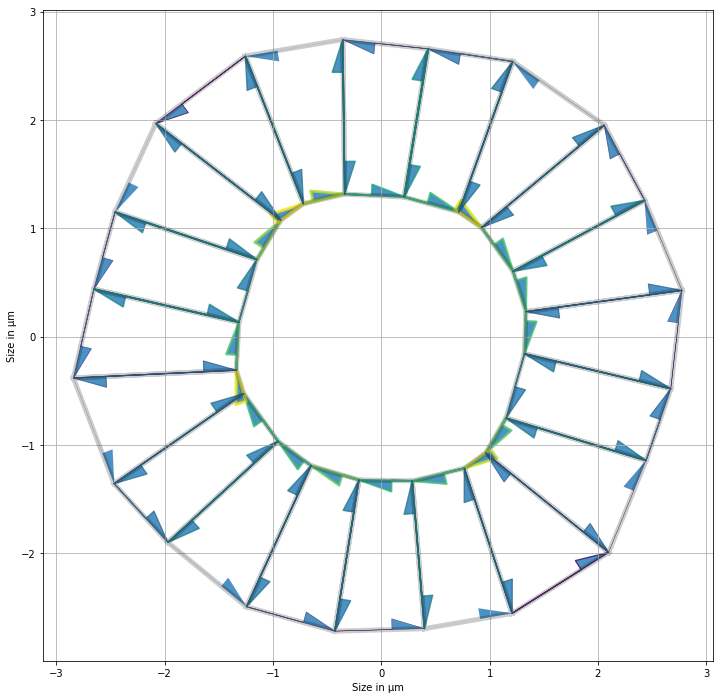

In [16]:
opt_mat_2_cst_organo = to_opt_organo.copy()
opt_mat_2_cst_organo.edge_df.line_tension = prepare_tensions(opt_mat_2_cst_organo, res_2_cst_areas.x[:organo3.Nf*3])
opt_mat_2_cst_organo.face_df.prefered_area = opt_mat_2_cst_organo.face_df.area + res_2_cst_areas.x[3*organo3.Nf:4*organo3.Nf]
opt_mat_2_cst_organo.settings['prefered_lumen_vol'] = opt_mat_2_cst_organo.settings['lumen_volume'] + res_2_cst_areas.x[-1]
Solver.find_energy_min(opt_mat_2_cst_organo, geom, model)
print_tensions(opt_mat_2_cst_organo, organo3)
print('Distance from th organo to exp organo : ' +
      str(np.sum(np.linalg.norm(_distance(organo3, opt_mat_2_cst_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(organo3.edge_df.line_tension[:3*organo3.Nf] -
                                opt_mat_2_cst_organo.edge_df.line_tension[:3*organo3.Nf]))))

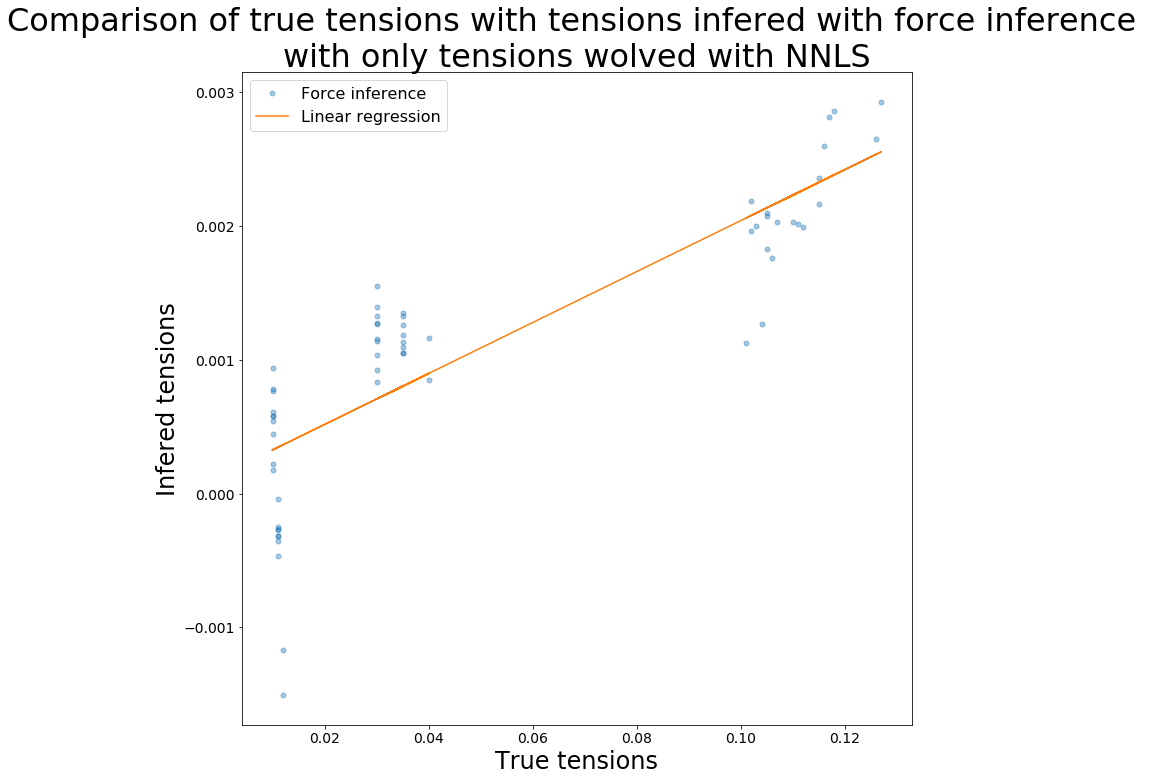

R value : 0.8381143889839199 
Standard error : 0.0004617901283129466


In [17]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  res_2_cst_areas.x[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

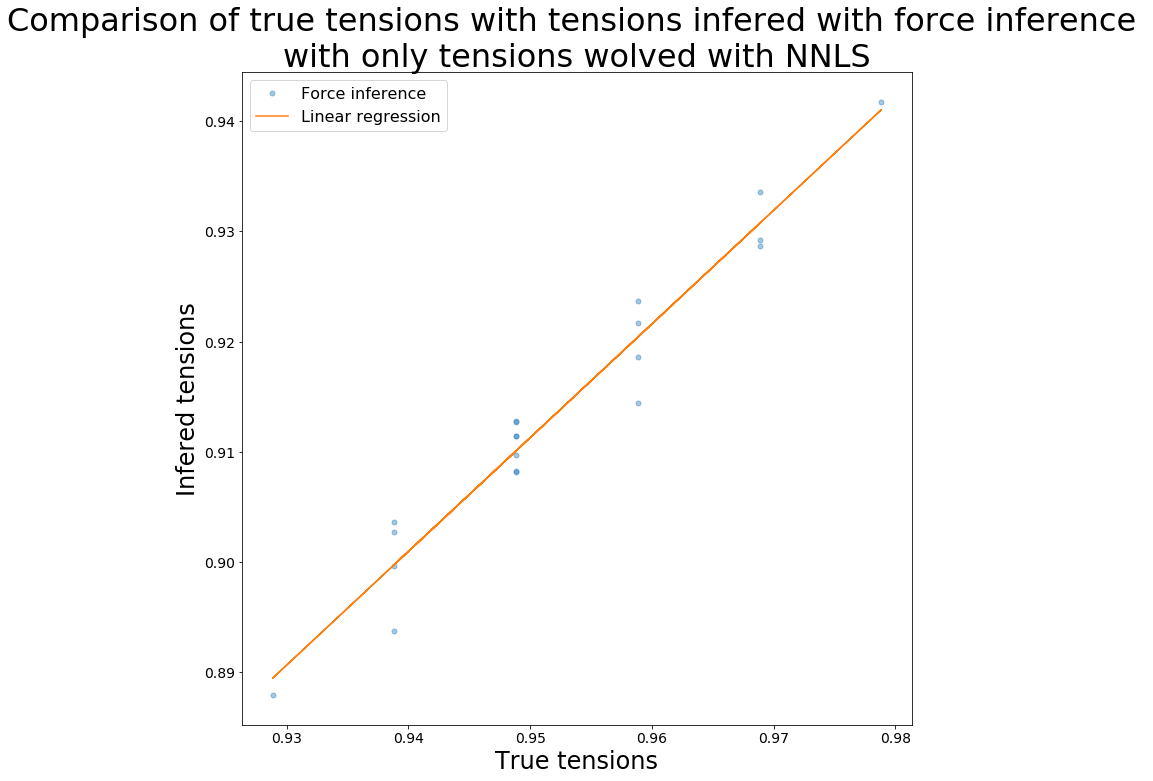

R value : 0.9769734505473286 
Standard error : 0.0013938224810320565


In [18]:
rendering_results(organo3, organo3.face_df.eval('prefered_area'),
                  res_2_cst_areas.x[4*organo3.Nf:-1],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

# half polarized

Reseting datasets values with new specs


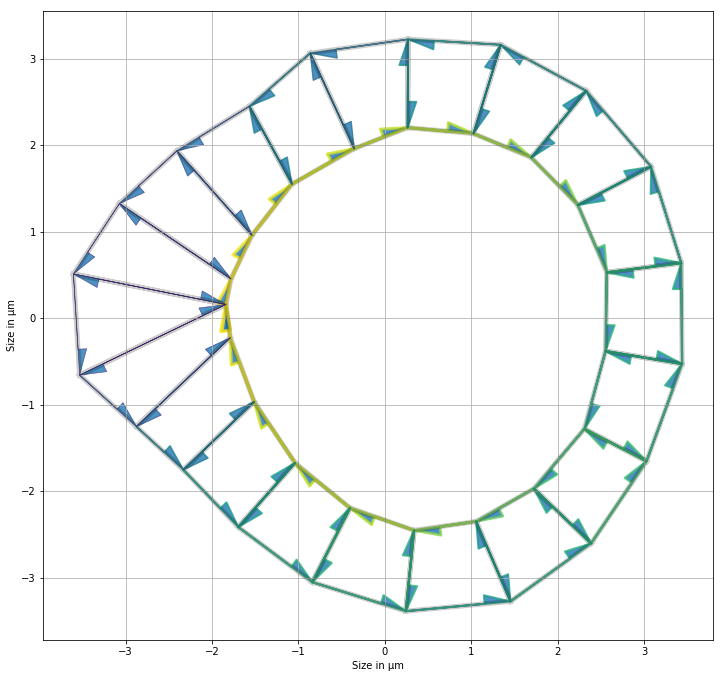

In [19]:
nf, r_in, r_out = (20, 1, 1.5)
seed = 1
organo3 = create_organo(nf, r_in, r_out)

organo3.edge_df.loc[organo3.apical_edges, 'line_tension'] = 3*np.array([
    0.050, 0.055, 0.060, 0.065, 0.070,
    0.072, 0.074, 0.076, 0.078, 0.078,
    0.079, 0.078, 0.076, 0.074, 0.072,
    0.070, 0.068, 0.065, 0.057, 0.052
])

organo3.edge_df.loc[organo3.basal_edges, 'line_tension'] = 3*np.array([
    0.050, 0.055, 0.050, 0.045, 0.050,
    0.050, 0.045, 0.035, 0.020, 0.010,
    0.011, 0.015, 0.020, 0.035, 0.030,
    0.040, 0.040, 0.042, 0.045, 0.050
])

organo3.edge_df.loc[organo3.lateral_edges, 'line_tension'] = 3*np.array([
    0.050, 0.055, 0.050, 0.044, 0.051,
    0.051, 0.046, 0.034, 0.019, 0.009,
    0.010, 0.014, 0.021, 0.036, 0.029,
    0.041, 0.039, 0.043, 0.046, 0.051,
    0.055, 0.050, 0.044, 0.051,
    0.051, 0.046, 0.034, 0.019, 0.009,
    0.010, 0.014, 0.021, 0.036, 0.029,
    0.041, 0.039, 0.043, 0.046, 0.051, 0.050
])

organo3.face_df.loc[:, 'prefered_area'] = np.array([
    0.08, 0.07, 0.08, 0.09, 0.09,
    0.10, 0.09, 0.08, 0.09, 0.09,
    0.10, 0.11, 0.10, 0.11, 0.12,
    0.11, 0.10, 0.09, 0.08, 0.09
]) + organo3.face_df.area

geom.update_all(organo3)
Solver.find_energy_min(organo3, geom, model)
print_tensions(organo3, organo3)

In [20]:
real_data = np.concatenate((organo3.edge_df.line_tension[:3*organo3.Nf],
                            organo3.face_df.prefered_area - organo3.face_df.area,
                            [organo3.settings['lumen_prefered_vol']-
                             organo3.settings['lumen_volume']]))
print(organo3.edge_df.line_tension, '\n',
      organo3.face_df.prefered_area - organo3.face_df.area)

edge
0     0.150
1     0.165
2     0.180
3     0.195
4     0.210
5     0.216
6     0.222
7     0.228
8     0.234
9     0.234
10    0.237
11    0.234
12    0.228
13    0.222
14    0.216
15    0.210
16    0.204
17    0.195
18    0.171
19    0.156
20    0.150
21    0.165
22    0.150
23    0.135
24    0.150
25    0.150
26    0.135
27    0.105
28    0.060
29    0.030
      ...  
50    0.030
51    0.042
52    0.063
53    0.108
54    0.087
55    0.123
56    0.117
57    0.129
58    0.138
59    0.153
60    0.165
61    0.150
62    0.132
63    0.153
64    0.153
65    0.138
66    0.102
67    0.057
68    0.027
69    0.030
70    0.042
71    0.063
72    0.108
73    0.087
74    0.123
75    0.117
76    0.129
77    0.138
78    0.153
79    0.150
Name: line_tension, Length: 80, dtype: float64 
 face
0     0.154936
1     0.167500
2     0.151523
3     0.150463
4     0.166689
5     0.159844
6     0.133828
7     0.090750
8     0.056635
9     0.043170
10    0.044984
11    0.061721
12    0.085269
13    0.114135

In [21]:
params_in_sym_mesh = np.linalg.solve(*get_sim_mat(nf, r_in, r_out))

In [22]:
organo3.get_extra_indices()
non_lateral_edges = np.concatenate((organo3.apical_edges,
                                    organo3.basal_edges))
sym_height = (r_out-r_in)*np.cos(np.pi/organo3.Nf)
polar_coefs = np.ones(organo3.Nf)
for cell in range(organo3.Nf):
    parrallel_edges = (organo3.edge_df.loc[non_lateral_edges, ('srce', 'trgt')]
                       [organo3.edge_df.face == cell]).values
    apical_middle = organo3.vert_df.loc[parrallel_edges[0, :], ('x', 'y')].sum()/2
    basal_middle = organo3.vert_df.loc[parrallel_edges[1, :], ('x', 'y')].sum()/2
    cell_height = np.linalg.norm(apical_middle - basal_middle)
    polar_coefs[cell] = cell_height/sym_height
polar_coefs

/home/fquinton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


array([1.70875628, 1.73061486, 1.9076613 , 1.9072665 , 1.89384035,
       1.96180304, 2.15138194, 2.66374457, 3.37658274, 3.53171516,
       3.33285298, 2.87692293, 2.34665538, 2.26881571, 2.2130006 ,
       2.10060637, 2.06043668, 1.94095997, 1.81827859, 1.76992467])

[0.021868803909342278, 0.021868803909342278, 0.021868803909342278, 0.021868803909342278, 0.021868803909342278, 0.021868803909342278, 0.021868803909342278, 0.021868803909342278, 0.021868803909342278, 0.021868803909342278, 0.021868803909342278, 0.021868803909342278, 0.021868803909342278, 0.021868803909342278, 0.021868803909342278, 0.021868803909342278, 0.021868803909342278, 0.021868803909342278, 0.021868803909342278, 0.021868803909342278]
[0.03736846 0.03784648 0.04171827 0.04170964 0.04141602 0.04290229
 0.04704815 0.05825291 0.07384183 0.07723439 0.07288551 0.06291486
 0.05131855 0.04961629 0.04839568 0.04593775 0.04505929 0.04244647
 0.03976358 0.03870614]
Apical tensions:  [0.         0.         0.         0.         0.         0.
 0.00117584 0.00522223 0.01226113 0.01770853 0.01279    0.00728127
 0.00258003 0.00220676 0.0021286  0.00075181 0.0007675  0.
 0.         0.        ] 
Basal tensions:  [0.         0.         0.         0.         0.         0.00051816
 0.0021819  0.00567087

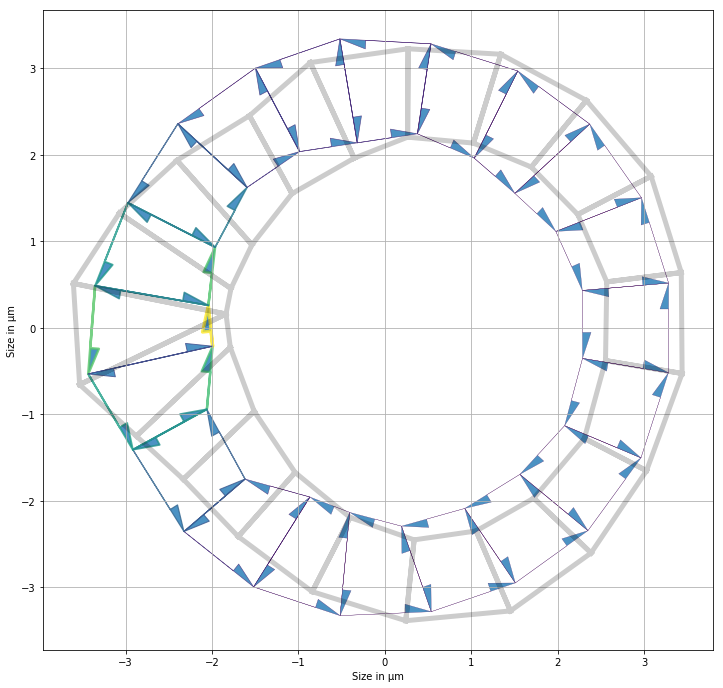

In [23]:
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
avg_cste = [4*((params_in_sym_mesh[1:].sum()+params_in_sym_mesh[-1])/3 /
               (organo3.face_df.area.mean() + params_in_sym_mesh[0])**1.5)]*organo3.Nf
print(avg_cste)
avg_cste = np.multiply(np.array(avg_cste), polar_coefs)
print(avg_cste)
for i in range(organo3.Nf):
    i_cell_line = np.zeros(4*organo3.Nf+1)
    index = np.squeeze(np.argwhere(organo3.edge_df.face.values == i)[:-1])
    i_cell_line[index] = 1
    matrix = np.vstack((matrix, i_cell_line))
constant = np.concatenate((constant, avg_cste))
mat_eq_cst, residuals = nnls(matrix, constant)
organo3_eq_cst = organo3.copy()
organo3_eq_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_eq_cst,
                                                                 mat_eq_cst[:3*organo3.Nf])
organo3_eq_cst.face_df.loc[:, 'prefered_area'] = organo3_eq_cst.face_df.area + mat_eq_cst[3*organo3.Nf:
                                                                                          4*organo3.Nf]
organo3_eq_cst.settings['lumen_prefered_vol'] = organo3_eq_cst.settings['lumen_volume'] + mat_eq_cst[-1]
Solver.find_energy_min(organo3_eq_cst, geom, model)
print_tensions(organo3_eq_cst, organo3)
print('Apical tensions: ', mat_eq_cst[organo3.apical_edges],
      '\nBasal tensions: ', mat_eq_cst[organo3.basal_edges],
      '\nLateral tensions: ', mat_eq_cst[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', mat_eq_cst[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', mat_eq_cst[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-mat_eq_cst),
      '\nNNLS residuals: ', residuals)

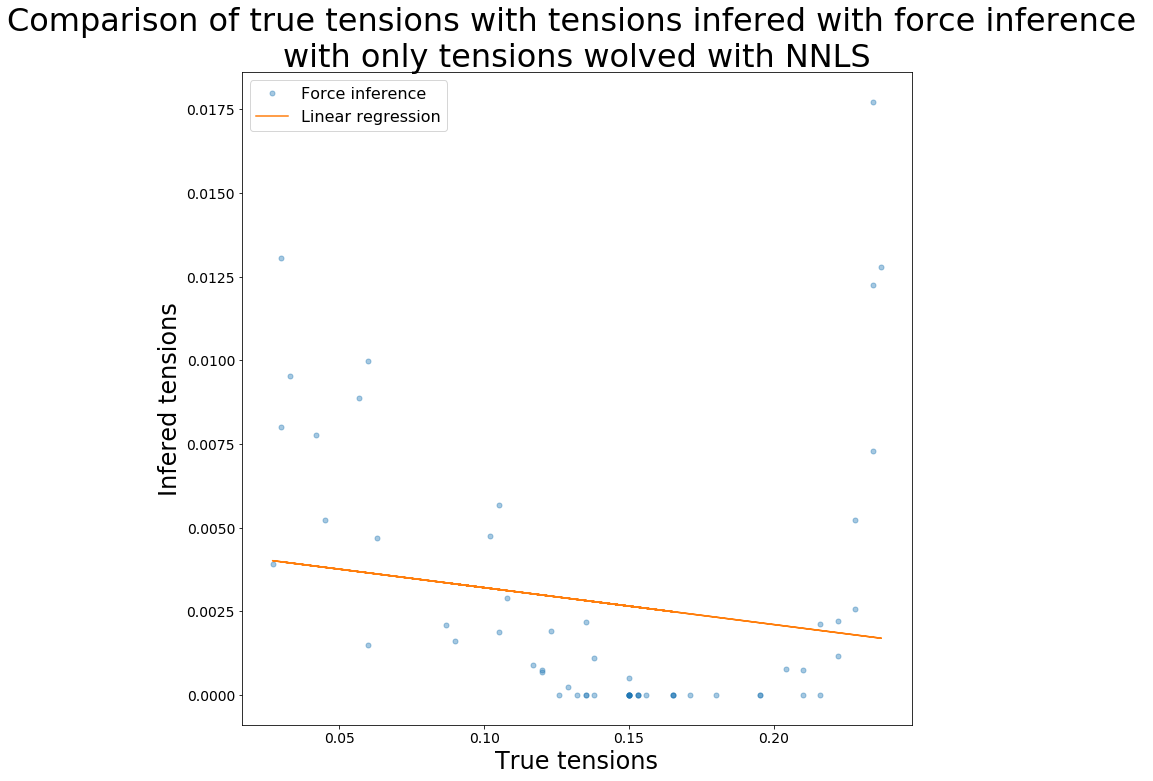

R value : -0.1594370950608449 
Standard error : 0.0034749826834216202


In [24]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  mat_eq_cst[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

In [25]:
iprint_file = "../../assets/dist_at_each_f_ev/11_03_eq_t_per_cell_areas_opt.txt"
to_opt_organo = organo3.copy()
init_point_area_and_tensions_opt = np.concatenate((prepare_tensions(to_opt_organo, mat_eq_cst[:3*organo3.Nf]),
                                                   to_opt_organo.face_df.area + mat_eq_cst[3*organo3.Nf:-1],
                                                   [to_opt_organo.settings['lumen_volume'] + mat_eq_cst[-1]]))
res_2_cst_areas = adjust_parameters(to_opt_organo,
                                    init_point_area_and_tensions_opt,
                                    {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                                    energy_min_opt=energy_opt,
                                    **lm_opt)

{'method': 'lm', 'xtol': 1e-05, 'ftol': 0.001, 'verbose': 1}
I know I do LM
edge line_tension [0.         0.         0.         0.         0.         0.
 0.00117584 0.00522223 0.01226113 0.01770853 0.01279    0.00728127
 0.00258003 0.00220676 0.0021286  0.00075181 0.0007675  0.
 0.         0.         0.         0.         0.         0.
 0.         0.00051816 0.0021819  0.00567087 0.00997687 0.01305551
 0.00953636 0.00522696 0.00149401 0.00189174 0.00160676 0.00073928
 0.00070005 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00110979 0.00475623
 0.00886378 0.0039044  0.00800555 0.00778135 0.00470714 0.00291116
 0.0020799  0.00191163 0.00089188 0.00024889 0.         0.
 0.         0.         0.         0.         0.         0.00110979
 0.00475623 0.00886378 0.0039044  0.00800555 0.00778135 0.00470714
 0.00291116 0.0020799  0.00191163 0.00089188 0.00024889 0.
 0.        ]
face prefered_area [0.89811268 0.87554219 0.90150673 0.9125605  0.8962

edge line_tension [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.49011612e-08 0.00000000e+00 1.17583590e-03 5.22223203e-03
 1.22611331e-02 1.77085331e-02 1.27899958e-02 7.28127037e-03
 2.58002915e-03 2.20675945e-03 2.12860097e-03 7.51808940e-04
 7.67495820e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.18162303e-04 2.18189517e-03 5.67087375e-03
 9.97687419e-03 1.30555108e-02 9.53636380e-03 5.22696253e-03
 1.49401220e-03 1.89173945e-03 1.60675935e-03 7.39281484e-04
 7.00047464e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.10978716e-03 4.75623405e-03
 8.86377841e-03 3.90440032e-03 8.00555162e-03 7.78134537e-03
 4.70713691e-03 2.91116265e-03 2.07990283e-03 1.91163097e-03
 8.91877157e-04 2.48887023e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

edge line_tension [0.         0.         0.         0.         0.         0.
 0.00117584 0.00522223 0.01226113 0.01770853 0.01279    0.00728127
 0.00258003 0.00220676 0.0021286  0.00075181 0.0007675  0.
 0.         0.         0.         0.         0.         0.
 0.         0.00051816 0.0021819  0.00567087 0.00997687 0.01305551
 0.00953636 0.00522696 0.00149401 0.00189174 0.00160676 0.00073928
 0.00070005 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00110979 0.00475623
 0.00886378 0.0039044  0.00800555 0.00778135 0.00470714 0.00291116
 0.0020799  0.00191163 0.00089188 0.00024889 0.         0.
 0.         0.         0.         0.         0.         0.00110979
 0.00475623 0.00886378 0.0039044  0.00800555 0.00778135 0.00470714
 0.00291116 0.0020799  0.00191163 0.00089188 0.00024889 0.
 0.        ]
face prefered_area [0.89811268 0.87554219 0.90150673 0.9125605  0.89625841 0.91331114
 0.93160655 0.96944604 1.01774638 1.0360443  1.04012133 1.02

edge line_tension [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.17583590e-03 5.22223203e-03
 1.22611331e-02 1.77085331e-02 1.27899958e-02 7.28127037e-03
 2.58002915e-03 2.20675945e-03 2.12860097e-03 7.51808940e-04
 7.67495820e-04 0.00000000e+00 0.00000000e+00 1.49011612e-08
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.18162303e-04 2.18189517e-03 5.67087375e-03
 9.97687419e-03 1.30555108e-02 9.53636380e-03 5.22696253e-03
 1.49401220e-03 1.89173945e-03 1.60675935e-03 7.39281484e-04
 7.00047464e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.10978716e-03 4.75623405e-03
 8.86377841e-03 3.90440032e-03 8.00555162e-03 7.78134537e-03
 4.70713691e-03 2.91116265e-03 2.07990283e-03 1.91163097e-03
 8.91877157e-04 2.48887023e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

edge line_tension [0.         0.         0.         0.         0.         0.
 0.00117584 0.00522223 0.01226113 0.01770853 0.01279    0.00728127
 0.00258003 0.00220676 0.0021286  0.00075181 0.0007675  0.
 0.         0.         0.         0.         0.         0.
 0.         0.00051816 0.0021819  0.00567087 0.00997687 0.01305551
 0.00953636 0.00522696 0.00149401 0.00189174 0.00160676 0.00073928
 0.00070005 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00110979 0.00475623
 0.00886378 0.0039044  0.00800555 0.00778135 0.00470714 0.00291116
 0.0020799  0.00191163 0.00089188 0.00024889 0.         0.
 0.         0.         0.         0.         0.         0.00110979
 0.00475623 0.00886378 0.0039044  0.00800555 0.00778135 0.00470714
 0.00291116 0.0020799  0.00191163 0.00089188 0.00024889 0.
 0.        ]
face prefered_area [0.89811268 0.87554219 0.90150673 0.9125605  0.89625841 0.91331114
 0.93160655 0.96944604 1.01774638 1.0360443  1.04012133 1.02

edge line_tension [0.         0.         0.         0.         0.         0.
 0.00117584 0.00522223 0.01226113 0.01770853 0.01279    0.00728127
 0.00258003 0.00220676 0.0021286  0.00075181 0.0007675  0.
 0.         0.         0.         0.         0.         0.
 0.         0.00051816 0.0021819  0.00567087 0.00997687 0.01305551
 0.00953636 0.00522696 0.00149401 0.00189174 0.00160676 0.00073928
 0.00070005 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00110979 0.00475623
 0.00886378 0.0039044  0.00800555 0.00778135 0.00470714 0.00291116
 0.0020799  0.00191163 0.00089188 0.00024889 0.         0.
 0.         0.         0.         0.         0.         0.00110979
 0.00475623 0.00886378 0.0039044  0.00800555 0.00778135 0.00470714
 0.00291116 0.0020799  0.00191163 0.00089188 0.00024889 0.
 0.        ]
face prefered_area [0.89811268 0.87554219 0.90150673 0.9125605  0.89625841 0.91331114
 0.93160655 0.96944604 1.01774638 1.0360443  1.04012133 1.02

edge line_tension [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.17583590e-03 5.22223203e-03
 1.22611331e-02 1.77085331e-02 1.27899958e-02 7.28127037e-03
 2.58002915e-03 2.20675945e-03 2.12860097e-03 7.51808940e-04
 7.67495820e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.18162303e-04 2.18189517e-03 5.67087375e-03
 9.97687419e-03 1.30555108e-02 9.53636380e-03 5.22696253e-03
 1.49401220e-03 1.89173945e-03 1.60675935e-03 7.39281484e-04
 7.00047464e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.49011612e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.10978716e-03 4.75623405e-03
 8.86377841e-03 3.90440032e-03 8.00555162e-03 7.78134537e-03
 4.70713691e-03 2.91116265e-03 2.07990283e-03 1.91163097e-03
 8.91877157e-04 2.48887023e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

edge line_tension [0.         0.         0.         0.         0.         0.
 0.00117584 0.00522223 0.01226113 0.01770853 0.01279    0.00728127
 0.00258003 0.00220676 0.0021286  0.00075181 0.0007675  0.
 0.         0.         0.         0.         0.         0.
 0.         0.00051816 0.0021819  0.00567087 0.00997687 0.01305551
 0.00953636 0.00522696 0.00149401 0.00189174 0.00160676 0.00073928
 0.00070005 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00110979 0.00475623
 0.00886378 0.0039044  0.00800555 0.00778135 0.00470714 0.00291116
 0.0020799  0.00191163 0.00089188 0.00024889 0.         0.
 0.         0.         0.         0.         0.         0.00110979
 0.00475623 0.00886378 0.0039044  0.00800555 0.00778135 0.00470714
 0.00291116 0.0020799  0.00191163 0.00089188 0.00024889 0.
 0.        ]
face prefered_area [0.89811268 0.87554219 0.90150673 0.9125605  0.89625841 0.91331114
 0.93160655 0.96944604 1.01774638 1.0360443  1.04012133 1.02

edge line_tension [0.         0.         0.         0.         0.         0.
 0.00117584 0.00522223 0.01226113 0.01770853 0.01279    0.00728127
 0.00258003 0.00220676 0.0021286  0.00075181 0.0007675  0.
 0.         0.         0.         0.         0.         0.
 0.         0.00051816 0.0021819  0.00567087 0.00997687 0.01305551
 0.00953636 0.00522696 0.00149401 0.00189174 0.00160676 0.00073928
 0.00070005 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00110979 0.00475623
 0.00886378 0.0039044  0.00800555 0.00778135 0.00470714 0.00291116
 0.0020799  0.00191163 0.00089188 0.00024889 0.         0.
 0.         0.         0.         0.         0.         0.00110979
 0.00475623 0.00886378 0.0039044  0.00800555 0.00778135 0.00470714
 0.00291116 0.0020799  0.00191163 0.00089188 0.00024889 0.
 0.        ]
face prefered_area [0.89811268 0.87554219 0.90150673 0.9125605  0.89625841 0.91331114
 0.93160655 0.96944604 1.01774638 1.0360443  1.04012133 1.02

edge line_tension [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.17583590e-03 5.22223203e-03
 1.22611331e-02 1.77085331e-02 1.27899958e-02 7.28127037e-03
 2.58002915e-03 2.20675945e-03 2.12860097e-03 7.51808940e-04
 7.67495820e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.18162303e-04 2.18189517e-03 5.67087375e-03
 9.97687419e-03 1.30555108e-02 9.53636380e-03 5.22696253e-03
 1.49401220e-03 1.89173945e-03 1.60675935e-03 7.39281484e-04
 7.00047464e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.10978716e-03 4.75623405e-03
 8.86377841e-03 3.90440032e-03 8.00555162e-03 7.78134537e-03
 4.70713691e-03 2.91116265e-03 2.07990283e-03 1.91163097e-03
 8.91877157e-04 2.48887023e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.49011612e-08 0.00000000e+00 0.00000000e+00
 0.000

edge line_tension [0.         0.         0.         0.         0.         0.
 0.00117584 0.00522223 0.01226113 0.01770853 0.01279    0.00728127
 0.00258003 0.00220676 0.0021286  0.00075181 0.0007675  0.
 0.         0.         0.         0.         0.         0.
 0.         0.00051816 0.0021819  0.00567087 0.00997687 0.01305551
 0.00953636 0.00522696 0.00149401 0.00189174 0.00160676 0.00073928
 0.00070005 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00110979 0.00475623
 0.00886378 0.0039044  0.00800555 0.00778135 0.00470714 0.00291116
 0.0020799  0.00191163 0.00089188 0.00024889 0.         0.
 0.         0.         0.         0.         0.         0.00110979
 0.00475623 0.00886378 0.0039044  0.00800555 0.00778135 0.00470714
 0.00291116 0.0020799  0.00191163 0.00089188 0.00024889 0.
 0.        ]
face prefered_area [0.89811268 0.87554219 0.90150673 0.9125605  0.89625841 0.91331114
 0.93160655 0.96944604 1.01774638 1.0360443  1.04012133 1.02

edge line_tension [0.         0.         0.         0.         0.         0.
 0.00117584 0.00522223 0.01226113 0.01770853 0.01279    0.00728127
 0.00258003 0.00220676 0.0021286  0.00075181 0.0007675  0.
 0.         0.         0.         0.         0.         0.
 0.         0.00051816 0.0021819  0.00567087 0.00997687 0.01305551
 0.00953636 0.00522696 0.00149401 0.00189174 0.00160676 0.00073928
 0.00070005 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00110979 0.00475623
 0.00886378 0.0039044  0.00800555 0.00778135 0.00470714 0.00291116
 0.0020799  0.00191163 0.00089188 0.00024889 0.         0.
 0.         0.         0.         0.         0.         0.00110979
 0.00475623 0.00886378 0.0039044  0.00800555 0.00778135 0.00470714
 0.00291116 0.0020799  0.00191163 0.00089188 0.00024889 0.
 0.        ]
face prefered_area [0.89811268 0.87554219 0.90150673 0.9125605  0.89625841 0.91331114
 0.93160655 0.96944604 1.01774638 1.0360443  1.04012133 1.02

edge line_tension [0.         0.         0.         0.         0.         0.
 0.00117584 0.00522223 0.01226113 0.01770853 0.01279    0.00728127
 0.00258003 0.00220676 0.0021286  0.00075181 0.0007675  0.
 0.         0.         0.         0.         0.         0.
 0.         0.00051816 0.0021819  0.00567087 0.00997687 0.01305551
 0.00953636 0.00522696 0.00149401 0.00189174 0.00160676 0.00073928
 0.00070005 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00110979 0.00475623
 0.00886378 0.0039044  0.00800555 0.00778135 0.00470714 0.00291116
 0.0020799  0.00191163 0.00089188 0.00024889 0.         0.
 0.         0.         0.         0.         0.         0.00110979
 0.00475623 0.00886378 0.0039044  0.00800555 0.00778135 0.00470714
 0.00291116 0.0020799  0.00191163 0.00089188 0.00024889 0.
 0.        ]
face prefered_area [0.89811268 0.87554219 0.90150673 0.91256052 0.89625841 0.91331114
 0.93160655 0.96944604 1.01774638 1.0360443  1.04012133 1.02

edge line_tension [0.         0.         0.         0.         0.         0.
 0.00117584 0.00522223 0.01226113 0.01770853 0.01279    0.00728127
 0.00258003 0.00220676 0.0021286  0.00075181 0.0007675  0.
 0.         0.         0.         0.         0.         0.
 0.         0.00051816 0.0021819  0.00567087 0.00997687 0.01305551
 0.00953636 0.00522696 0.00149401 0.00189174 0.00160676 0.00073928
 0.00070005 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00110979 0.00475623
 0.00886378 0.0039044  0.00800555 0.00778135 0.00470714 0.00291116
 0.0020799  0.00191163 0.00089188 0.00024889 0.         0.
 0.         0.         0.         0.         0.         0.00110979
 0.00475623 0.00886378 0.0039044  0.00800555 0.00778135 0.00470714
 0.00291116 0.0020799  0.00191163 0.00089188 0.00024889 0.
 0.        ]
face prefered_area [0.89811268 0.87554219 0.90150673 0.9125605  0.89625841 0.91331114
 0.93160655 0.96944604 1.01774638 1.0360443  1.04012133 1.02

edge line_tension [0.         0.         0.         0.         0.         0.
 0.00117584 0.00522223 0.01226113 0.01770853 0.01279    0.00728127
 0.00258003 0.00220676 0.0021286  0.00075181 0.0007675  0.
 0.         0.         0.         0.         0.         0.
 0.         0.00051816 0.0021819  0.00567087 0.00997687 0.01305551
 0.00953636 0.00522696 0.00149401 0.00189174 0.00160676 0.00073928
 0.00070005 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00110979 0.00475623
 0.00886378 0.0039044  0.00800555 0.00778135 0.00470714 0.00291116
 0.0020799  0.00191163 0.00089188 0.00024889 0.         0.
 0.         0.         0.         0.         0.         0.00110979
 0.00475623 0.00886378 0.0039044  0.00800555 0.00778135 0.00470714
 0.00291116 0.0020799  0.00191163 0.00089188 0.00024889 0.
 0.        ]
face prefered_area [0.89811268 0.87554219 0.90150673 0.9125605  0.89625841 0.91331114
 0.93160655 0.96944604 1.01774638 1.0360443  1.04012133 1.02

edge line_tension [ 1.04274726e-05  8.95137166e-06 -1.54806622e-04 -8.96099414e-05
 -9.10889768e-07 -1.55077761e-04  1.01874541e-03  5.47858179e-03
  1.25527763e-02  1.76857274e-02  1.32654605e-02  7.46752194e-03
  2.39547336e-03  1.98963245e-03  2.14045030e-03  5.94518354e-04
  6.67446334e-04 -4.13771779e-05  5.06010876e-06  4.23675354e-06
  1.18953705e-05 -3.07947661e-05  1.51720705e-04  7.41293035e-05
 -1.66626319e-04  4.33711399e-04  2.20702697e-03  5.69536518e-03
  1.01104085e-02  1.28271358e-02  9.67021319e-03  5.09135585e-03
  1.48423963e-03  1.93834975e-03  1.42003633e-03  7.48493636e-04
  6.49166375e-04 -2.23729437e-06 -3.07506210e-06  2.52786487e-05
  3.37311567e-05  5.94907971e-05  7.03850322e-05  5.69483817e-05
  1.00314423e-04 -6.49374191e-06  1.23383360e-03  4.45623477e-03
  8.10330290e-03  4.09835834e-03  6.61831257e-03  7.24488966e-03
  4.27989125e-03  3.07312787e-03  2.22498134e-03  1.99751851e-03
  1.15722893e-03  4.14362771e-04  1.24497313e-04  6.74892585e-05
  0.000

edge line_tension [ 1.04274726e-05  8.95137166e-06 -1.54806622e-04 -8.96099428e-05
 -9.10889768e-07 -1.55077761e-04  1.01874541e-03  5.47858179e-03
  1.25527763e-02  1.76857276e-02  1.32654605e-02  7.46752194e-03
  2.39547336e-03  1.98963245e-03  2.14045030e-03  5.94518354e-04
  6.67446334e-04 -4.13771779e-05  5.06010876e-06  4.23675354e-06
  1.18953705e-05 -3.07947661e-05  1.51720705e-04  7.41293035e-05
 -1.66626319e-04  4.33711399e-04  2.20702697e-03  5.69536518e-03
  1.01104085e-02  1.28271358e-02  9.67021319e-03  5.09135585e-03
  1.48423963e-03  1.93834975e-03  1.42003633e-03  7.48493636e-04
  6.49166375e-04 -2.23729437e-06 -3.07506210e-06  2.52786487e-05
  3.37311567e-05  5.94907971e-05  7.03850322e-05  5.69483817e-05
  1.00314423e-04 -6.49374191e-06  1.23383360e-03  4.45623477e-03
  8.10330290e-03  4.09835834e-03  6.61831257e-03  7.24488966e-03
  4.27989125e-03  3.07312787e-03  2.22498134e-03  1.99751851e-03
  1.15722893e-03  4.14362771e-04  1.24497313e-04  6.74892585e-05
  0.000

edge line_tension [ 1.04274726e-05  8.95137166e-06 -1.54806622e-04 -8.96099428e-05
 -9.10889768e-07 -1.55077761e-04  1.01874541e-03  5.47858179e-03
  1.25527763e-02  1.76857274e-02  1.32654605e-02  7.46752194e-03
  2.39547336e-03  1.98963245e-03  2.14045030e-03  5.94518363e-04
  6.67446334e-04 -4.13771779e-05  5.06010876e-06  4.23675354e-06
  1.18953705e-05 -3.07947661e-05  1.51720705e-04  7.41293035e-05
 -1.66626319e-04  4.33711399e-04  2.20702697e-03  5.69536518e-03
  1.01104085e-02  1.28271358e-02  9.67021319e-03  5.09135585e-03
  1.48423963e-03  1.93834975e-03  1.42003633e-03  7.48493636e-04
  6.49166375e-04 -2.23729437e-06 -3.07506210e-06  2.52786487e-05
  3.37311567e-05  5.94907971e-05  7.03850322e-05  5.69483817e-05
  1.00314423e-04 -6.49374191e-06  1.23383360e-03  4.45623477e-03
  8.10330290e-03  4.09835834e-03  6.61831257e-03  7.24488966e-03
  4.27989125e-03  3.07312787e-03  2.22498134e-03  1.99751851e-03
  1.15722893e-03  4.14362771e-04  1.24497313e-04  6.74892585e-05
  0.000

edge line_tension [ 1.04274726e-05  8.95137166e-06 -1.54806622e-04 -8.96099428e-05
 -9.10889768e-07 -1.55077761e-04  1.01874541e-03  5.47858179e-03
  1.25527763e-02  1.76857274e-02  1.32654605e-02  7.46752194e-03
  2.39547336e-03  1.98963245e-03  2.14045030e-03  5.94518354e-04
  6.67446334e-04 -4.13771779e-05  5.06010876e-06  4.23675354e-06
  1.18953705e-05 -3.07947657e-05  1.51720705e-04  7.41293035e-05
 -1.66626319e-04  4.33711399e-04  2.20702697e-03  5.69536518e-03
  1.01104085e-02  1.28271358e-02  9.67021319e-03  5.09135585e-03
  1.48423963e-03  1.93834975e-03  1.42003633e-03  7.48493636e-04
  6.49166375e-04 -2.23729437e-06 -3.07506210e-06  2.52786487e-05
  3.37311567e-05  5.94907971e-05  7.03850322e-05  5.69483817e-05
  1.00314423e-04 -6.49374191e-06  1.23383360e-03  4.45623477e-03
  8.10330290e-03  4.09835834e-03  6.61831257e-03  7.24488966e-03
  4.27989125e-03  3.07312787e-03  2.22498134e-03  1.99751851e-03
  1.15722893e-03  4.14362771e-04  1.24497313e-04  6.74892585e-05
  0.000

edge line_tension [ 1.04274726e-05  8.95137166e-06 -1.54806622e-04 -8.96099428e-05
 -9.10889768e-07 -1.55077761e-04  1.01874541e-03  5.47858179e-03
  1.25527763e-02  1.76857274e-02  1.32654605e-02  7.46752194e-03
  2.39547336e-03  1.98963245e-03  2.14045030e-03  5.94518354e-04
  6.67446334e-04 -4.13771779e-05  5.06010876e-06  4.23675354e-06
  1.18953705e-05 -3.07947661e-05  1.51720705e-04  7.41293035e-05
 -1.66626319e-04  4.33711399e-04  2.20702697e-03  5.69536527e-03
  1.01104085e-02  1.28271358e-02  9.67021319e-03  5.09135585e-03
  1.48423963e-03  1.93834975e-03  1.42003633e-03  7.48493636e-04
  6.49166375e-04 -2.23729437e-06 -3.07506210e-06  2.52786487e-05
  3.37311567e-05  5.94907971e-05  7.03850322e-05  5.69483817e-05
  1.00314423e-04 -6.49374191e-06  1.23383360e-03  4.45623477e-03
  8.10330290e-03  4.09835834e-03  6.61831257e-03  7.24488966e-03
  4.27989125e-03  3.07312787e-03  2.22498134e-03  1.99751851e-03
  1.15722893e-03  4.14362771e-04  1.24497313e-04  6.74892585e-05
  0.000

edge line_tension [ 1.04274726e-05  8.95137166e-06 -1.54806622e-04 -8.96099428e-05
 -9.10889768e-07 -1.55077761e-04  1.01874541e-03  5.47858179e-03
  1.25527763e-02  1.76857274e-02  1.32654605e-02  7.46752194e-03
  2.39547336e-03  1.98963245e-03  2.14045030e-03  5.94518354e-04
  6.67446334e-04 -4.13771779e-05  5.06010876e-06  4.23675354e-06
  1.18953705e-05 -3.07947661e-05  1.51720705e-04  7.41293035e-05
 -1.66626319e-04  4.33711399e-04  2.20702697e-03  5.69536518e-03
  1.01104085e-02  1.28271358e-02  9.67021319e-03  5.09135585e-03
  1.48423963e-03  1.93834978e-03  1.42003633e-03  7.48493636e-04
  6.49166375e-04 -2.23729437e-06 -3.07506210e-06  2.52786487e-05
  3.37311567e-05  5.94907971e-05  7.03850322e-05  5.69483817e-05
  1.00314423e-04 -6.49374191e-06  1.23383360e-03  4.45623477e-03
  8.10330290e-03  4.09835834e-03  6.61831257e-03  7.24488966e-03
  4.27989125e-03  3.07312787e-03  2.22498134e-03  1.99751851e-03
  1.15722893e-03  4.14362771e-04  1.24497313e-04  6.74892585e-05
  0.000

edge line_tension [ 1.04274726e-05  8.95137166e-06 -1.54806622e-04 -8.96099428e-05
 -9.10889768e-07 -1.55077761e-04  1.01874541e-03  5.47858179e-03
  1.25527763e-02  1.76857274e-02  1.32654605e-02  7.46752194e-03
  2.39547336e-03  1.98963245e-03  2.14045030e-03  5.94518354e-04
  6.67446334e-04 -4.13771779e-05  5.06010876e-06  4.23675354e-06
  1.18953705e-05 -3.07947661e-05  1.51720705e-04  7.41293035e-05
 -1.66626319e-04  4.33711399e-04  2.20702697e-03  5.69536518e-03
  1.01104085e-02  1.28271358e-02  9.67021319e-03  5.09135585e-03
  1.48423963e-03  1.93834975e-03  1.42003633e-03  7.48493636e-04
  6.49166375e-04 -2.23729437e-06 -3.07506210e-06  2.52786490e-05
  3.37311567e-05  5.94907971e-05  7.03850322e-05  5.69483817e-05
  1.00314423e-04 -6.49374191e-06  1.23383360e-03  4.45623477e-03
  8.10330290e-03  4.09835834e-03  6.61831257e-03  7.24488966e-03
  4.27989125e-03  3.07312787e-03  2.22498134e-03  1.99751851e-03
  1.15722893e-03  4.14362771e-04  1.24497313e-04  6.74892585e-05
  0.000

edge line_tension [ 1.04274726e-05  8.95137166e-06 -1.54806622e-04 -8.96099428e-05
 -9.10889768e-07 -1.55077761e-04  1.01874541e-03  5.47858179e-03
  1.25527763e-02  1.76857274e-02  1.32654605e-02  7.46752194e-03
  2.39547336e-03  1.98963245e-03  2.14045030e-03  5.94518354e-04
  6.67446334e-04 -4.13771779e-05  5.06010876e-06  4.23675354e-06
  1.18953705e-05 -3.07947661e-05  1.51720705e-04  7.41293035e-05
 -1.66626319e-04  4.33711399e-04  2.20702697e-03  5.69536518e-03
  1.01104085e-02  1.28271358e-02  9.67021319e-03  5.09135585e-03
  1.48423963e-03  1.93834975e-03  1.42003633e-03  7.48493636e-04
  6.49166375e-04 -2.23729437e-06 -3.07506210e-06  2.52786487e-05
  3.37311567e-05  5.94907971e-05  7.03850322e-05  5.69483817e-05
  1.00314423e-04 -6.49374181e-06  1.23383360e-03  4.45623477e-03
  8.10330290e-03  4.09835834e-03  6.61831257e-03  7.24488966e-03
  4.27989125e-03  3.07312787e-03  2.22498134e-03  1.99751851e-03
  1.15722893e-03  4.14362771e-04  1.24497313e-04  6.74892585e-05
  0.000

edge line_tension [ 1.04274726e-05  8.95137166e-06 -1.54806622e-04 -8.96099428e-05
 -9.10889768e-07 -1.55077761e-04  1.01874541e-03  5.47858179e-03
  1.25527763e-02  1.76857274e-02  1.32654605e-02  7.46752194e-03
  2.39547336e-03  1.98963245e-03  2.14045030e-03  5.94518354e-04
  6.67446334e-04 -4.13771779e-05  5.06010876e-06  4.23675354e-06
  1.18953705e-05 -3.07947661e-05  1.51720705e-04  7.41293035e-05
 -1.66626319e-04  4.33711399e-04  2.20702697e-03  5.69536518e-03
  1.01104085e-02  1.28271358e-02  9.67021319e-03  5.09135585e-03
  1.48423963e-03  1.93834975e-03  1.42003633e-03  7.48493636e-04
  6.49166375e-04 -2.23729437e-06 -3.07506210e-06  2.52786487e-05
  3.37311567e-05  5.94907971e-05  7.03850322e-05  5.69483817e-05
  1.00314423e-04 -6.49374191e-06  1.23383360e-03  4.45623477e-03
  8.10330290e-03  4.09835834e-03  6.61831257e-03  7.24488977e-03
  4.27989125e-03  3.07312787e-03  2.22498134e-03  1.99751851e-03
  1.15722893e-03  4.14362771e-04  1.24497313e-04  6.74892585e-05
  0.000

edge line_tension [ 1.04274726e-05  8.95137166e-06 -1.54806622e-04 -8.96099428e-05
 -9.10889768e-07 -1.55077761e-04  1.01874541e-03  5.47858179e-03
  1.25527763e-02  1.76857274e-02  1.32654605e-02  7.46752194e-03
  2.39547336e-03  1.98963245e-03  2.14045030e-03  5.94518354e-04
  6.67446334e-04 -4.13771779e-05  5.06010876e-06  4.23675354e-06
  1.18953705e-05 -3.07947661e-05  1.51720705e-04  7.41293035e-05
 -1.66626319e-04  4.33711399e-04  2.20702697e-03  5.69536518e-03
  1.01104085e-02  1.28271358e-02  9.67021319e-03  5.09135585e-03
  1.48423963e-03  1.93834975e-03  1.42003633e-03  7.48493636e-04
  6.49166375e-04 -2.23729437e-06 -3.07506210e-06  2.52786487e-05
  3.37311567e-05  5.94907971e-05  7.03850322e-05  5.69483817e-05
  1.00314423e-04 -6.49374191e-06  1.23383360e-03  4.45623477e-03
  8.10330290e-03  4.09835834e-03  6.61831257e-03  7.24488966e-03
  4.27989125e-03  3.07312787e-03  2.22498134e-03  1.99751851e-03
  1.15722893e-03  4.14362777e-04  1.24497313e-04  6.74892585e-05
  0.000

edge line_tension [ 1.04274726e-05  8.95137166e-06 -1.54806622e-04 -8.96099428e-05
 -9.10889768e-07 -1.55077761e-04  1.01874541e-03  5.47858179e-03
  1.25527763e-02  1.76857274e-02  1.32654605e-02  7.46752194e-03
  2.39547336e-03  1.98963245e-03  2.14045030e-03  5.94518354e-04
  6.67446334e-04 -4.13771779e-05  5.06010876e-06  4.23675354e-06
  1.18953705e-05 -3.07947661e-05  1.51720705e-04  7.41293035e-05
 -1.66626319e-04  4.33711399e-04  2.20702697e-03  5.69536518e-03
  1.01104085e-02  1.28271358e-02  9.67021319e-03  5.09135585e-03
  1.48423963e-03  1.93834975e-03  1.42003633e-03  7.48493636e-04
  6.49166375e-04 -2.23729437e-06 -3.07506210e-06  2.52786487e-05
  3.37311567e-05  5.94907971e-05  7.03850322e-05  5.69483817e-05
  1.00314423e-04 -6.49374191e-06  1.23383360e-03  4.45623477e-03
  8.10330290e-03  4.09835834e-03  6.61831257e-03  7.24488966e-03
  4.27989125e-03  3.07312787e-03  2.22498134e-03  1.99751851e-03
  1.15722893e-03  4.14362771e-04  1.24497313e-04  6.74892585e-05
  0.000

edge line_tension [ 1.04274726e-05  8.95137166e-06 -1.54806622e-04 -8.96099428e-05
 -9.10889768e-07 -1.55077761e-04  1.01874541e-03  5.47858179e-03
  1.25527763e-02  1.76857274e-02  1.32654605e-02  7.46752194e-03
  2.39547336e-03  1.98963245e-03  2.14045030e-03  5.94518354e-04
  6.67446334e-04 -4.13771779e-05  5.06010876e-06  4.23675354e-06
  1.18953705e-05 -3.07947661e-05  1.51720705e-04  7.41293035e-05
 -1.66626319e-04  4.33711399e-04  2.20702697e-03  5.69536518e-03
  1.01104085e-02  1.28271358e-02  9.67021319e-03  5.09135585e-03
  1.48423963e-03  1.93834975e-03  1.42003633e-03  7.48493636e-04
  6.49166375e-04 -2.23729437e-06 -3.07506210e-06  2.52786487e-05
  3.37311567e-05  5.94907971e-05  7.03850322e-05  5.69483817e-05
  1.00314423e-04 -6.49374191e-06  1.23383360e-03  4.45623477e-03
  8.10330290e-03  4.09835834e-03  6.61831257e-03  7.24488966e-03
  4.27989125e-03  3.07312787e-03  2.22498134e-03  1.99751851e-03
  1.15722893e-03  4.14362771e-04  1.24497313e-04  6.74892585e-05
  0.000

edge line_tension [ 1.04274726e-05  8.95137166e-06 -1.54806622e-04 -8.96099428e-05
 -9.10889768e-07 -1.55077761e-04  1.01874541e-03  5.47858179e-03
  1.25527763e-02  1.76857274e-02  1.32654605e-02  7.46752194e-03
  2.39547336e-03  1.98963245e-03  2.14045030e-03  5.94518354e-04
  6.67446334e-04 -4.13771779e-05  5.06010876e-06  4.23675354e-06
  1.18953705e-05 -3.07947661e-05  1.51720705e-04  7.41293035e-05
 -1.66626319e-04  4.33711399e-04  2.20702697e-03  5.69536518e-03
  1.01104085e-02  1.28271358e-02  9.67021319e-03  5.09135585e-03
  1.48423963e-03  1.93834975e-03  1.42003633e-03  7.48493636e-04
  6.49166375e-04 -2.23729437e-06 -3.07506210e-06  2.52786487e-05
  3.37311567e-05  5.94907971e-05  7.03850322e-05  5.69483817e-05
  1.00314423e-04 -6.49374191e-06  1.23383360e-03  4.45623477e-03
  8.10330290e-03  4.09835834e-03  6.61831257e-03  7.24488966e-03
  4.27989125e-03  3.07312787e-03  2.22498134e-03  1.99751851e-03
  1.15722893e-03  4.14362771e-04  1.24497313e-04  6.74892585e-05
  0.000

edge line_tension [ 1.04274726e-05  8.95137166e-06 -1.54806622e-04 -8.96099428e-05
 -9.10889768e-07 -1.55077761e-04  1.01874541e-03  5.47858179e-03
  1.25527763e-02  1.76857274e-02  1.32654605e-02  7.46752194e-03
  2.39547336e-03  1.98963245e-03  2.14045030e-03  5.94518354e-04
  6.67446334e-04 -4.13771779e-05  5.06010876e-06  4.23675354e-06
  1.18953705e-05 -3.07947661e-05  1.51720705e-04  7.41293035e-05
 -1.66626319e-04  4.33711399e-04  2.20702697e-03  5.69536518e-03
  1.01104085e-02  1.28271358e-02  9.67021319e-03  5.09135585e-03
  1.48423963e-03  1.93834975e-03  1.42003633e-03  7.48493636e-04
  6.49166375e-04 -2.23729437e-06 -3.07506210e-06  2.52786487e-05
  3.37311567e-05  5.94907971e-05  7.03850322e-05  5.69483817e-05
  1.00314423e-04 -6.49374191e-06  1.23383360e-03  4.45623477e-03
  8.10330290e-03  4.09835834e-03  6.61831257e-03  7.24488966e-03
  4.27989125e-03  3.07312787e-03  2.22498134e-03  1.99751851e-03
  1.15722893e-03  4.14362771e-04  1.24497313e-04  6.74892585e-05
  0.000

edge line_tension [ 1.04274726e-05  8.95137166e-06 -1.54806622e-04 -8.96099428e-05
 -9.10889768e-07 -1.55077761e-04  1.01874541e-03  5.47858179e-03
  1.25527763e-02  1.76857274e-02  1.32654605e-02  7.46752194e-03
  2.39547336e-03  1.98963245e-03  2.14045030e-03  5.94518354e-04
  6.67446334e-04 -4.13771779e-05  5.06010876e-06  4.23675354e-06
  1.18953705e-05 -3.07947661e-05  1.51720705e-04  7.41293035e-05
 -1.66626319e-04  4.33711399e-04  2.20702697e-03  5.69536518e-03
  1.01104085e-02  1.28271358e-02  9.67021319e-03  5.09135585e-03
  1.48423963e-03  1.93834975e-03  1.42003633e-03  7.48493636e-04
  6.49166375e-04 -2.23729437e-06 -3.07506210e-06  2.52786487e-05
  3.37311567e-05  5.94907971e-05  7.03850322e-05  5.69483817e-05
  1.00314423e-04 -6.49374191e-06  1.23383360e-03  4.45623477e-03
  8.10330290e-03  4.09835834e-03  6.61831257e-03  7.24488966e-03
  4.27989125e-03  3.07312787e-03  2.22498134e-03  1.99751851e-03
  1.15722893e-03  4.14362771e-04  1.24497313e-04  6.74892585e-05
  0.000

edge line_tension [ 1.04274726e-05  8.95137166e-06 -1.54806622e-04 -8.96099428e-05
 -9.10889768e-07 -1.55077761e-04  1.01874541e-03  5.47858179e-03
  1.25527763e-02  1.76857274e-02  1.32654605e-02  7.46752194e-03
  2.39547336e-03  1.98963245e-03  2.14045030e-03  5.94518354e-04
  6.67446334e-04 -4.13771779e-05  5.06010876e-06  4.23675354e-06
  1.18953705e-05 -3.07947661e-05  1.51720705e-04  7.41293035e-05
 -1.66626319e-04  4.33711399e-04  2.20702697e-03  5.69536518e-03
  1.01104085e-02  1.28271358e-02  9.67021319e-03  5.09135585e-03
  1.48423963e-03  1.93834975e-03  1.42003633e-03  7.48493636e-04
  6.49166375e-04 -2.23729437e-06 -3.07506210e-06  2.52786487e-05
  3.37311567e-05  5.94907971e-05  7.03850322e-05  5.69483817e-05
  1.00314423e-04 -6.49374191e-06  1.23383360e-03  4.45623477e-03
  8.10330290e-03  4.09835834e-03  6.61831257e-03  7.24488966e-03
  4.27989125e-03  3.07312787e-03  2.22498134e-03  1.99751851e-03
  1.15722893e-03  4.14362771e-04  1.24497313e-04  6.74892585e-05
  0.000

edge line_tension [ 1.04274726e-05  8.95137166e-06 -1.54806622e-04 -8.96099428e-05
 -9.10889768e-07 -1.55077761e-04  1.01874541e-03  5.47858179e-03
  1.25527763e-02  1.76857274e-02  1.32654605e-02  7.46752194e-03
  2.39547336e-03  1.98963245e-03  2.14045030e-03  5.94518354e-04
  6.67446334e-04 -4.13771779e-05  5.06010876e-06  4.23675354e-06
  1.18953705e-05 -3.07947661e-05  1.51720705e-04  7.41293035e-05
 -1.66626319e-04  4.33711399e-04  2.20702697e-03  5.69536518e-03
  1.01104085e-02  1.28271358e-02  9.67021319e-03  5.09135585e-03
  1.48423963e-03  1.93834975e-03  1.42003633e-03  7.48493636e-04
  6.49166375e-04 -2.23729437e-06 -3.07506210e-06  2.52786487e-05
  3.37311567e-05  5.94907971e-05  7.03850322e-05  5.69483817e-05
  1.00314423e-04 -6.49374191e-06  1.23383360e-03  4.45623477e-03
  8.10330290e-03  4.09835834e-03  6.61831257e-03  7.24488966e-03
  4.27989125e-03  3.07312787e-03  2.22498134e-03  1.99751851e-03
  1.15722893e-03  4.14362771e-04  1.24497313e-04  6.74892585e-05
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369373e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892494e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421620e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714565e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189017e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330538e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338944e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140697e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509637e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323530e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.19002387e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.45999402e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.40432499e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33073996e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.81775971e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.30388654e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  5.93453633e-06
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.62894142e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.35154809e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01931772e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.19825405e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.51510006e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.20026106e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.34339674e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.27104063e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27229699e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99171269e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.50952149e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.16479978e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.47116054e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

edge line_tension [ 2.89852563e-05  1.79556932e-05 -1.75647465e-04 -1.31369375e-04
  1.52054856e-04 -1.46333538e-04  9.69838256e-04  5.41038045e-03
  1.27096726e-02  1.76892491e-02  1.33134551e-02  7.49317486e-03
  2.36723250e-03  1.82381516e-03  2.16730780e-03  5.59421611e-04
  6.36444109e-04 -6.27985872e-05  1.56561834e-05  1.19899908e-05
  3.36758511e-05 -2.90714569e-05  1.68949597e-04  6.92227886e-05
 -1.74216806e-04  3.41210263e-04  2.16747534e-03  5.81189008e-03
  1.01992326e-02  1.24890719e-02  9.84859647e-03  5.20430950e-03
  1.35457865e-03  1.95330535e-03  1.52115552e-03  6.63163013e-04
  6.70636880e-04  1.80580651e-05 -3.43922074e-05  3.16338939e-05
  8.94894218e-05  9.31443466e-05  8.70059003e-05  3.87658607e-05
  1.59587923e-04  1.51140695e-04  1.27835245e-03  4.72855774e-03
  8.13146403e-03  3.99776814e-03  6.23246696e-03  7.43509626e-03
  4.51557695e-03  3.18934126e-03  2.25544802e-03  2.17085524e-03
  1.16441629e-03  4.42323524e-04  1.53171508e-04  1.03576999e-04
  0.000

In [ ]:
opt_mat_2_cst_organo = to_opt_organo.copy()
opt_mat_2_cst_organo.edge_df.line_tension = prepare_tensions(opt_mat_2_cst_organo, res_2_cst_areas.x[:organo3.Nf*3])
opt_mat_2_cst_organo.face_df.prefered_area = opt_mat_2_cst_organo.face_df.area + res_2_cst_areas.x[3*organo3.Nf:4*organo3.Nf]
opt_mat_2_cst_organo.settings['prefered_lumen_vol'] = opt_mat_2_cst_organo.settings['lumen_volume'] + res_2_cst_areas.x[-1]
Solver.find_energy_min(opt_mat_2_cst_organo, geom, model)
print_tensions(opt_mat_2_cst_organo, organo3)
print('Distance from th organo to exp organo : ' +
      str(np.sum(np.linalg.norm(_distance(organo3, opt_mat_2_cst_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(organo3.edge_df.line_tension[:3*organo3.Nf] -
                                opt_mat_2_cst_organo.edge_df.line_tension[:3*organo3.Nf]))))

In [ ]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  res_2_cst_areas.x[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

In [ ]:
rendering_results(organo3, organo3.face_df.eval('prefered_area'),
                  res_2_cst_areas.x[4*organo3.Nf:-1],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))